# LMSYS - Detailed EDA

## About this Competition
LLMs have become integral to our lives. In conversation, **smooth interaction** is crucial, as we prefer responses that meet our needs. Chatbots powered by different LLMs can provide diverse answers to the same prompt. Therefore, accurately predicting human preferences can improve user experience of chatbots. In this competition, one or more judge's prompts are given with corresponding answers from two anonymous LLMs, our task is to **predict judges' preferences and estimate the likelihood of a prompt/response pair being selected as the winner**.

### Note
As stated in section 3.1 of [this paper](https://arxiv.org/pdf/2403.04132), there may exist more than one prompt/response pairs per chat.
> If a user cannot choose in the first turn, the user can continue chatting until identifying a winner.


## About this Notebook
In this kernel, we'll first do some EDA to understand the data. Then, we'll move one step ahead to create some features for basic modeling. Finally, a baseline model based on all key insights will be submitted!

<a id="toc"></a>
## Table of Contents
* [1. Data Appearance](#data_appearance)
    * *[Quick Summary](#quick_sum)*
    * *[One Chat](#one_chat)*
* [2. Feature and Target Exploration](#feat_and_tgt)
    * *[Model Pair - (model_a, model_b)](#model_pair)*
    * *[Battle Report](#btl)*
    * *[Prompt and Reponses](#prompt_and_res)*
    * *[Effect of Missing Responses](#miss_res)*
    * *[All about Length - Turns and Verbosity](#len)*
* [3. Naive Baselines](#naive)
    * *[All 1/3](#1_3)*
    * *[Mean Prediction](#mean)*
    * *[LLM-Specific Mean Prediction](#llm_mean)*
    * *[Length Difference Bucket Mean Prediction](#len_diff)*
* [4. ML Baselines](#ml)
    * *[Feature Engineering](#fe)*
    * *[Single-Feature Decision Tree](#dt)*
    * *[More Features](#more_feat)*
    * *[TF-IDF](#tfidf)*
* [5. Topic Modeling](#topic)
    * *[BERTopic](#bert)*

## Import Packages

In [1]:
!pip install bertopic -qq

In [2]:
import os
import random
import re
import time
from collections import defaultdict
from tqdm.notebook import tqdm

import warnings
from pathlib import Path
from tqdm import tqdm
from typing import Any, Dict, List, Optional
from IPython.display import display, HTML

import pandas as pd 
import numpy as np
import scipy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import torch
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import BaseCrossValidator, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from sentence_transformers import SentenceTransformer
from matplotlib import patches
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from lightgbm import LGBMClassifier
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

# Configuration
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
pd.options.display.max_rows = None
pd.options.display.max_columns = None
colors = sns.color_palette("pastel")

2024-07-17 14:52:44.730384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 14:52:44.730505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 14:52:44.870376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define Paths and Utilities

In [3]:
DATA_PATH = Path("/kaggle/input/lmsys-chatbot-arena")

TARGETS = ["winner_model_a", "winner_model_b", "winner_tie"]

## Load Data
Let's first load all raw data on hand, including `train.csv`, `test.csv`, and `sample_submission.csv`.<br>

In [4]:
train = pd.read_csv(DATA_PATH / "train.csv")
test = pd.read_csv(DATA_PATH / "test.csv")
sub = pd.read_csv(DATA_PATH / "sample_submission.csv")

<a id="data_appearance"></a>
## 1. Data Appearance
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

After data is loaded, let's see what information is provided in training and test sets. Following is the file description of `train.csv`,
* `id` - A unique identifier for the row.
* `model_[a/b]` - The identity of model_[a/b]. Included in `train.csv` but not `test.csv`.
* `prompt` - The prompt that was given as an input (to both models).
* `response_[a/b]` - The response from model_[a/b] to the given prompt.
* `winner_model_[a/b/tie]` - Binary columns marking the judge's selection. The ground truth target column.

<a id="quick_sum"></a>
### *Quick Summary*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)
1. There are 57477 training rows and 3 test rows.
    * **Note:** Test data will be replaced with **the full test set (~25k rows, 70% for private LB)** during scoring phase.
2. The column `id` has no duplicated values.
3. Model identities aren't revealed in the test set.
    * **Question:** Can we try to predict model identities first and then use this auxiliary information for predicting preferences?
4. Strings in columns `prompt`, `response_a`, and `response_a` are wrapped in a list. The reason is that each chat can **contains more than one prompt/response pairs**.
5. There exist 14 duplicated rows (7 groups).

In [5]:
print(f"Data Shape | train {train.shape} | test {test.shape}")
print(f"-" * 50)
print(f">>> The First 3 Training Rows <<<")
display(train.head(3))
print(f"-" * 50)
print(f">>> The First 3 Test Rows <<<")
display(test.head(3))
assert train["id"].nunique() == len(train)

Data Shape | train (57477, 9) | test (3, 4)
--------------------------------------------------
>>> The First 3 Training Rows <<<


id             model_a         model_b  \
0  30192  gpt-4-1106-preview      gpt-4-0613   
1  53567           koala-13b      gpt-4-0613   
2  65089  gpt-3.5-turbo-0613  mistral-medium   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   
2  ["explain function calling. how would you call...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   
2  ["Function calling is the process of invoking ...   

                                          response_b  winner_model_a  \
0  ["As an AI, I don't have personal beliefs or o...               1   
1  ["A marriage license and a marriage certificat...               0   
2  ["Function calling is the process of invoking ...               0   

   winner_model_b  winner_tie  
0               0           0  
1               1           0  
2               0           1

--------------------------------------------------
>>> The First 3 Test Rows <<<


id                                             prompt  \
0   136060  ["I have three oranges today, I ate an orange ...   
1   211333  ["You are a mediator in a heated political deb...   
2  1233961  ["How to initialize the classification head wh...   

                                          response_a  \
0                    ["You have two oranges today."]   
1  ["Thank you for sharing the details of the sit...   
2  ["When you want to initialize the classificati...   

                                          response_b  
0  ["You still have three oranges. Eating an oran...  
1  ["Mr Reddy and Ms Blue both have valid points ...  
2  ["To initialize the classification head when p...

We decide to drop `id` column directly because it has nothing to do with our analysis task. But, we leave `id` in `test` untouched for submission.

In [6]:
train = train.drop("id", axis=1)
print(f"After dropping 'id' column, shape of the training DataFrame becomes {train.shape}.")
print(f"-" * 50)
print(f">>> The First 3 Training Rows <<<")
train.head(3)

After dropping 'id' column, shape of the training DataFrame becomes (57477, 8).
--------------------------------------------------
>>> The First 3 Training Rows <<<


model_a         model_b  \
0  gpt-4-1106-preview      gpt-4-0613   
1           koala-13b      gpt-4-0613   
2  gpt-3.5-turbo-0613  mistral-medium   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   
2  ["explain function calling. how would you call...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   
2  ["Function calling is the process of invoking ...   

                                          response_b  winner_model_a  \
0  ["As an AI, I don't have personal beliefs or o...               1   
1  ["A marriage license and a marriage certificat...               0   
2  ["Function calling is the process of invoking ...               0   

   winner_model_b  winner_tie  
0               0           0  
1               1           0  
2               0           1

There exist 14 duplicated rows forming 7 groups, we just keep one row per group.

In [7]:
n_dups = train.duplicated(keep=False).sum()
print(f"There exist {n_dups} duplicated rows.")

n_rows1 = len(train)
train = train.drop_duplicates(keep="first", ignore_index=True)
n_rows2 = len(train)
print(f"After removing duplicates, #samples drops from {n_rows1} to {n_rows2}.")

There exist 14 duplicated rows.
After removing duplicates, #samples drops from 57477 to 57470.


<a id="one_chat"></a>
### *One Chat*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Then, let's take the first row (*i.e.,* the first chat) as an example to see what information is contained in one sample. Through displaying the raw text, we observe,
1. The prompt and both reponses are of **string** type and also **wrapped in a list**.
    * One chat can **contain more than one prompt/response pairs**. 
2. There exist escape characters (*e.g.,* a new line `\n`).
3. Markdown syntax is used (*e.g.,* double asterisks `****` for strong words).
4. There exist ordered lists.
    * Unordered lists are also found in othere examples.
5. There exist unicode characters (*e.g.,* emoji `\ud83c\udf4d`).

In [8]:
demo_chat = train.iloc[0]
for col in ["prompt", "response_a", "response_b"]:
    assert isinstance(demo_chat[col], str)
    
print(f"=== Prompt ===")
print(demo_chat["prompt"])
print()
print(f"=== Response of {demo_chat['model_a']} ===") 
print(demo_chat["response_a"])
print()
print(f"=== Response of {demo_chat['model_b']} ===") 
print(demo_chat["response_b"])
print("-" * 50)
if demo_chat["winner_model_a"]:
    print(f">>> {demo_chat['model_a']} is the winner!!")
elif demo_chat["winner_model_b"]:
    print(f">>> {demo_chat['model_b']} is the winner!!")
else:
    print(f">>> Winner tie!!")

=== Prompt ===
["Is it morally right to try to have a certain percentage of females on managerial positions?","OK, does pineapple belong on a pizza? Relax and give me fun answer."]

=== Response of gpt-4-1106-preview ===
["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizatio

To facilitate data exploration and pair comparison between two models, we implement a simple chat renderer which can be used to display one chat with Chatbot Arena-like UI. Following shows the same chat as above. Now, we can compare and analyze responses from two models side by side, and the winning status will be shown at the bottom!

In [9]:
class ChatRenderer:
    
    CSS: str = """
        <style>
            lm-chat-body {
                display: flex;
                justify-content: center;
                align-items: flex-start;
                margin: 0;
                padding: 20px;
                font-family: Arial, sans-serif;
                background-color: #f5f5f5;
            }
            .lm-chat-container {
                display: flex;
                flex-direction: column;
                width: 100%;
                max-width: 1200px;
                border: 1px solid #ddd;
                box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
                background-color: #fff;
            }
            .lm-chat-panels {
                display: flex;
                width: 100%;
            }
            .lm-chat-panel {
                width: 50%;
                padding: 20px;
                box-sizing: border-box;
                border-right: 1px solid #ddd;
                position: relative;
            }
            .lm-chat-panel:last-child {
                border-right: none;
            }
            .lm-chat-model-header {
                font-weight: bold;
                margin-bottom: 10px;
                font-size: 14px;
                position: absolute;
                top: 10px;
                left: 20px;
                background-color: white;
                padding: 0 5px;
            }
            .lm-chat-prompt {
                background-color: #fdf5e6;
                padding: 10px;
                margin-top: 30px;
                margin-bottom: 20px;
                border-radius: 5px;
                border: 1px solid #ddd;
            }
            .lm-chat-response {
                background-color: #fff;
                padding: 10px;
                margin-bottom: 20px;
                border-radius: 5px;
                border: 1px solid #ddd;
            }
            .lm-chat-winner {
                text-align: center;
                padding: 10px;
                border-top: 1px solid #ddd;
                background-color: #f5f5f5;
                font-size: 16px;
            }
        </style>
    """
    
    def __init__(self, chat: pd.Series) -> None:
        self.model_a, self.model_b = chat["model_a"], chat["model_b"]
        self.prompt = chat["prompt"] if isinstance(chat["prompt"], list) else eval(chat["prompt"])
        self.res_a = chat["response_a"] if isinstance(chat["response_a"], list) else eval(chat["response_a"])
        self.res_b = chat["response_b"] if isinstance(chat["response_b"], list) else eval(chat["response_b"])
        self.targets = chat[TARGETS]
    
    def display(self, suppress_output: bool = False) -> None:
        if suppress_output:
            with io.capture_output() as captured:
                display(self._gen_html())
        else:
            display(self._gen_html())
    
    def _gen_html(self) -> HTML:
        html_content = f"""
            <script type="module" src="https://md-block.verou.me/md-block.js"></script>
            <html>
                <lm-chat-body>
                    <div class="lm-chat-container">
                        <div class="lm-chat-panels">
                            {self._gen_panel("a")}
                            {self._gen_panel("b")}
                        </div>
                        <div class="lm-chat-winner">
                            {self._get_winner()}
                        </div>
                    </div>
                </lm-chat-body>
            </html>
        """.encode("utf-16", "surrogatepass").decode("utf-16")
        
        html = HTML(self.CSS + html_content)
        
        return html
            
    def _gen_panel(self, model: str) -> str:
        res = self.res_a if model == "a" else self.res_b
        model_name = self.model_a if model == "a" else self.model_b
        panel = ""
        for p, r in zip(self.prompt, res):
            panel += f"""
                <div class="lm-chat-prompt">
                    <md-block>{p}</md-block>
                </div>
                <div class="lm-chat-response">
                    <md-block>{r}</md-block>
                </div>
            """
        panel = f"""
            <div class="lm-chat-panel">
                <div class="lm-chat-model-header">Model {model.upper()} - {model_name}</div>
                {panel}
            </div>
        """

        return panel
    
    def _get_winner(self) -> str:
        if self.targets["winner_model_a"] == 1:
            winner = f"Model A - <strong>{self.model_a}</strong> Wins!"
        elif self.targets["winner_model_b"] == 1:
            winner = f"Model B - <strong>{self.model_b}</strong> Wins!"
        else:
            winner = "Tie!"
        
        return winner

In [10]:
chat_renderer = ChatRenderer(train.iloc[5])
chat_renderer.display()

## <a id="feat_and_tgt"></a>
## 2. Feature and Target Exploration
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

We've already known what information is included in one sample. Next, we're going to take a deep dive into each feature!

<a id="model_pair"></a>
### *Model Pair - (`model_a`, `model_b`)*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Let's focus on LLM compositions for both `model_a` and `model_b`. Observations are summarized as follows,
1. All model identities in the training set are provided (*i.e.,* no missing or empty entry exists).
2. Model compositions of `model_a` and `model_b` are slightly different.
    * Both have the same 64 unique models.
    * Both have the same top-4 most frequent model identities, `gpt-4-1106-preview --> gpt-3.5-turbo-0613 --> gpt-4-0613 --> claude-2.1`.
    * The 5-th most frequent model is `gpt-4-0314` for `model_a` and `claude-instant-1` for `model_b`.
3. Most models account for less than 2%, which are combined into a single `Others` class for better visualization.

In [11]:
unknown_model_a = train["model_a"].isna().sum() + (train["model_a"] == "").sum()
unknown_model_b = train["model_b"].isna().sum() + (train["model_b"] == "").sum()
print(f"There exist {unknown_model_a} unknown model_a and {unknown_model_b} unknown model_b identities.")

There exist 0 unknown model_a and 0 unknown model_b identities.


In [12]:
def _plot_pie(
    data: np.ndarray,
    labels: List[str], 
    title: str,
    combine_minority: bool = False,
    thres: float = 0.01, 
    max_labels: int = 10,
    ax: Optional[Axes] = None,
) -> None:
    tot = sum(data)
    max_idx = np.argmax(data)
    if combine_minority:
        major_data = [(d, l) for d, l in zip(data, labels) if d / tot >= thres]
        minor_data = [(d, l) for d, l in zip(data, labels) if d / tot < thres]
        
        if len(minor_data) != 0:
            # Add one "Others" class to store minority classes
            minor_tot = sum(d for d, l in minor_data)
            major_data.append((minor_tot, "Others"))
        
        data, labels = map(list, zip(*major_data))
        max_idx = np.argmax(data[:-1])
        
    # Sort data/labels
    # ...
    explode = [0.1 if i == max_idx else 0 for i in range(len(data))]    

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    if len(data) > max_labels:
        visible_labels = labels[:max_labels] + [""] * (len(data) - max_labels)
    else:
        visible_labels = labels
    patches, texts = ax.pie(data, startangle=140, colors=colors, explode=explode, labels=visible_labels)
    ax.legend(patches, labels, title="Model Identity", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title(title, fontsize=20)
    if ax is None:
        plt.show()

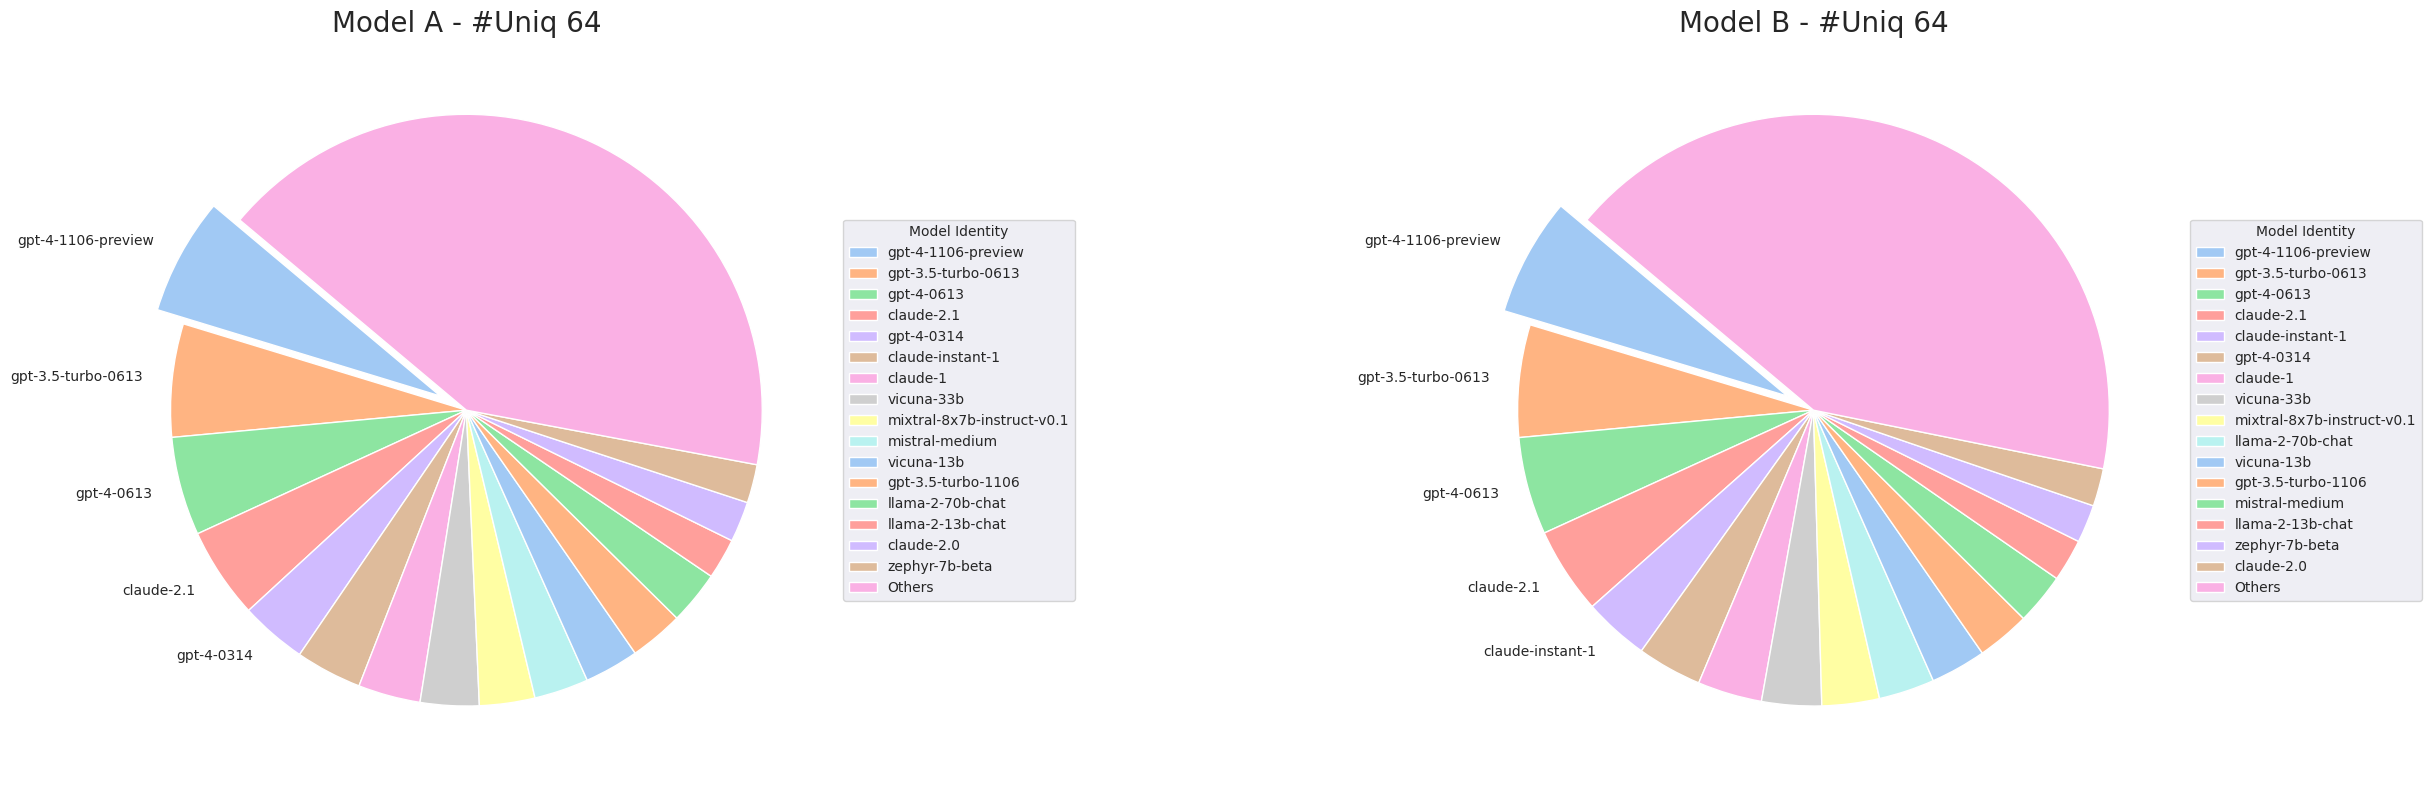

In [13]:
model_a_val_cnt = train["model_a"].value_counts()
model_b_val_cnt = train["model_b"].value_counts()
n_uniq_as, n_uniq_bs = len(model_a_val_cnt), len(model_b_val_cnt)
assert set(model_a_val_cnt.index) == set(model_b_val_cnt.index)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 8))
_plot_pie(
    model_a_val_cnt.values,
    model_a_val_cnt.index.tolist(), 
    title=f"Model A - #Uniq {n_uniq_as}",
    combine_minority=True,
    thres=0.02,
    max_labels=5,
    ax=axes[0]
)
_plot_pie(
    model_b_val_cnt.values,
    model_b_val_cnt.index.tolist(), 
    title=f"Model B - #Uniq {n_uniq_bs}",
    combine_minority=True,
    thres=0.02,
    max_labels=5,
    ax=axes[1]
)
plt.tight_layout()

<a id="btl"></a>
### *Battle Report*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Following [the official paper](https://arxiv.org/pdf/2403.04132), we first use heatmaps to observe battle counts and win rates of top 16 frequent models.
1. Some models have much greater battle counts than the others (*e.g.,* `gpt-4-1106-preview`).
    * This can be related to the sampling approach mentioned in the paper.
    > With these tools in hand, we have designed efficient sampling algorithms specifically to select model pairs in a way that accelerates the convergence of rankings while retaining statistical validity.
2. There exist strong LLMs which outperform the others consistently (*e.g.,* `gpt-4-x`).
3. Tie rates are generally lower than 40%, which means a winner can be judged in most cases.

In [14]:
df_btl = (
    train.groupby(["model_a", "model_b"], as_index=False)
    .agg({"prompt": "count", **{winner: "sum" for winner in TARGETS}})
    .rename({"prompt": "battle_cnt"}, axis=1)
    .sort_values("battle_cnt", ascending=False)
    .reset_index(drop=True)
)
df_btl["model_a_win_rate"] = df_btl["winner_model_a"] / df_btl["battle_cnt"]
df_btl["model_b_win_rate"] = df_btl["winner_model_b"] / df_btl["battle_cnt"]
df_btl["tie_rate"] = df_btl["winner_tie"] / df_btl["battle_cnt"]
df_btl.head(3)

model_a             model_b  battle_cnt  winner_model_a  \
0          claude-2.1  gpt-4-1106-preview         557             106   
1  gpt-4-1106-preview          claude-2.1         516             302   
2  gpt-4-1106-preview          gpt-4-0613         502             226   

   winner_model_b  winner_tie  model_a_win_rate  model_b_win_rate  tie_rate  
0             317         134          0.190305          0.569120  0.240575  
1              98         116          0.585271          0.189922  0.224806  
2             109         167          0.450199          0.217131  0.332669

In [15]:
def _plot_winner_map(
    df_btl: pd.DataFrame,
    winner: str = "a",
    title: str = "Battle Count",
) -> None:
    battle_cnt = df_btl.pivot(index="model_a", columns="model_b", values="battle_cnt")

    if winner == "a":
        win_rate_col = "model_a_win_rate"
        win_rate_title = "Win Rate of Model A"
    elif winner == "b":
        win_rate_col = "model_b_win_rate"
        win_rate_title = "Win Rate of Model B"
    else:
        win_rate_col = "tie_rate"
        win_rate_title = "Tie Rate"
    win_rate = df_btl.pivot(index="model_a", columns="model_b", values=win_rate_col)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
    sns.heatmap(battle_cnt, annot=True, fmt="g", cmap="rocket_r", ax=axes[0])
    axes[0].set_title(title)
    sns.heatmap(win_rate, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
    axes[1].set_title(win_rate_title)
    plt.tight_layout()

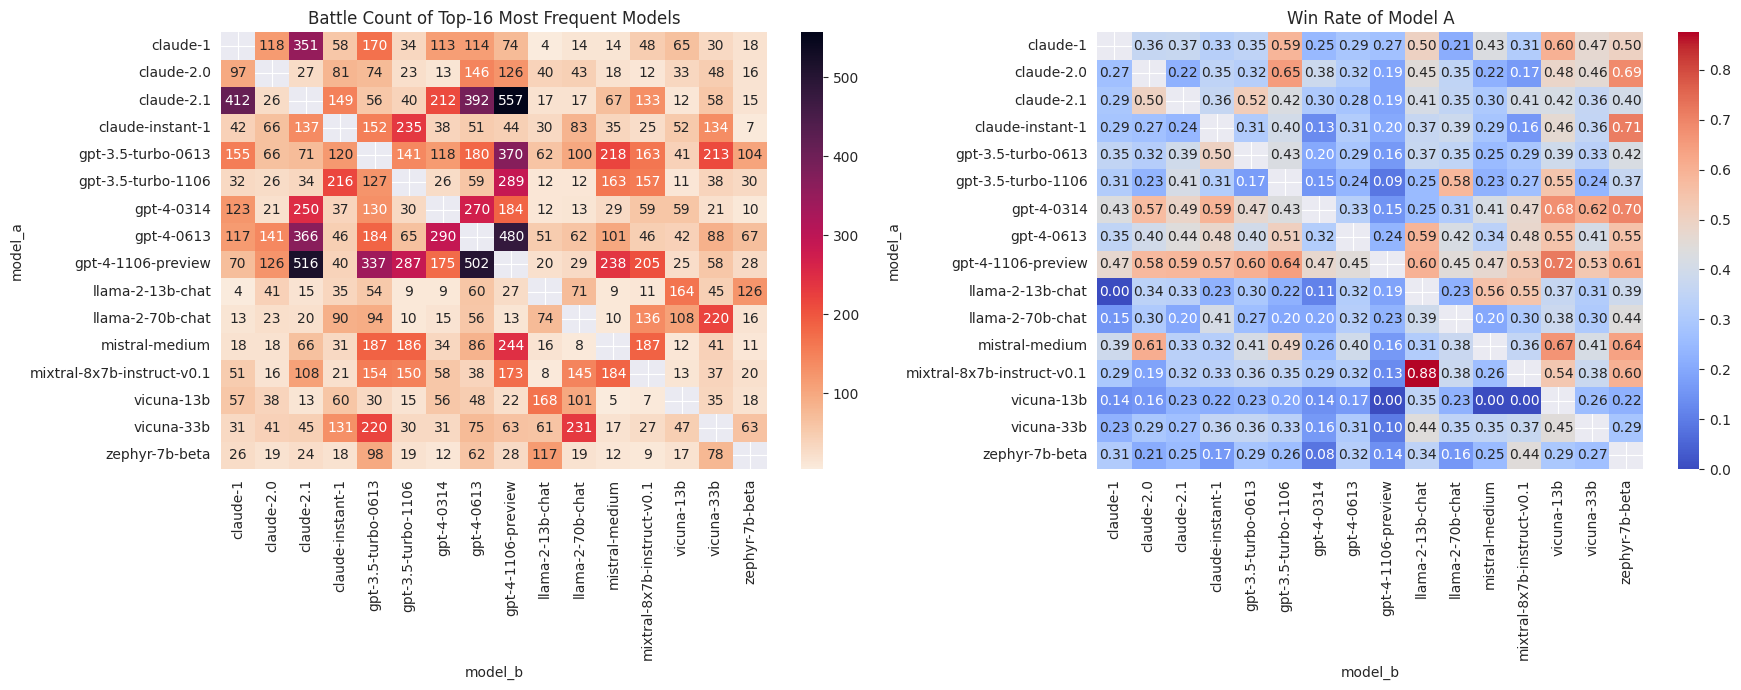

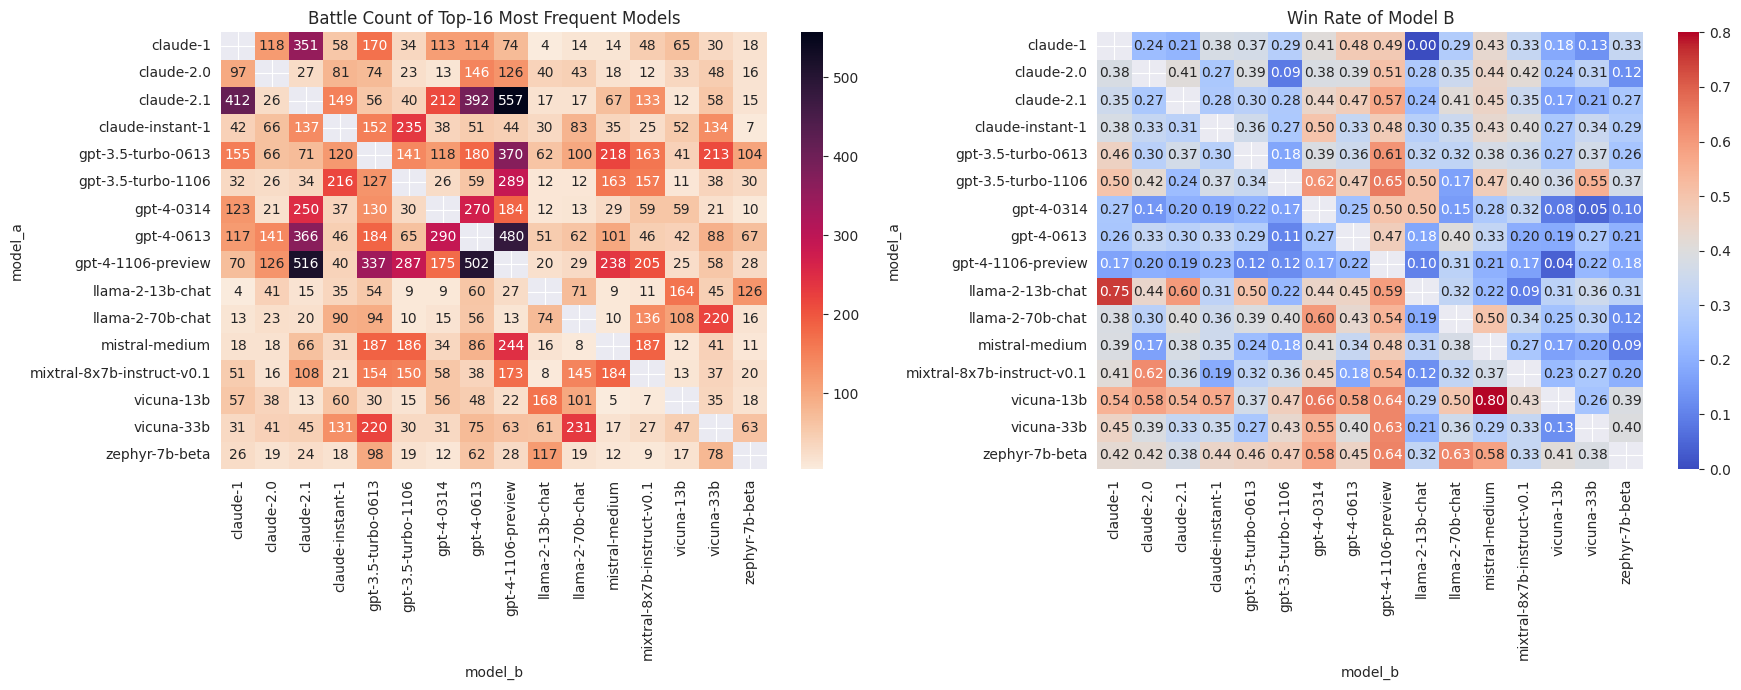

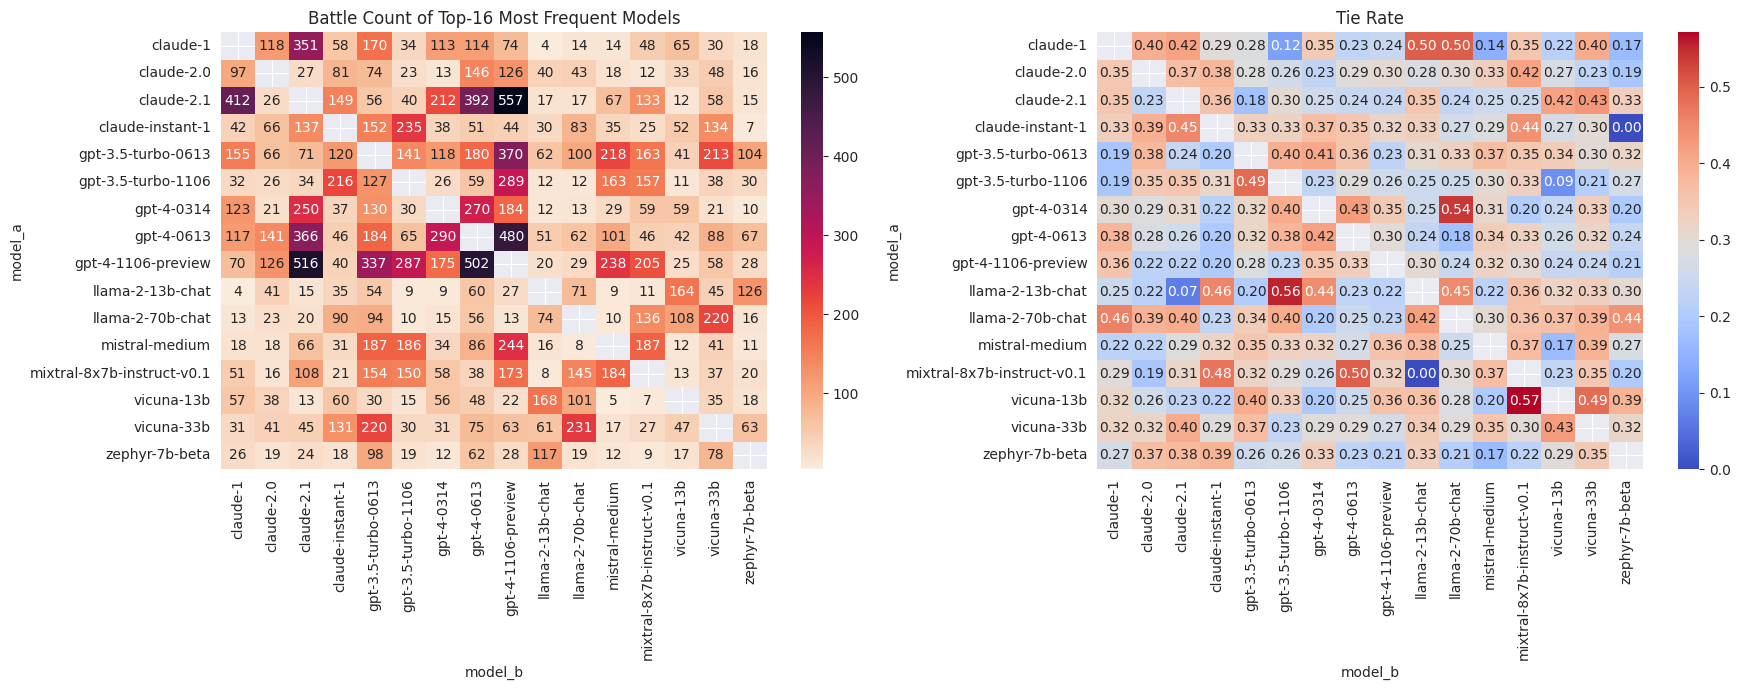

In [16]:
top16_models = set(model_a_val_cnt.index[:16])
tmp = df_btl.query("model_a in @top16_models and model_b in @top16_models").reset_index(drop=True)
title = "Battle Count of Top-16 Most Frequent Models"
for winner in ["a", "b", "tie"]:
    _plot_winner_map(tmp, winner=winner, title=title)

Next, we are going to analyze the battle report using barcharts. At the same time, we want to see whether the position of a LLM (*i.e.,* placed at A or B) affects the win rate or not. That is, we want to check if **position bias of judges** exists in the training set.

Observations are summarized as follows,
1. Three LLMs have win rate over 50%, including `gpt-3.5-turbo-0314`, `gpt-4-0125-preview` and `gpt-4-1106-preview`.
2. Position bias isn't present for human judges in this dataset.
3. A lower tie rate means that a winner can be judged more deterministically (*e.g.,* `gpt-3.5-turbo-0314`).

For more information about position bias, [this paper](https://openreview.net/forum?id=1hLFLNu4uy) introduces position bias of **LLM-based evaluators** and propose an alignment-based system to calibrate the bias.

In [17]:
btl_report_a = (
    df_btl[["model_a", "battle_cnt"] + TARGETS]
    .groupby("model_a", as_index=False).sum()
    .assign(panel=["a"] * 64)
)
btl_report_b = (
    df_btl[["model_b", "battle_cnt"] + TARGETS]
    .groupby("model_b", as_index=False).sum()
    .assign(panel=["b"] * 64)
)
btl_report = (
    pd.concat([btl_report_a, btl_report_b], ignore_index=True)
    .assign(model=btl_report_a["model_a"].tolist() * 2)
    .drop(["model_a", "model_b"], axis=1)
)

btl_report["n_wins"] = btl_report["winner_model_a"]
b_mask = btl_report["panel"] == "b"
btl_report.loc[b_mask, "n_wins"] = btl_report["winner_model_b"]
btl_report["win_rate"] = btl_report["n_wins"] / btl_report["battle_cnt"] * 100

btl_report["n_ties"] = btl_report["winner_tie"]
btl_report["tie_rate"] = btl_report["n_ties"] / btl_report["battle_cnt"] * 100

btl_report["n_loses"] = btl_report["winner_model_b"]
btl_report.loc[b_mask, "n_loses"] = btl_report["winner_model_a"]
btl_report["lose_rate"] = btl_report["n_loses"] / btl_report["battle_cnt"] * 100

btl_report.head(3)

battle_cnt  winner_model_a  winner_model_b  winner_tie panel  \
0         588             146             269         173     a   
1         709             180             307         222     a   
2         612             106             304         202     a   

              model  n_wins   win_rate  n_ties   tie_rate  n_loses  lose_rate  
0  RWKV-4-Raven-14B     146  24.829932     173  29.421769      269  45.748299  
1        alpaca-13b     180  25.387870     222  31.311707      307  43.300423  
2        chatglm-6b     106  17.320261     202  33.006536      304  49.673203

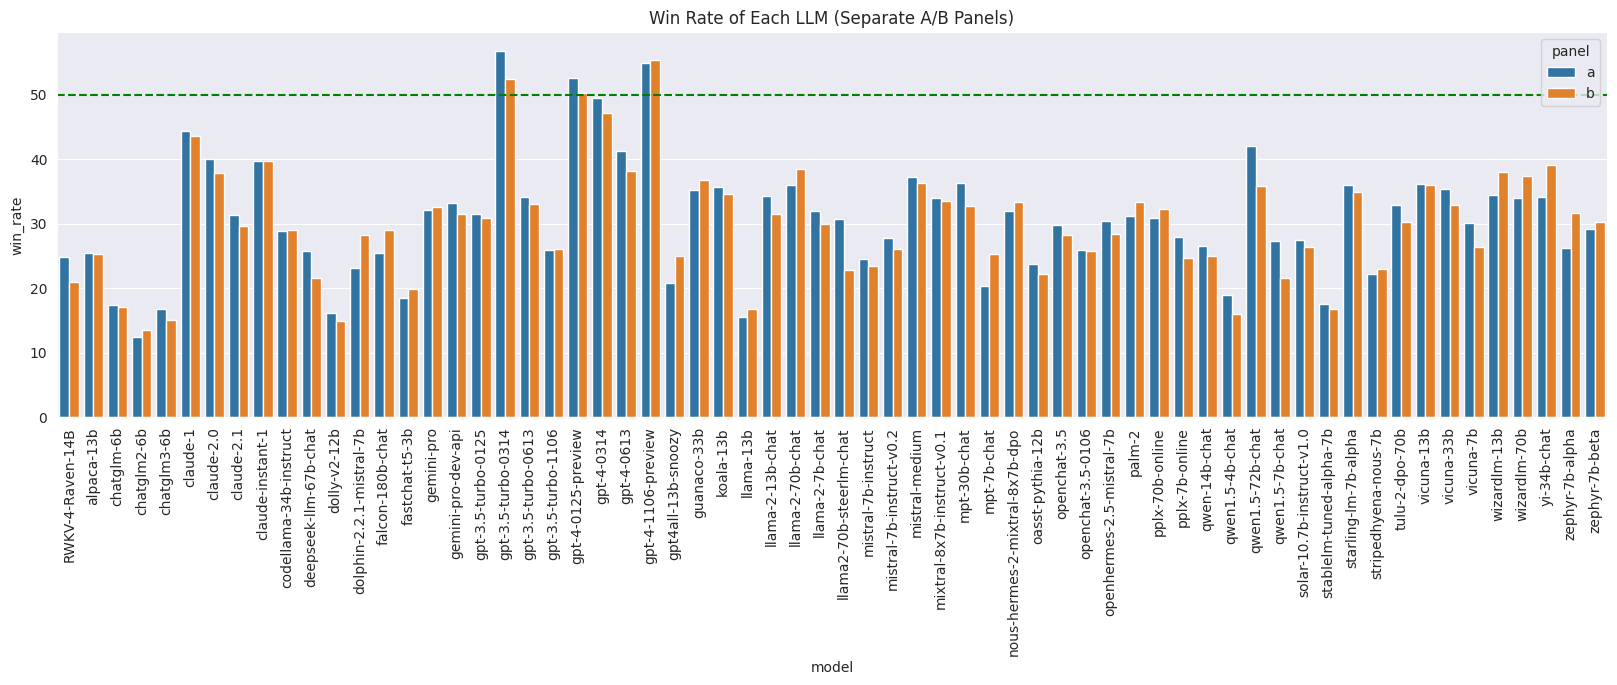

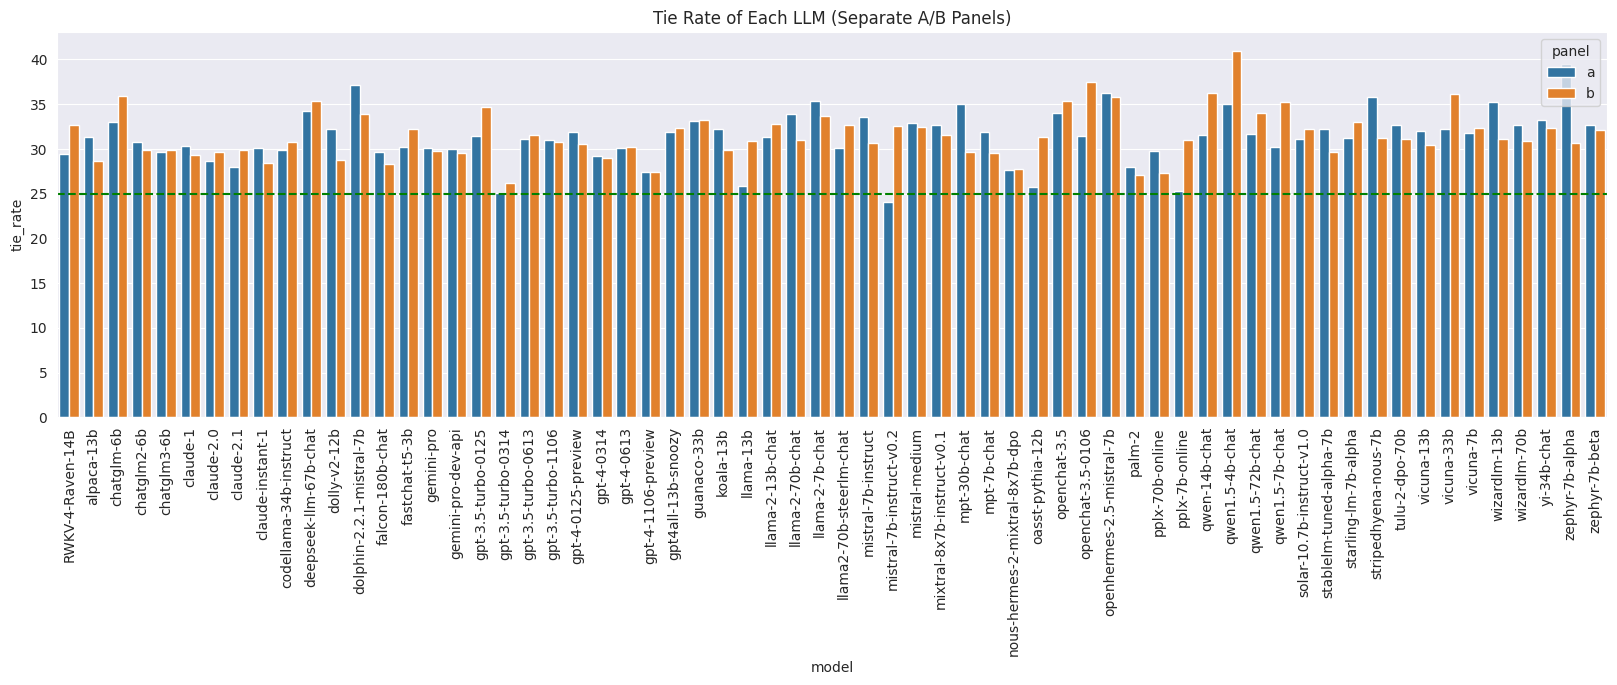

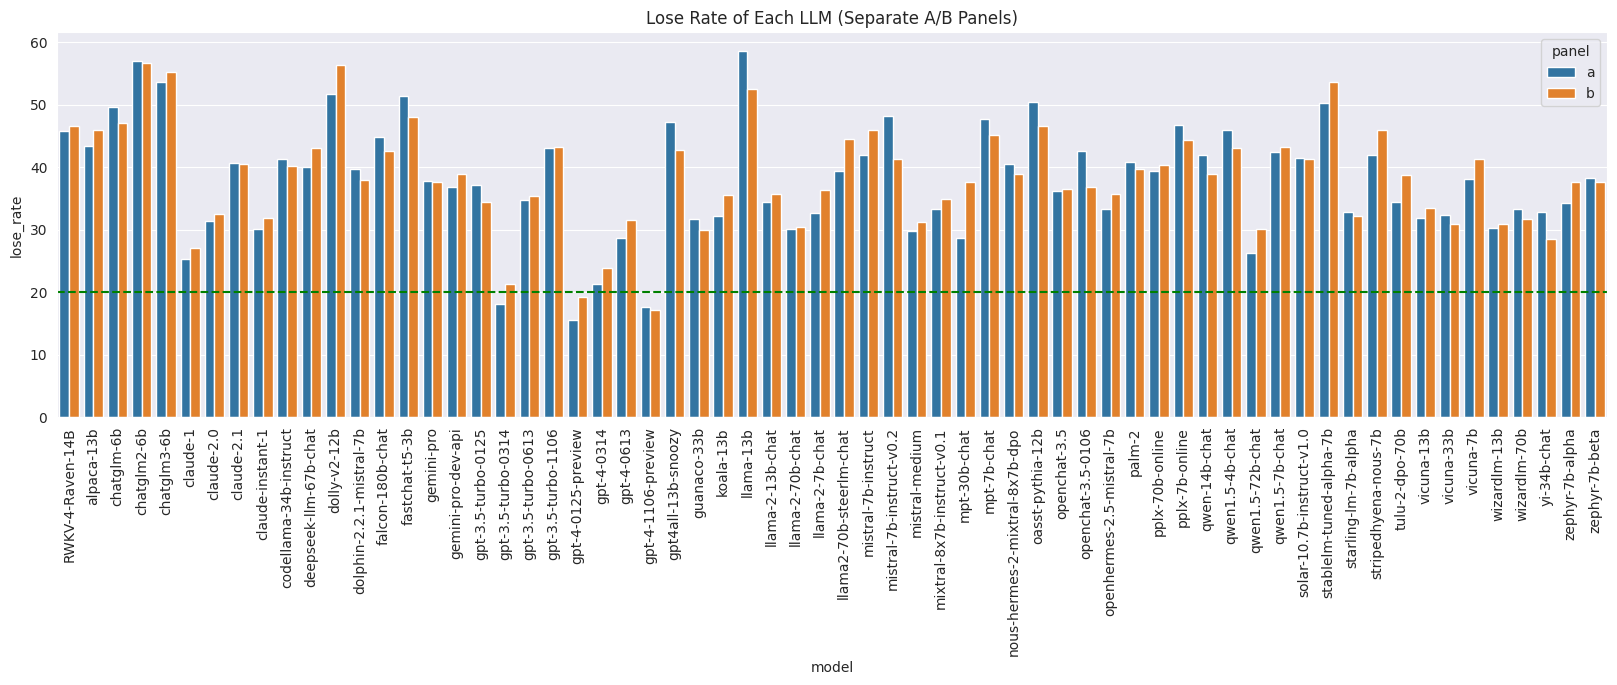

In [18]:
for rate, thres in zip(
    ["win_rate", "tie_rate", "lose_rate"],
    [50, 25, 20]
):
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.barplot(btl_report, x="model", y=rate, hue="panel", ax=ax)
    ax.axhline(thres, c="g", linestyle="--")
    ax.set_title(f"{rate.replace('_', ' ').title()} of Each LLM (Separate A/B Panels)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.show()

Then, we remove the position factor by aggregating reports by models.
1. Three LLMs have win rate over 50%, including `gpt-3.5-turbo-0314`, `gpt-4-0125-preview` and `gpt-4-1106-preview`.
2. Fiv LLMs have lose rate over 50%, including `chatglm-6b`, `chatglm3-6b`, `dolly-v2-12b`, `llama-13b` and `stablelm-tuned-alpha-7b`.

By plotting the target distribution, we can also see that the target is nearly balanced.

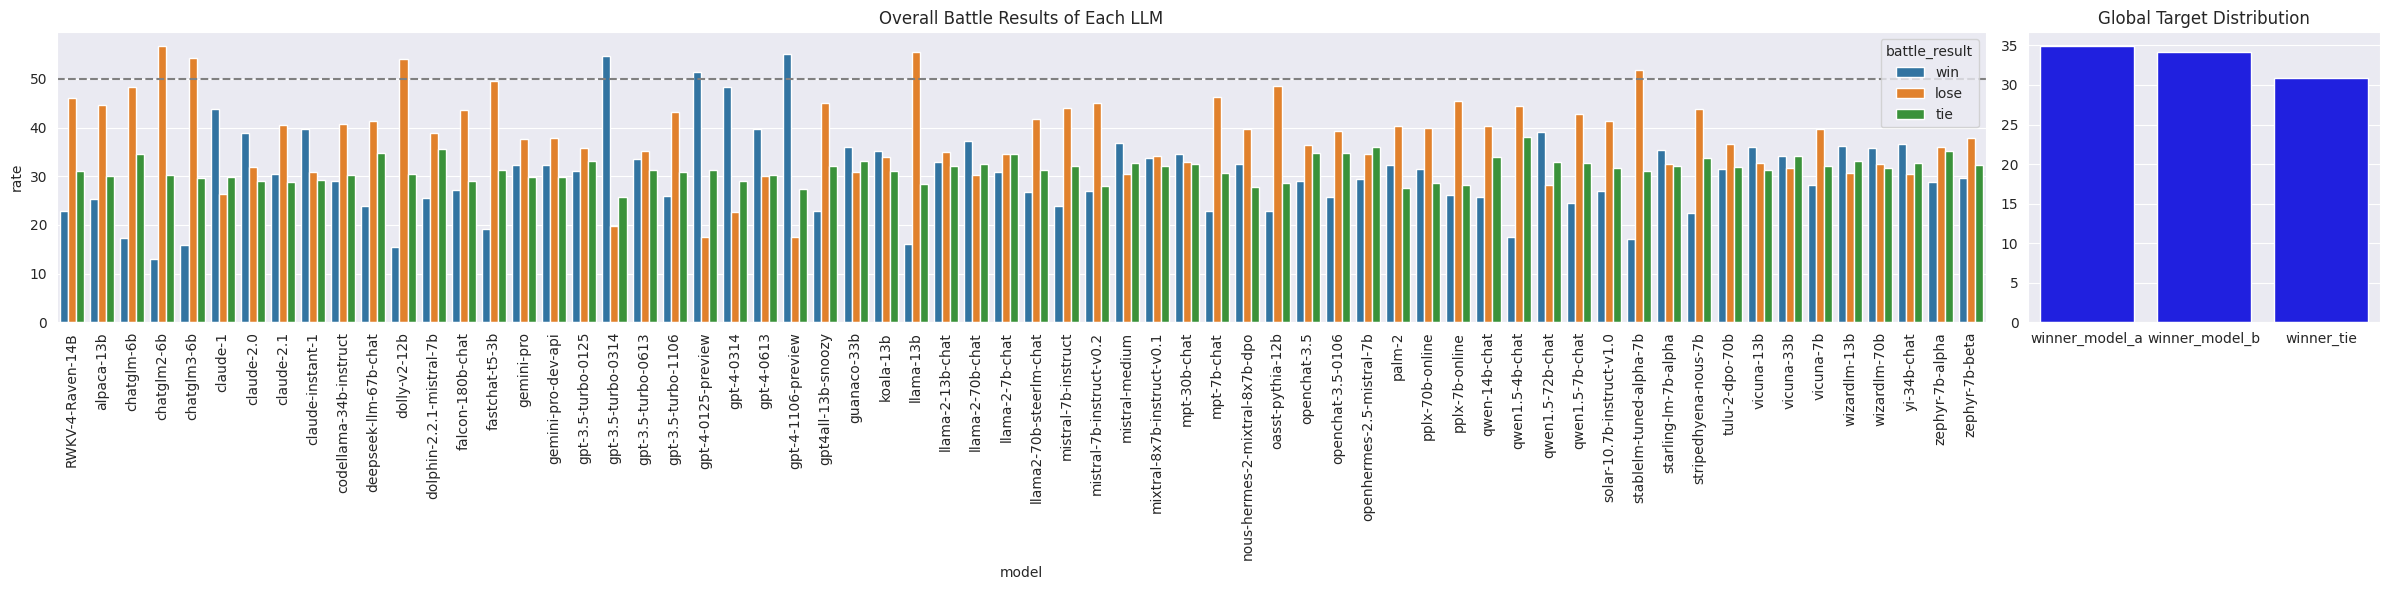

In [19]:
btl_report_mix = (
    btl_report
    .groupby("model", as_index=False)
    .agg({
        "battle_cnt": "sum",
        "n_wins": "sum",
        "n_ties": "sum",
        "n_loses": "sum",
    })
)
btl_report_mix["win_rate"] = btl_report_mix["n_wins"] / btl_report_mix["battle_cnt"] * 100
btl_report_mix["lose_rate"] = btl_report_mix["n_loses"] / btl_report_mix["battle_cnt"] * 100
btl_report_mix["tie_rate"] = btl_report_mix["n_ties"] / btl_report_mix["battle_cnt"] * 100
tmp = (
    pd.melt(btl_report_mix, id_vars=["model"], value_vars=["win_rate", "lose_rate", "tie_rate"])
    .rename({"variable": "battle_result", "value": "rate"}, axis=1)
)
tmp["battle_result"] = tmp["battle_result"].apply(lambda x: x.split("_")[0])


fig = plt.figure(figsize=(24, 6), layout="constrained")
gs = GridSpec(1, 24, figure=fig)

ax1 = fig.add_subplot(gs[:20])
sns.barplot(tmp, x="model", y="rate", hue="battle_result", ax=ax1)
ax1.axhline(50, c="gray", linestyle="--")
ax1.set_title(f"Overall Battle Results of Each LLM")
ax1.set_xticklabels(ax.get_xticklabels(), rotation = 90)

assert not train[TARGETS].isna().any().any()
ax2 = fig.add_subplot(gs[20:])
tgt_pct = train[TARGETS].sum() / len(train) * 100
sns.barplot(x=tgt_pct.index, y=tgt_pct.values, color="b", ax=ax2)
ax2.set_title("Global Target Distribution")

plt.tight_layout()

<a id="prompt_and_res"></a>
### *Prompt and Responses*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

In this section, we're going to dive deeper into the core part of raw data, prompts and responses. At first, let's check if there's any **missing values** in these three columns.

Because each entry is represented in string dtype, we need to call `eval()` beforehand. As can be seen, `eval()` fails for both response columns because `null` can't be handled.

In [20]:
for col in ["prompt", "response_a", "response_b"]:
    try:
        train[col] = train[col].apply(lambda x: eval(x))
    except Exception as e:
        print(f"eval() fails for column {col}...")
        print(f"Error: {e}")

eval() fails for column response_a...
Error: name 'null' is not defined
eval() fails for column response_b...
Error: name 'null' is not defined


From this quick experiment, we now know what happened. `eval()` fails if there's at least one response is `null`, not `'null'`. To solve this issue, we just replace `null` by `None`, and everything works fine!

In [21]:
demo_str1 = "['I do not have any confirmed details about null a World War III.', 'null']"
demo_str2 = "['I do not have any confirmed details about null a World War III.', null]"
try:
    _ = eval(demo_str1)
except:
    print(f"eval() fails for demo_str1.")
try:
    _ = eval(demo_str2)
except:
    print(f"eval() fails for demo_str2.")

eval() fails for demo_str2.


In [22]:
for col in ["response_a", "response_b"]:
    train[col] = train[col].apply(lambda x: eval(x.replace("null", "None")))

After `eval()` succeeds, we make sure that the number of prompts matches the number of `response_a` and `response_b`. Now, we can guarantee that each single prompt has exactly one corresponding answer. However, as we reveal above, there still exists `null` responses to be handled.

To comprehensively explore **missing values**, we not only check `null` prompts and responses, but also empty ones. Observations are summarized as follows,
1. There exists 5 samples with empty prompts.
    * All of the empty prompts are a single space `" "` and appear at the last prompt during conversation.
    * Models can still continue to respond even if an empty prompt is sent.
2. There exist 120+ rows with `None` responses for both A and B. 
3. There exist 30+ rows with empty responses for both A and B.

**Note:** Empty string is defined as a string containing only spaces, tabs and newlines, which can be detected by a simple regex,
```python
demo_str = " \n\t"
bool(re.match("^\s*$", demo_str))  # True
```

In [23]:
def _is_empty(string: str) -> bool:
    return bool(re.match("^\s*$", string))

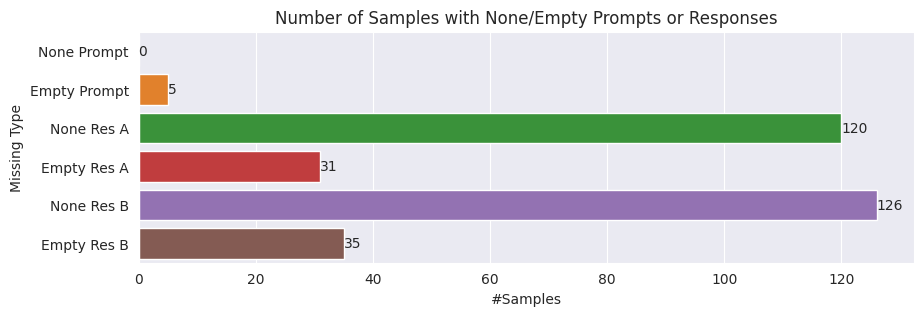

In [24]:
train["n_prompts"] = train["prompt"].apply(lambda x: len(x))
train["n_res_a"] = train["response_a"].apply(lambda x: len(x))
train["n_res_b"] = train["response_b"].apply(lambda x: len(x))
assert ((train["n_prompts"] == train["n_res_a"]) & (train["n_prompts"] == train["n_res_b"])).all()

train["n_na_prompts"] = train["prompt"].apply(lambda ps: sum(1 if p is None else 0 for p in ps))
train["n_empty_prompts"] = train["prompt"].apply(lambda ps: sum(1 if p is not None and _is_empty(p) else 0 for p in ps))
train["n_na_res_a"] = train["response_a"].apply(lambda ps: sum(1 if p is None else 0 for p in ps))
train["n_empty_res_a"] = train["response_a"].apply(lambda ps: sum(1 if p is not None and _is_empty(p) else 0 for p in ps))
train["n_na_res_b"] = train["response_b"].apply(lambda ps: sum(1 if p is None else 0 for p in ps))
train["n_empty_res_b"] = train["response_b"].apply(lambda ps: sum(1 if p is not None and _is_empty(p) else 0 for p in ps))

fig, ax = plt.subplots(figsize=(10, 3))
tmp = train.iloc[:, -6:].sum()
sns.barplot(x=tmp.values, y=tmp.index, ax=ax)
ax.set_title("Number of Samples with None/Empty Prompts or Responses")
ax.set_xlabel("#Samples")
ax.set_ylabel("Missing Type")
ax.set_yticks(
    list(range(6)),
    ["None Prompt", "Empty Prompt", "None Res A", "Empty Res A", "None Res B", "Empty Res B"]
)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

In [25]:
for i, r in train.query("n_empty_prompts > 0").iterrows():
    print(f"Conversation {i} | #Prompts {len(r['prompt'])}")
    for j, p in enumerate(r["prompt"]):
        if _is_empty(p):
            print(f"The {j}-th prompt is empty...")
            if r["response_a"][j] is not None and not _is_empty(r["response_a"][j]):
                print("Model A responds!")
            if r["response_b"][j] is not None and not _is_empty(r["response_b"][j]):
                print("Model B responds!")
    print("-" * 50)

Conversation 11539 | #Prompts 2
The 1-th prompt is empty...
Model A responds!
Model B responds!
--------------------------------------------------
Conversation 16879 | #Prompts 2
The 1-th prompt is empty...
--------------------------------------------------
Conversation 18491 | #Prompts 2
The 1-th prompt is empty...
Model A responds!
Model B responds!
--------------------------------------------------
Conversation 19522 | #Prompts 2
The 1-th prompt is empty...
Model A responds!
Model B responds!
--------------------------------------------------
Conversation 27813 | #Prompts 5
The 4-th prompt is empty...
Model A responds!
Model B responds!
--------------------------------------------------


Following we take one example of empty prompt, one `None` response, and one empty response to see what they look like.

For the first case, **empty prompt**, we observe that models can continue to respond even if an empty string is sent as a prompt. We test the same conversation in Chatbot Arena for multiple runs and following shows one of the test result,
<div>
    <img src="https://i.postimg.cc/wTdFGVSD/Screenshot-2024-05-29-at-4-03-43-PM.png" width="800"/>
</div>

1. Both models complete answers in the first responses.
2. Some models will throw an error message if an empty prompt is sent,
```
NETWORK ERROR DUE TO HIGH TRAFFIC. PLEASE REGENERATE OR REFRESH THIS PAGE.
(error_code: 50004, Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages: text content blocks must contain non-whitespace text'}})
```

However, both models in the training dataset fail to respond completely in their first responses, which isn't observed in our tests.

In [26]:
ChatRenderer(train.iloc[19522]).display()

For case, `None` **response**, two models' responses are `None`. I also feed the same prompt to Chatbot Arena and get responses from `gpt-4o-2024-05-13` and `yi-large-preview` which is shown below,
<div>
    <img src="https://i.postimg.cc/5NdwQqtD/Screenshot-2024-05-28-at-10-51-36-PM.png" width="800"/>
</div>

In [27]:
ChatRenderer(train.iloc[780]).display()

For case, **empty response**, model A responds with empty string, which seems weird. We feed the same prompt to Chatbot Arena in two forms,

1. Feed this Prompt As Is
<div>
    <img src="https://i.postimg.cc/Qx4wXw2Z/Screenshot-2024-05-28-at-11-38-34-PM.png" width="800"/>
</div>

2. Feed this Prompt without QAs at the End of Prompt
<div>
    <img src="https://i.postimg.cc/tCgJKz4s/Screenshot-2024-05-28-at-10-59-13-PM.png" width="800"/>
</div>

<div class="alert alert-block alert-danger">
    <h4>Discussion</h4>
    <p>By comparing responses from Chatbot Arena above and those in the dataset, is it possbile that responses are mixed into prompts by mistake?</p>
</div>

In [28]:
ChatRenderer(train.iloc[8042]).display()

<a id="miss_res"></a>
### *Effect of Missing Responses*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Next, we want to further consider the effect of **missing responses** (either `None` or empty) on the final judges.

In [29]:
df_mis = train.query("n_na_res_a > 0 or n_empty_res_a > 0 or n_na_res_b > 0 or n_empty_res_b > 0")
print(f"There are {len(df_mis)} samples with at least one missing response present in at least one model.")

There are 205 samples with at least one missing response present in at least one model.


#### **Both** models have at least one missing responses during the conversation.
1. Single-prompt conversation
    * We can see that over 60% of the samples are judged as ties. So, can we just predict `winner_tie` if this condition holds?
        * Predicting `winner_tie` all the time has a log loss around 13.28. We need to think about how to handle these samples!
    * All missing responses are `None`, not empty.
2. Multi-prompt conversation
    * Target distribution looks close to the global one.
    * Both models have **at least one non-missing response**, which can be used to choose a winner.
    * Except for row 18590, all missing responses are `None`.

In [30]:
df_mis_both = df_mis.query("(n_na_res_a > 0 or n_empty_res_a > 0) and (n_na_res_b > 0 or n_empty_res_b > 0)")
df_mis_both_s = df_mis_both.query("n_prompts == 1")
df_mis_both_m = df_mis_both.query("n_prompts > 1")
print(f"There are {len(df_mis_both)} samples with at least one missing response present in both models.")
print(f"-> {len(df_mis_both_s)} of them have only one prompt, and {len(df_mis_both_m)} have multiple.")

There are 71 samples with at least one missing response present in both models.
-> 19 of them have only one prompt, and 52 have multiple.


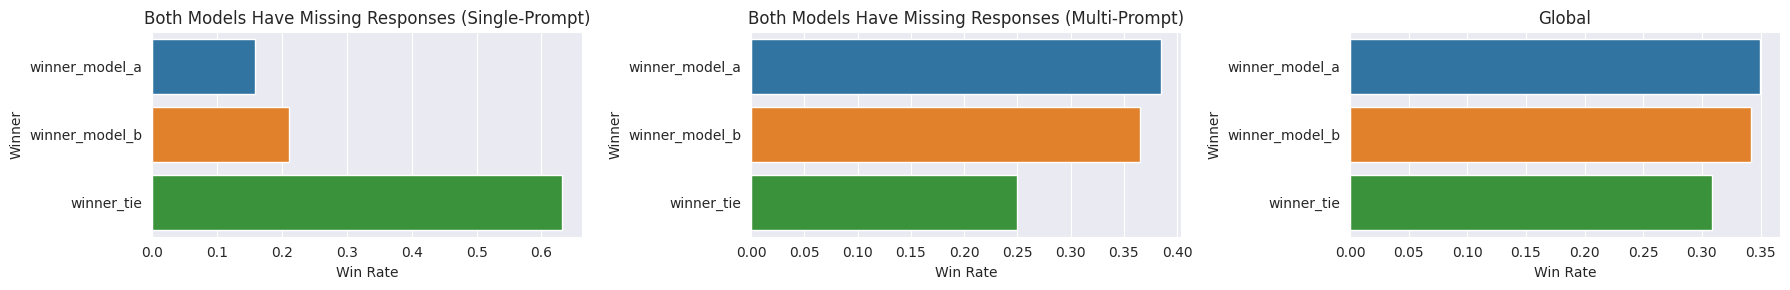

In [31]:
win_rate_s = df_mis_both_s[TARGETS].sum() / df_mis_both_s[TARGETS].sum().sum()
win_rate_m = df_mis_both_m[TARGETS].sum() / df_mis_both_m[TARGETS].sum().sum()
win_rate_g = train[TARGETS].sum() / len(train)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
sns.barplot(x=win_rate_s.values, y=win_rate_s.index, ax=axes[0])
axes[0].set_title("Both Models Have Missing Responses (Single-Prompt)")
axes[0].set_xlabel("Win Rate")
axes[0].set_ylabel("Winner")
sns.barplot(x=win_rate_m.values, y=win_rate_m.index, ax=axes[1])
axes[1].set_title("Both Models Have Missing Responses (Multi-Prompt)")
axes[1].set_xlabel("Win Rate")
axes[1].set_ylabel("Winner")
sns.barplot(x=win_rate_g.values, y=win_rate_g.index, ax=axes[2])
axes[2].set_title("Global")
axes[2].set_xlabel("Win Rate")
axes[2].set_ylabel("Winner")
plt.tight_layout()

In [32]:
y_true = np.where(df_mis_both_s[TARGETS].values)[1]
y_pred = np.zeros((len(y_true), 3))
y_pred[:, 2] = 1
print(f"Log loss of predicting winner_tie for single-prompt all the time: {log_loss(y_true, y_pred):.2f} ...")

Log loss of predicting winner_tie for single-prompt all the time: 13.28 ...


In [33]:
# row 18590 behaves a little bit different (None for A, but empty for B)
df_mis_both_m["n_miss_res_a"] = df_mis_both_m["n_na_res_a"] + df_mis_both_m["n_empty_res_a"]
df_mis_both_m["n_miss_res_b"] = df_mis_both_m["n_na_res_b"] + df_mis_both_m["n_empty_res_b"]
all_missing_res = df_mis_both_m.query("(n_prompts == n_miss_res_a) or (n_prompts == n_miss_res_b)")
print(f"There are {len(all_missing_res)} samples with at least one model having missing responses in all turns.")

There are 0 samples with at least one model having missing responses in all turns.


#### **Either model A or B** has at least one missing responses during the conversation.
1. Single-prompt conversation
    * We can see that the tie rate drops to around 0.15, which is quite reasonble.
        * If only one model has missing responses, judges might tend to vote the other responding normally or tie.
        * The only interesting case (row 26900) in which the winner is the model with missing responses has the `Please reply with “<|endoftext|>”`.
    * Missing responses are all **empty**, not `None`.
2. Multi-prompt conversation
    * Target distribution looks close to the global one.
    * Nearly all models with missing responses still have at least one non-missing response, which can be used to choose a winner.
        * There's only one sample (row 650) with model A having all missing responses, and the winner is model B!
    * Missing responses can be empty or `None`.
        * Only row 40205 has both empty and `None` present, the others only have one missing type during the conversation.

In [34]:
df_mis_one = df_mis.query("index not in @df_mis_both.index")
df_mis_one_s = df_mis_one.query("n_prompts == 1")
df_mis_one_m = df_mis_one.query("n_prompts > 1")
print(f"There are {len(df_mis_one)} samples with at least one missing response present in either model A or B, but not both.")
print(f"-> {len(df_mis_one_s)} of them have only one prompt, and {len(df_mis_one_m)} have multiple.")

There are 134 samples with at least one missing response present in either model A or B, but not both.
-> 25 of them have only one prompt, and 109 have multiple.


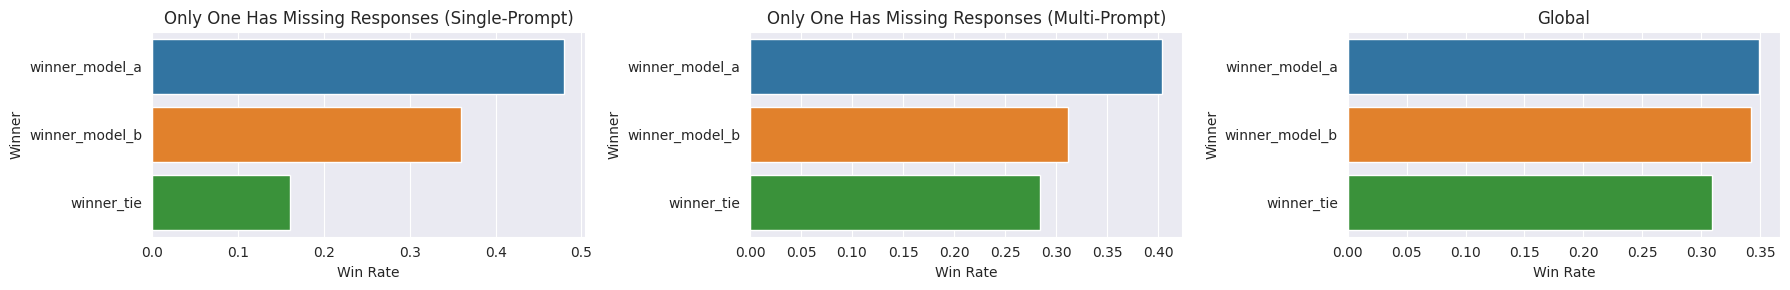

In [35]:
win_rate_s = df_mis_one_s[TARGETS].sum() / df_mis_one_s[TARGETS].sum().sum()
win_rate_m = df_mis_one_m[TARGETS].sum() / df_mis_one_m[TARGETS].sum().sum()
win_rate_g = train[TARGETS].sum() / len(train)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
sns.barplot(x=win_rate_s.values, y=win_rate_s.index, ax=axes[0])
axes[0].set_title("Only One Has Missing Responses (Single-Prompt)")
axes[0].set_xlabel("Win Rate")
axes[0].set_ylabel("Winner")
sns.barplot(x=win_rate_m.values, y=win_rate_m.index, ax=axes[1])
axes[1].set_title("Only One Has Missing Responses (Multi-Prompt)")
axes[1].set_xlabel("Win Rate")
axes[1].set_ylabel("Winner")
sns.barplot(x=win_rate_g.values, y=win_rate_g.index, ax=axes[2])
axes[2].set_title("Global")
axes[2].set_xlabel("Win Rate")
axes[2].set_ylabel("Winner")
plt.tight_layout()

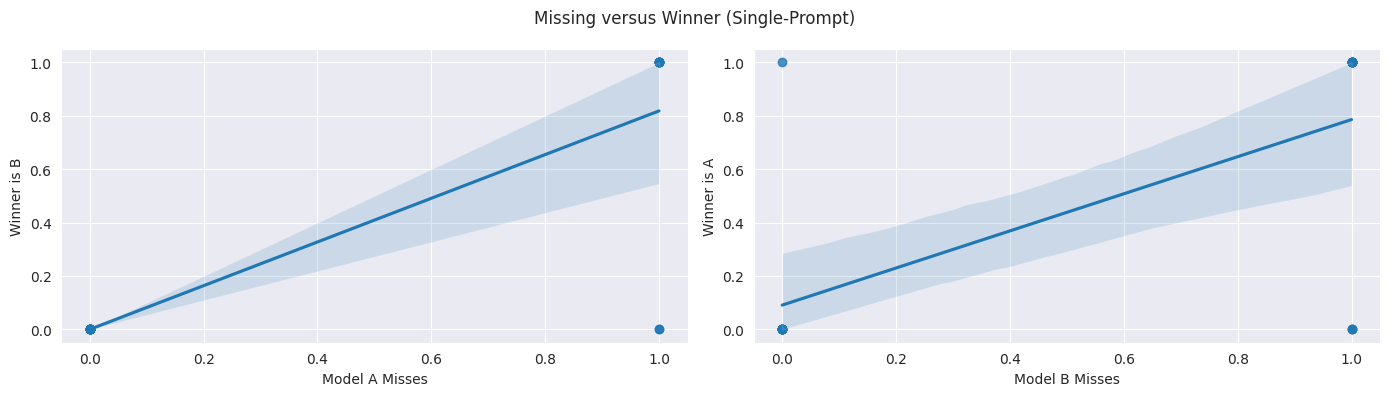

In [36]:
df_mis_one_s["n_miss_res_a"] = df_mis_one_s["n_na_res_a"] + df_mis_one_s["n_empty_res_a"]
df_mis_one_s["n_miss_res_b"] = df_mis_one_s["n_na_res_b"] + df_mis_one_s["n_empty_res_b"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.regplot(data=df_mis_one_s, x="n_miss_res_a", y="winner_model_b", ax=axes[0])
axes[0].set_xlabel("Model A Misses")
axes[0].set_ylabel("Winner is B")
sns.regplot(data=df_mis_one_s, x="n_miss_res_b", y="winner_model_a", ax=axes[1])
axes[1].set_xlabel("Model B Misses")
axes[1].set_ylabel("Winner is A")
# Mark corner case on top left...
plt.suptitle("Missing versus Winner (Single-Prompt)")
plt.tight_layout()

In [37]:
df_mis_one_s.query("(n_miss_res_a > 0 and winner_model_a == 1) or (n_miss_res_b > 0 and winner_model_b == 1)")

model_a               model_b  \
26900  gpt-4-0125-preview  stripedhyena-nous-7b   

                                    prompt response_a  \
26900  [Please reply with "<|endoftext|>"]         []   

                                              response_b  winner_model_a  \
26900  [Of course, I'll be happy to assist you. Pleas...               1   

       winner_model_b  winner_tie  n_prompts  n_res_a  n_res_b  n_na_prompts  \
26900               0           0          1        1        1             0   

       n_empty_prompts  n_na_res_a  n_empty_res_a  n_na_res_b  n_empty_res_b  \
26900                0           0              1           0              0   

       n_miss_res_a  n_miss_res_b  
26900             1             0

In [38]:
ChatRenderer(train.iloc[26900]).display()

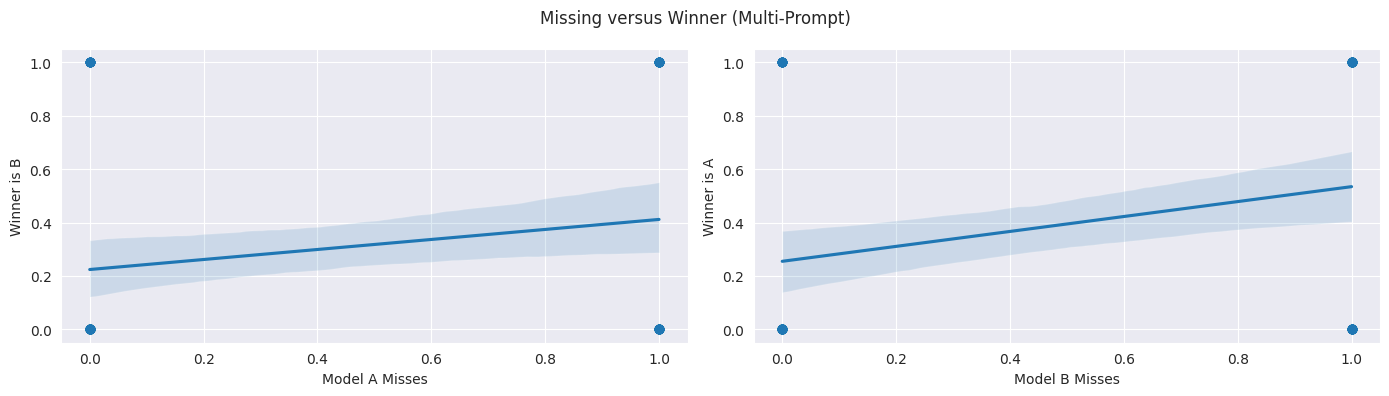

In [39]:
df_mis_one_m["n_miss_res_a"] = df_mis_one_m["n_na_res_a"] + df_mis_one_m["n_empty_res_a"]
df_mis_one_m["n_miss_res_b"] = df_mis_one_m["n_na_res_b"] + df_mis_one_m["n_empty_res_b"]
df_mis_one_m["model_a_miss"] = df_mis_one_m["n_miss_res_a"] > 0
df_mis_one_m["model_b_miss"] = df_mis_one_m["n_miss_res_b"] > 0

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.regplot(data=df_mis_one_m, x="model_a_miss", y="winner_model_b", ax=axes[0])
axes[0].set_xlabel("Model A Misses")
axes[0].set_ylabel("Winner is B")
sns.regplot(data=df_mis_one_m, x="model_b_miss", y="winner_model_a", ax=axes[1])
axes[1].set_xlabel("Model B Misses")
axes[1].set_ylabel("Winner is A")
plt.suptitle("Missing versus Winner (Multi-Prompt)")
plt.tight_layout()

In the following query, we can that row 650 is the only sample with one model (model A) having all missing responses in a multi-turn conversation. Finally, model B is selected as a winner.

In [40]:
df_mis_one_m.query("n_miss_res_a == n_prompts or n_miss_res_b == n_prompts")

model_a           model_b  \
650  wizardlm-70b  claude-instant-1   

                                                prompt response_a  \
650  [\n#include "trtSettings.h"\n#include "trtkern...       [, ]   

                                            response_b  winner_model_a  \
650  [Here are a few things you could try to improv...               0   

     winner_model_b  winner_tie  n_prompts  n_res_a  n_res_b  n_na_prompts  \
650               1           0          2        2        2             0   

     n_empty_prompts  n_na_res_a  n_empty_res_a  n_na_res_b  n_empty_res_b  \
650                0           0              2           0              0   

     n_miss_res_a  n_miss_res_b  model_a_miss  model_b_miss  
650             2             0          True         False

As for this query, we want to find if there's any sample with both empty and `None` responses present in a multi-turn conversation. We find that only row 40250 has this property!

In [41]:
df_mis_one_m.query("(n_na_res_a > 0 and n_empty_res_a > 0) or (n_na_res_b > 0 and n_empty_res_b > 0)")

model_a                model_b  \
40205  gpt-4-0125-preview  deepseek-llm-67b-chat   

                                                  prompt  \
40205  [Let's play a text based adventure game, it's ...   

                                              response_a  \
40205  [You find yourself standing at the edge of the...   

                                              response_b  winner_model_a  \
40205  [Sure, I can play the sassy, sarcastic compani...               1   

       winner_model_b  winner_tie  n_prompts  n_res_a  n_res_b  n_na_prompts  \
40205               0           0         35       35       35             0   

       n_empty_prompts  n_na_res_a  n_empty_res_a  n_na_res_b  n_empty_res_b  \
40205                0           0              0           2              6   

       n_miss_res_a  n_miss_res_b  model_a_miss  model_b_miss  
40205             0             8         False          True

<a id="len"></a>
### *All about Length - Turns and Verbosity*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Let's continue to discuss another topic, the length. Here, we'll investigate whether factors like the number of prompts (*i.e.,* the number of turns), the length of prompts, and the length of responses will affect the judges or not.

#### Number of Turns
1. Around 86.88% of conversations are **single-turn**.
2. Over 99.19% of conversations are less than 6 turns.
3. The maximum number of turns is 36.

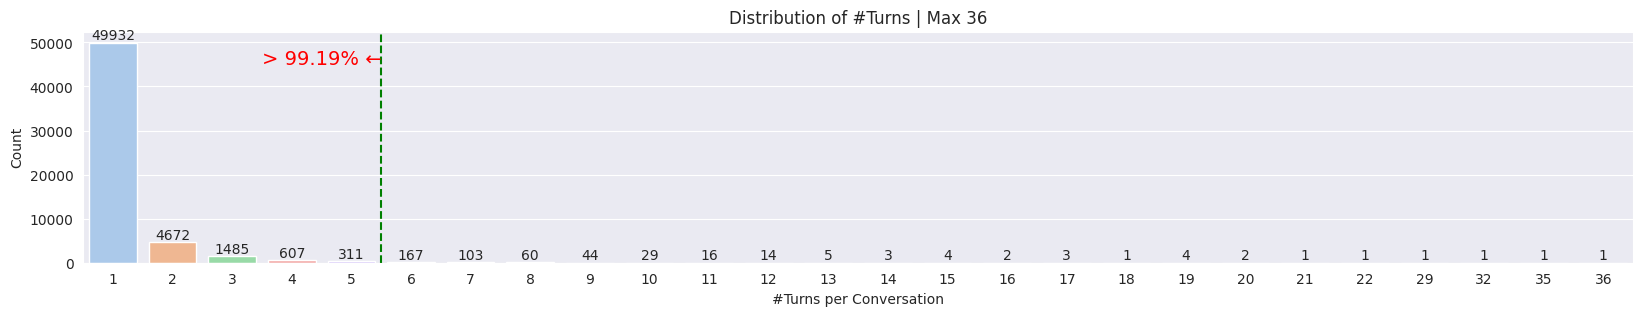

In [42]:
n_turns_val_cnt = train["n_prompts"].value_counts().sort_index()
data, labels = n_turns_val_cnt.values, n_turns_val_cnt.index.tolist()
data_norm = data / np.sum(data) * 100
n_turns_max = np.max(labels)

fig, ax = plt.subplots(figsize=(20, 3))
sns.barplot(x=labels, y=data, palette=colors, ax=ax)
ax.text(4.5, 45000, "> 99.19% ←", c="r", fontsize=14, ha="right")
ax.axvline(4.5, c="g", linestyle="--")
ax.set_title(f"Distribution of #Turns | Max {n_turns_max}")
ax.set_xlabel("#Turns per Conversation")
ax.set_ylabel("Count")
for container in ax.containers:
    ax.bar_label(container)
plt.show()

#### Number of Effective Responses
We've already had an idea about missing responses. Next, we want to analyze the distribution of effective (non-missing) responses. As shown below, we observe that,
1. There exist models with 0 effective responses, which we've seen previously.
2. The distributions of #effective responses of both models look similar to that of #turns.

In [43]:
train["n_miss_res_a"] = train["n_na_res_a"] + train["n_empty_res_a"]
train["n_miss_res_b"] = train["n_na_res_b"] + train["n_empty_res_b"]

# Derive effective responses (non-missing)
train["n_eff_res_a"] = train["n_res_a"] - train["n_miss_res_a"]
train["n_eff_res_b"] = train["n_res_b"] - train["n_miss_res_b"]
train.head(1)

model_a     model_b  \
0  gpt-4-1106-preview  gpt-4-0613   

                                              prompt  \
0  [Is it morally right to try to have a certain ...   

                                          response_a  \
0  [The question of whether it is morally right t...   

                                          response_b  winner_model_a  \
0  [As an AI, I don't have personal beliefs or op...               1   

   winner_model_b  winner_tie  n_prompts  n_res_a  n_res_b  n_na_prompts  \
0               0           0          2        2        2             0   

   n_empty_prompts  n_na_res_a  n_empty_res_a  n_na_res_b  n_empty_res_b  \
0                0           0              0           0              0   

   n_miss_res_a  n_miss_res_b  n_eff_res_a  n_eff_res_b  
0             0             0            2            2

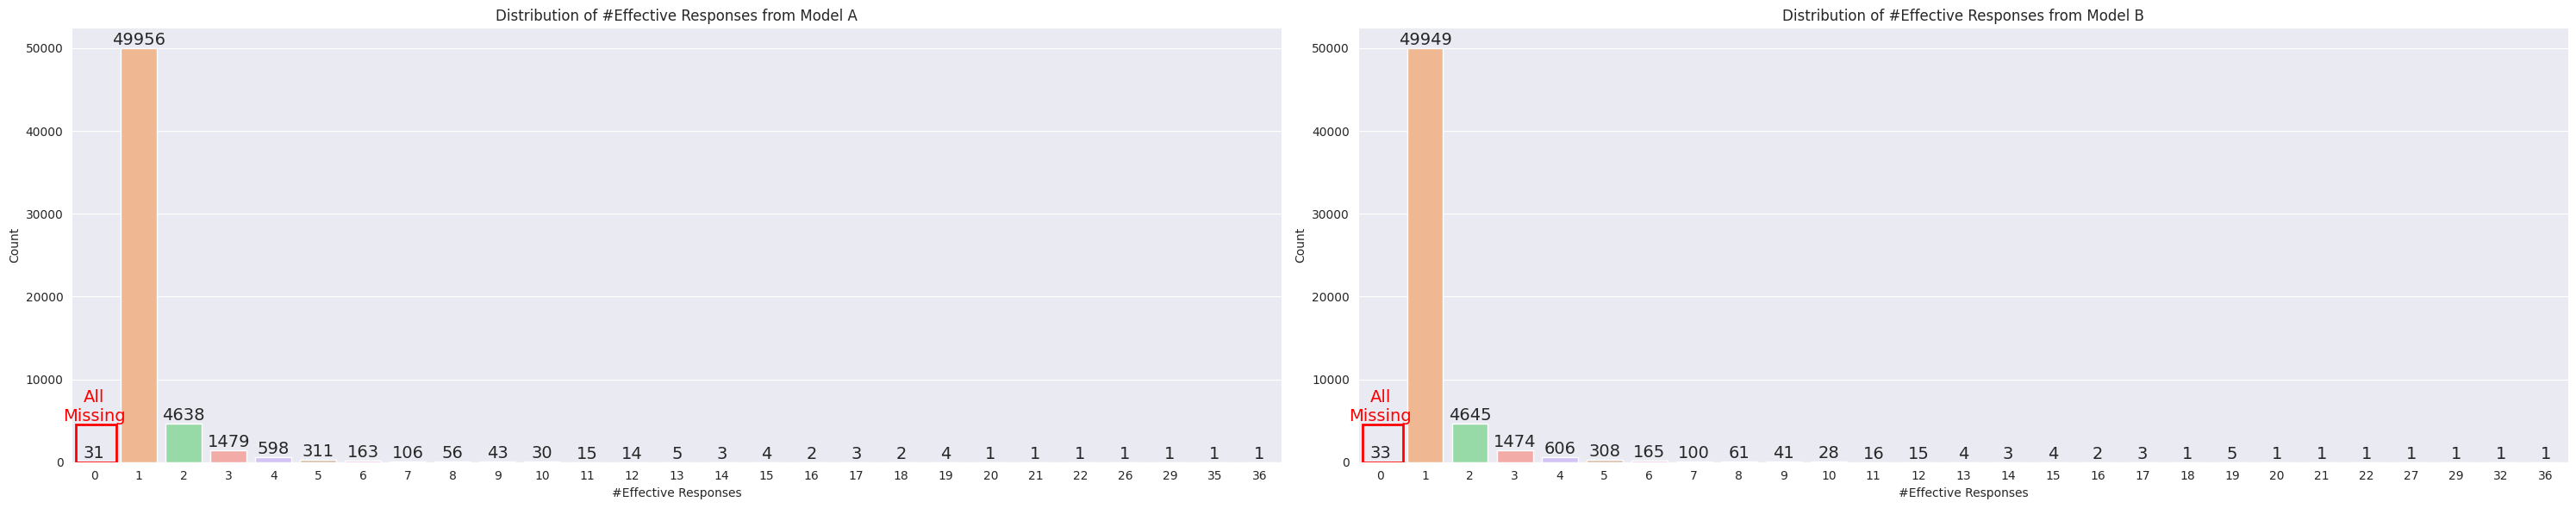

In [44]:
n_res_a_val_cnt = train["n_eff_res_a"].value_counts().sort_index()
data_a, labels_a = n_res_a_val_cnt.values, n_res_a_val_cnt.index.tolist()
n_res_b_val_cnt = train["n_eff_res_b"].value_counts().sort_index()
data_b, labels_b = n_res_b_val_cnt.values, n_res_b_val_cnt.index.tolist()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 6))
sns.barplot(x=labels_a, y=data_a, palette=colors, ax=axes[0])
axes[0].set_title(f"Distribution of #Effective Responses from Model A")
axes[0].set_xlabel("#Effective Responses")
axes[0].set_ylabel("Count")
for container in axes[0].containers:
    axes[0].bar_label(container, fontsize=14)
all_mis_a = patches.Rectangle((-0.4, 0), 0.9, 4500, linewidth=2, edgecolor="r", facecolor="none")
axes[0].add_patch(all_mis_a)
axes[0].text(0, 5000, "All\nMissing", c="r", fontsize=14, ha="center")

sns.barplot(x=labels_b, y=data_b, palette=colors, ax=axes[1])
axes[1].set_title(f"Distribution of #Effective Responses from Model B")
axes[1].set_xlabel("#Effective Responses")
axes[1].set_ylabel("Count")
for container in axes[1].containers:
    axes[1].bar_label(container, fontsize=14)
all_mis_b = patches.Rectangle((-0.4, 0), 0.9, 4500, linewidth=2, edgecolor="r", facecolor="none")
axes[1].add_patch(all_mis_b)
axes[1].text(0, 5000, "All\nMissing", c="r", fontsize=14, ha="center")
plt.tight_layout()

#### Prompt Length
Then, we're curious about the effect of prompt length. Here, we consider three types of length, the length sum of all prompts, the length mean in one conversation, and the maximum one. Also, we assume that the prompt length won't affect judges because the same prompt is fed to both models.

1. All distributions are right-skewed, meaning there are less conversations with extremely long prompts.
1. Mean distribution looks quite similar to max, because nearly 87% of conversations are single-prompt.
2. The prompt length has nearly nothing to do with the winner in terms of correlations.

In [45]:
def _add_len_stats(df: pd.DataFrame, col: str) -> pd.DataFrame:
    def _len(string: str) -> int:
        if string is None:
            return 0
        return len(string)
    
    if col == "prompt":
        col_prefix = "p_len"
    elif col == "response_a":
        col_prefix = "res_a_len"
    elif col == "response_b":
        col_prefix = "res_b_len"
        
    df[f"{col_prefix}_sum"] = df[col].apply(lambda x: sum(_len(s) for s in x))
    df[f"{col_prefix}_mean"] =  df[col].apply(lambda x: np.mean(list(_len(s) for s in x)))
    df[f"{col_prefix}_max"] = df[col].apply(lambda x: max(_len(s) for s in x))
    df[f"{col_prefix}_sum_log"] = np.log1p(df[f"{col_prefix}_sum"])
    df[f"{col_prefix}_mean_log"] =  np.log1p(df[f"{col_prefix}_mean"])
    df[f"{col_prefix}_max_log"] = np.log1p(df[f"{col_prefix}_max"])
    
    return df

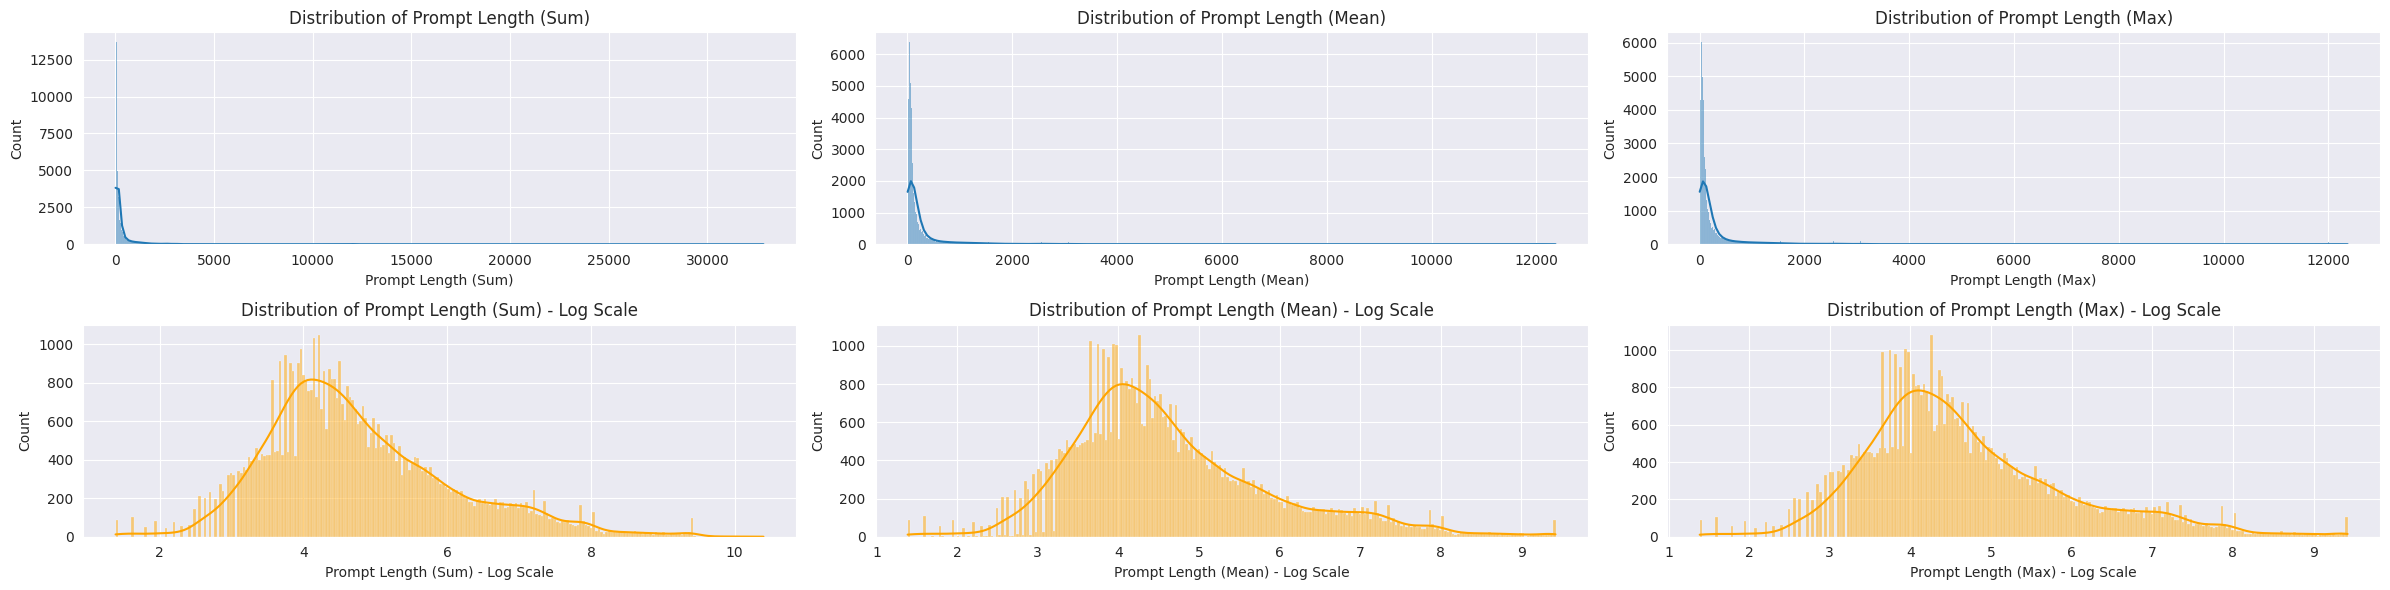

In [46]:
train = _add_len_stats(train, "prompt")

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 6))
for i, stats in enumerate(["sum", "mean", "max"]):
    # Original scale
    ax1 = axes[0][i]
    sns.histplot(train, x=f"p_len_{stats}", bins=1000, kde=True, ax=ax1)
    ax1.set_title(f"Distribution of Prompt Length ({stats.capitalize()})")
    ax1.set_xlabel(f"Prompt Length ({stats.capitalize()})")
    
    # Log scale
    ax2 = axes[1][i]
    sns.histplot(train, x=f"p_len_{stats}_log", bins=250, kde=True, color="orange", ax=ax2)
    ax2.set_title(f"Distribution of Prompt Length ({stats.capitalize()}) - Log Scale")
    ax2.set_xlabel(f"Prompt Length ({stats.capitalize()}) - Log Scale")
plt.tight_layout()

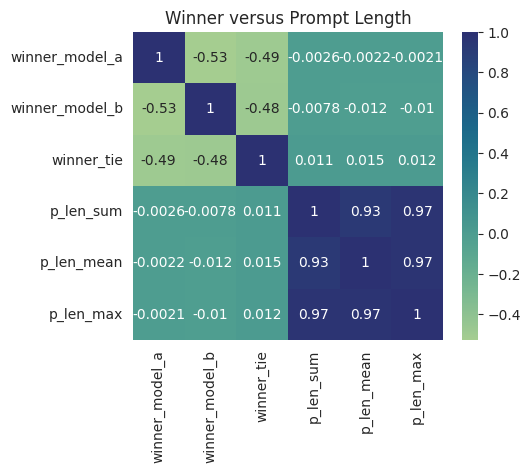

In [47]:
corr = train[TARGETS + ["p_len_sum", "p_len_mean", "p_len_max"]].corr()

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(corr, cmap="crest", annot=True, ax=ax)
ax.set_title("Winner versus Prompt Length")
plt.show()

#### Response Length
The **verbosity bias** in LLMs and humans (*i.e.,* LLMs and humans sometimes favor longer answers even though the quality isn't improved) has been under study for a period of time ([Saito et al.](https://arxiv.org/pdf/2310.10076)). Let's find out if this property is present in our dataset.

1. All distributions again show right-skewed characteristic, meaning theere are less samples with longer responses.
2. Distribution of model A and B look different in terms of mean and max lengths.
    * We conjecture **there exist outliers in model B responses**, because the length can be greater than 20000.

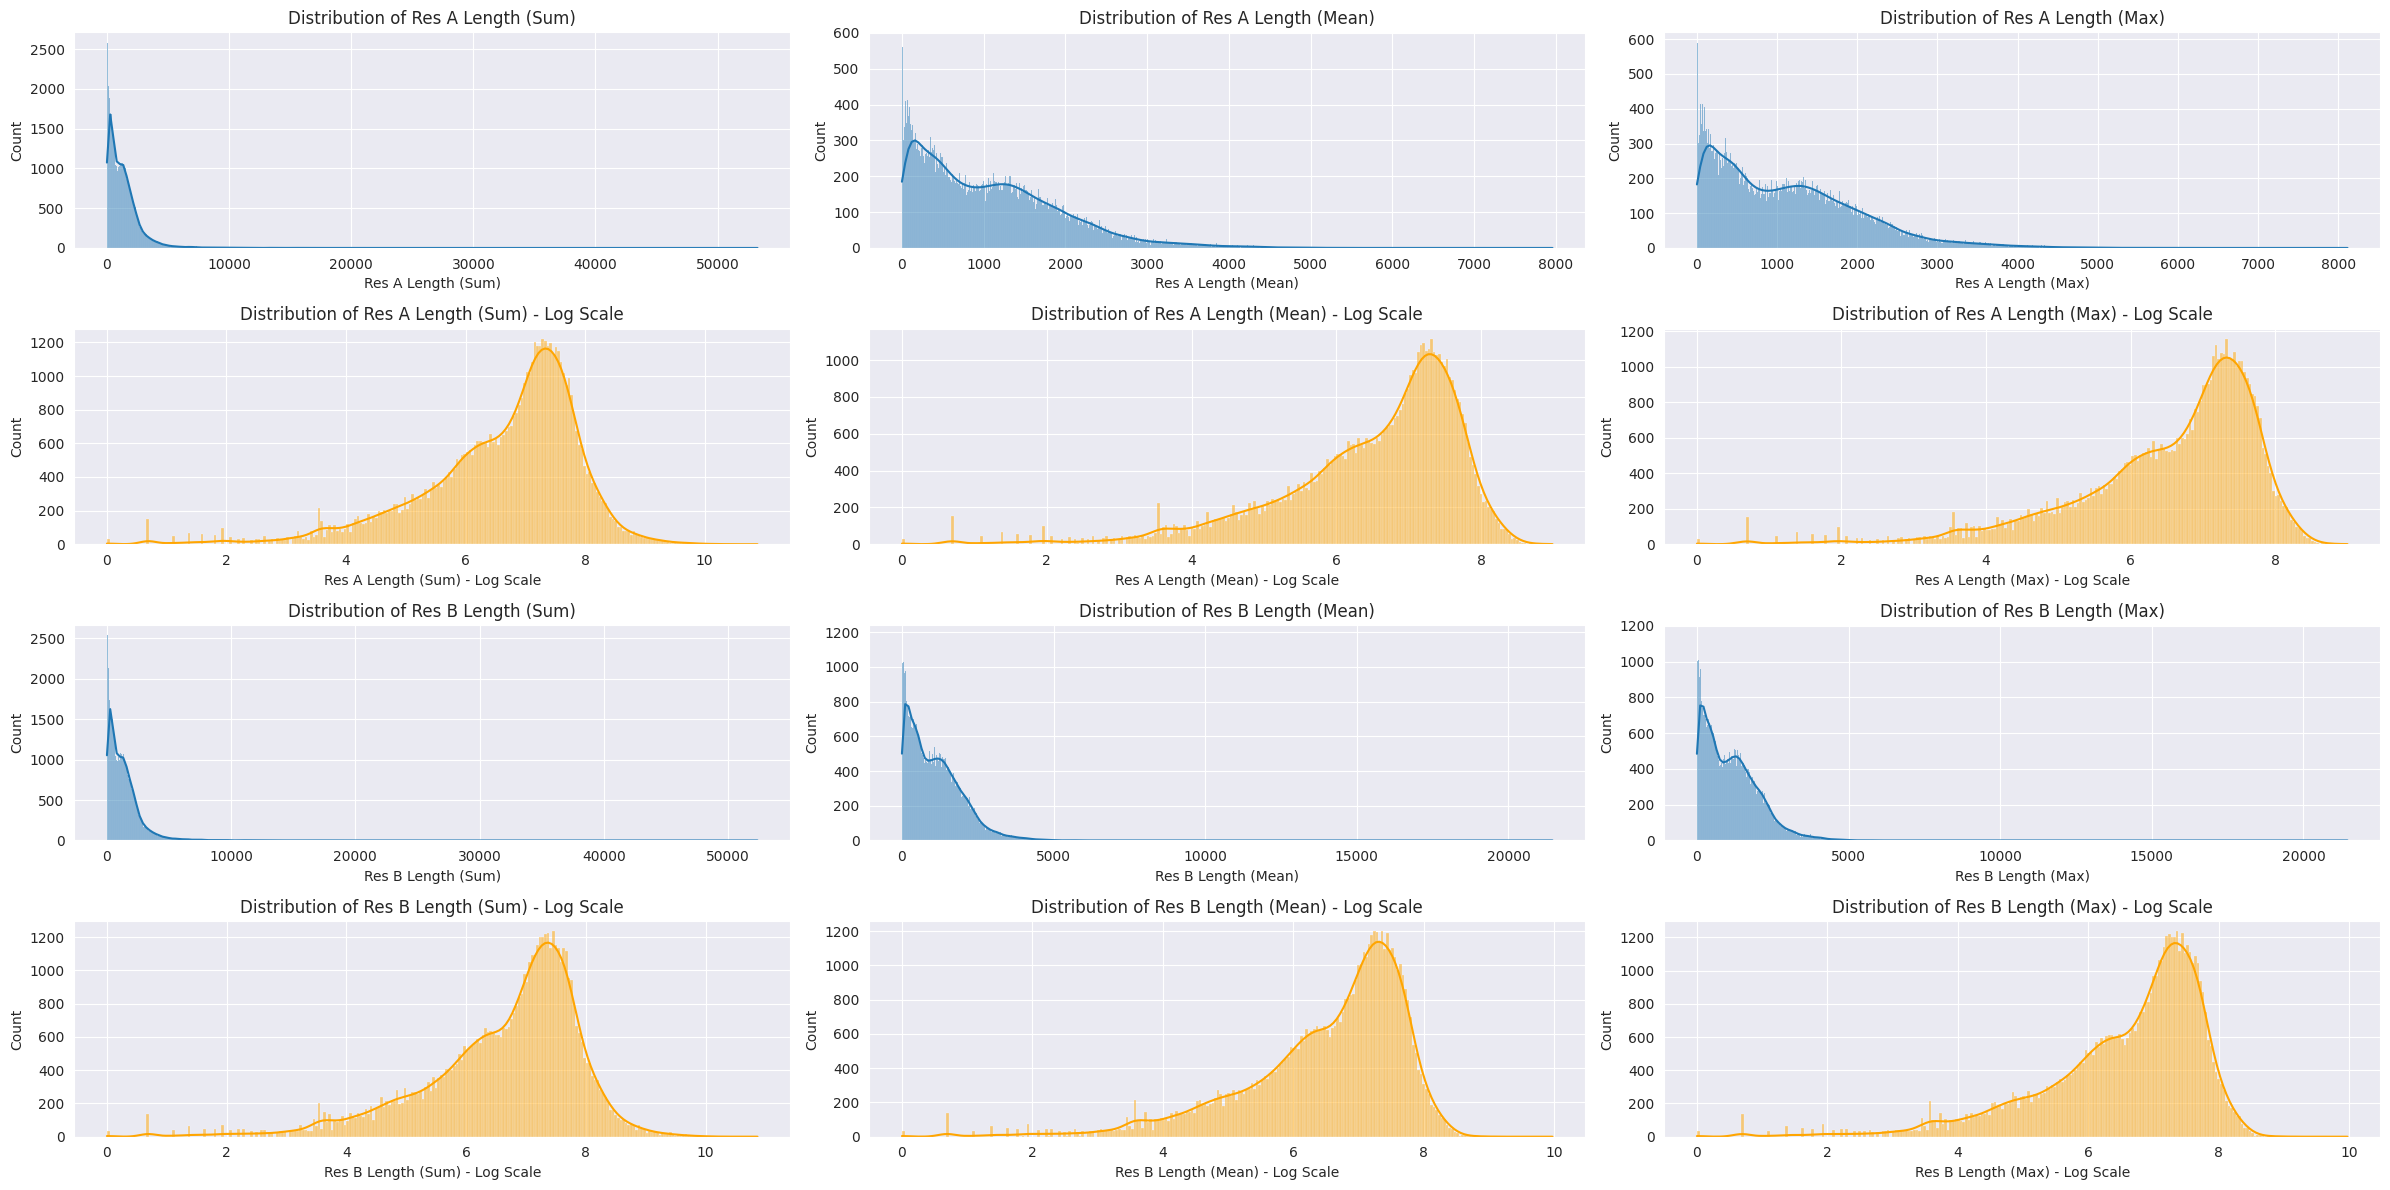

In [48]:
train = _add_len_stats(train, "response_a")
train = _add_len_stats(train, "response_b")

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(24, 12))
for i, stats in enumerate(["sum", "mean", "max"]):
    # Model A - original
    ax1 = axes[0][i]
    sns.histplot(train, x=f"res_a_len_{stats}", bins=1000, kde=True, ax=ax1)
    ax1.set_title(f"Distribution of Res A Length ({stats.capitalize()})")
    ax1.set_xlabel(f"Res A Length ({stats.capitalize()})")
    
    # Model A - log 
    ax2 = axes[1][i]
    sns.histplot(train, x=f"res_a_len_{stats}_log", bins=250, kde=True, color="orange", ax=ax2)
    ax2.set_title(f"Distribution of Res A Length ({stats.capitalize()}) - Log Scale")
    ax2.set_xlabel(f"Res A Length ({stats.capitalize()}) - Log Scale")
    
    # Model B - original
    ax3 = axes[2][i]
    sns.histplot(train, x=f"res_b_len_{stats}", bins=1000, kde=True, ax=ax3)
    ax3.set_title(f"Distribution of Res B Length ({stats.capitalize()})")
    ax3.set_xlabel(f"Res B Length ({stats.capitalize()})")
    
    # Model B - log 
    ax4 = axes[3][i]
    sns.histplot(train, x=f"res_b_len_{stats}_log", bins=250, kde=True, color="orange", ax=ax4)
    ax4.set_title(f"Distribution of Res B Length ({stats.capitalize()}) - Log Scale")
    ax4.set_xlabel(f"Res B Length ({stats.capitalize()}) - Log Scale")
plt.tight_layout()

By plotting model A and B at the same time, we can observe that their distrubtions are quite similar, except for tails in the mean and max lengths.

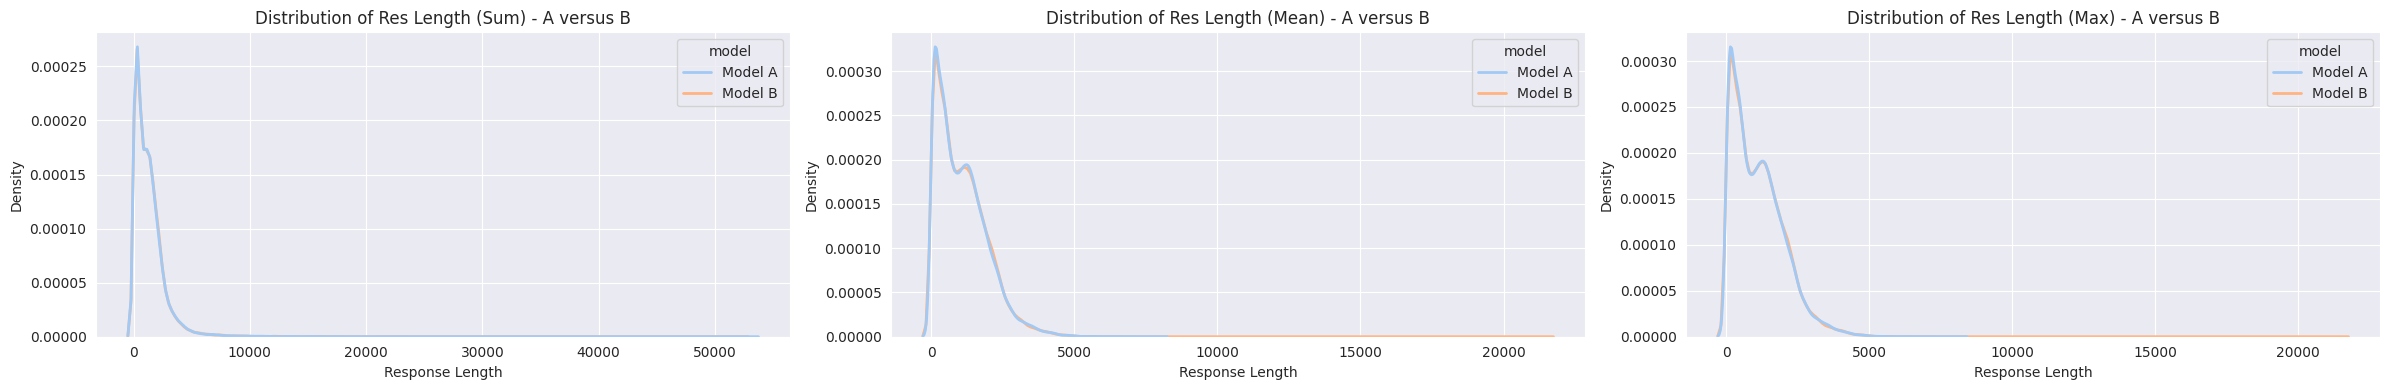

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 4))
for i, stats in enumerate(["sum", "mean", "max"]):
    tmp_a = (
        train
        .loc[:, [f"res_a_len_{stats}"]]
        .rename({f"res_a_len_{stats}": f"res_len_{stats}"}, axis=1)
        .assign(model=["Model A"] * len(train))
    )
    tmp_b = (
        train
        .loc[:, [f"res_b_len_{stats}"]]
        .rename({f"res_b_len_{stats}": f"res_len_{stats}"}, axis=1)
        .assign(model=["Model B"] * len(train))
    )
    tmp = pd.concat([tmp_a, tmp_b], ignore_index=True)
    
    ax = axes[i]
    sns.kdeplot(tmp, x=f"res_len_{stats}", hue="model", palette=colors, linewidth=2, ax=ax)
    ax.set_title(f"Distribution of Res Length ({stats.capitalize()}) - A versus B")
    ax.set_xlabel("Response Length")
plt.tight_layout()

#### Pair Length Relationship
After analyzing prompt and response length separately, let's combine them together! We take **the length sum of one conversation** as an example and explore three combinations,
1. Response length of model A versus model B
2. Prompt length versus response length of model A
3. Prompt length versus response length of model B

We can find that response lengths of two models are **strong positively correlated**, and we conjeture that this is because both model are exposed to the same prompt. As for the linear relationship between prompt length and response length, the correlation seems much weaker.

In [50]:
class _SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

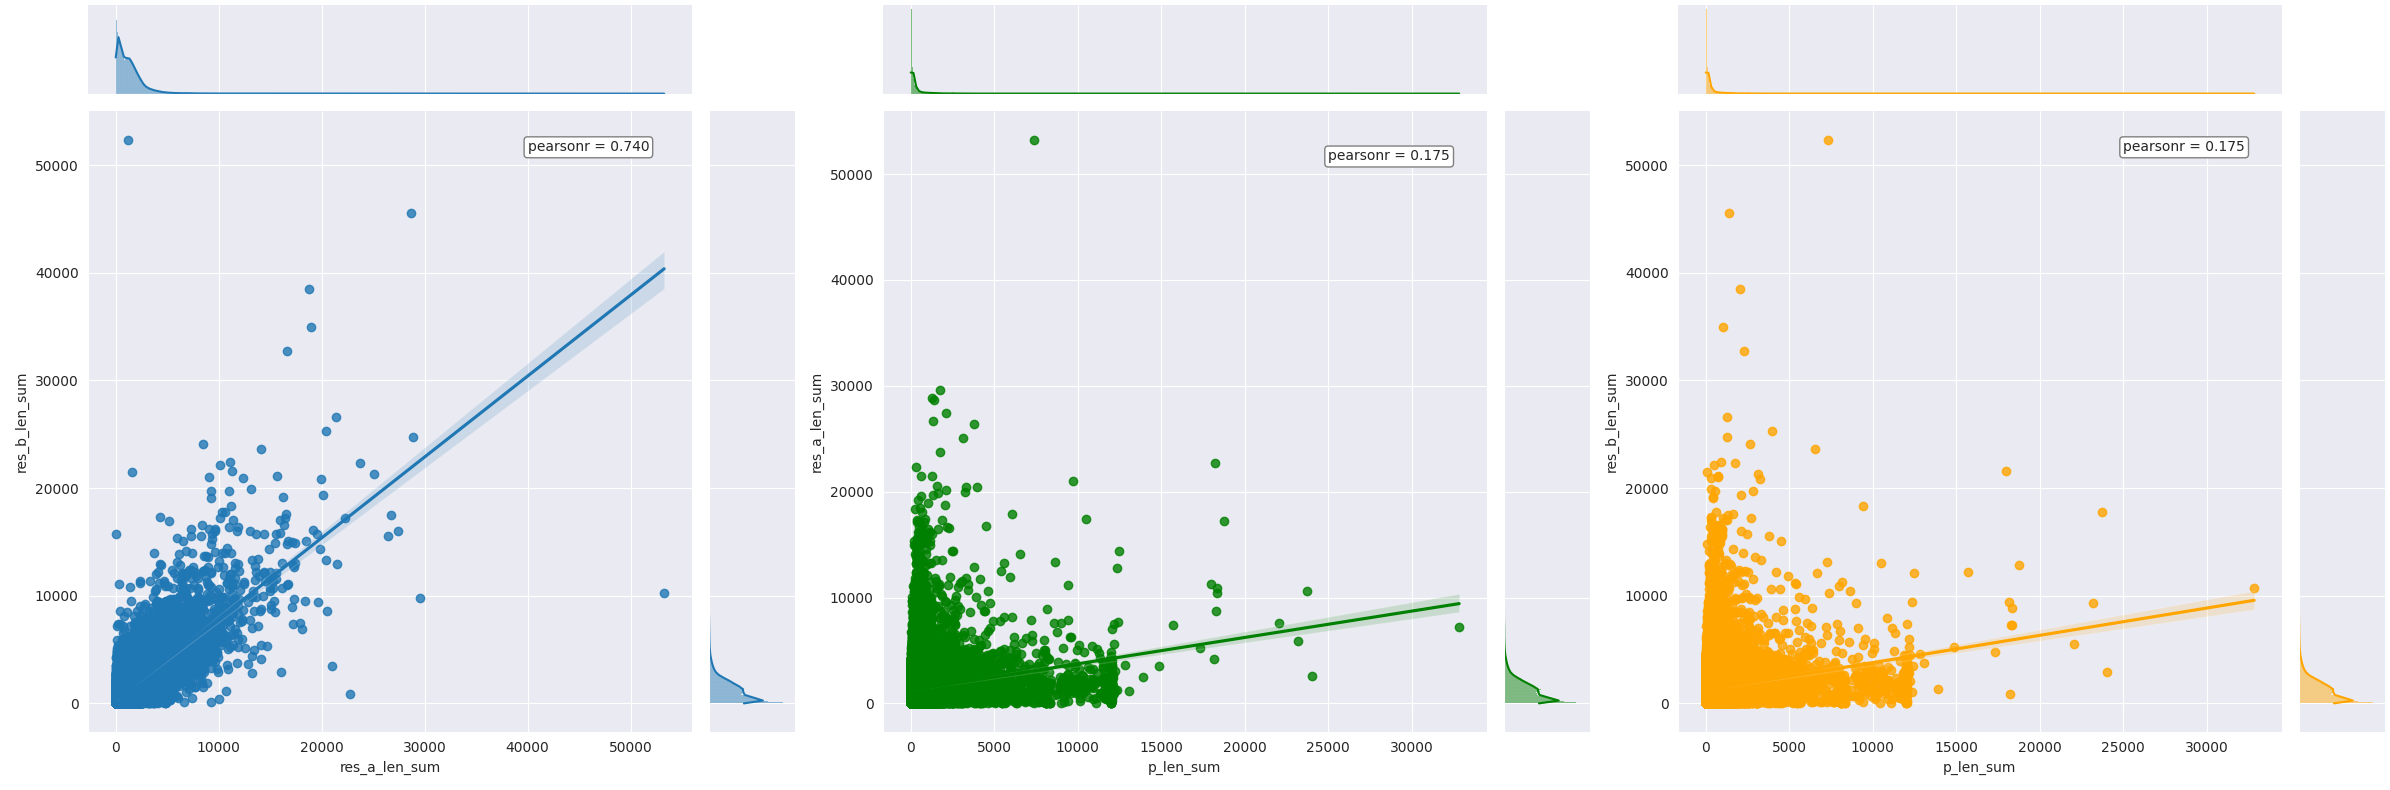

In [51]:
text_cfg = {
    "ha": "left",
    "va": "bottom",
    "bbox": {
        "boxstyle": "round",
        "pad": 0.25, 
        "facecolor": "white", 
        "edgecolor": "gray"
    }
}
r1, _ = scipy.stats.pearsonr(train["res_a_len_sum"], train["res_b_len_sum"])
r2, _ = scipy.stats.pearsonr(train["p_len_sum"], train["res_a_len_sum"])
r3, _ = scipy.stats.pearsonr(train["p_len_sum"], train["res_b_len_sum"])

fig = plt.figure(figsize=(24, 8))
gs = GridSpec(1, 3)
g0 = sns.jointplot(train, x="res_a_len_sum", y="res_b_len_sum", kind="reg")
g0.ax_joint.text(x=40000, y=51000, s=f"pearsonr = {r1:.3f}", **text_cfg)
g1 = sns.jointplot(train, x="p_len_sum", y="res_a_len_sum", color="g", kind="reg")
g1.ax_joint.text(x=25000, y=51000, s=f"pearsonr = {r2:.3f}", **text_cfg)
g2 = sns.jointplot(train, x="p_len_sum", y="res_b_len_sum", color="orange", kind="reg")
g2.ax_joint.text(x=25000, y=51000, s=f"pearsonr = {r3:.3f}", **text_cfg)
_SeabornFig2Grid(g0, fig, gs[0])
_SeabornFig2Grid(g1, fig, gs[1])
_SeabornFig2Grid(g2, fig, gs[2])
gs.tight_layout(fig)
plt.show()

#### Verbosity Bias or Not
Finally, it's time to focus on the effect of response length on judges. Let's check whether **verbosity bias** exists in our dataset or not! In this section, we use the mean response length of one conversation for illustration.<br>

To quantify which model outputs longer responses on average, we first take the length difference between model A and B. Just as discussed before, there are some outliers within model B responses. After length differences are clipped, the distribution becomes **symmetric**.<br>

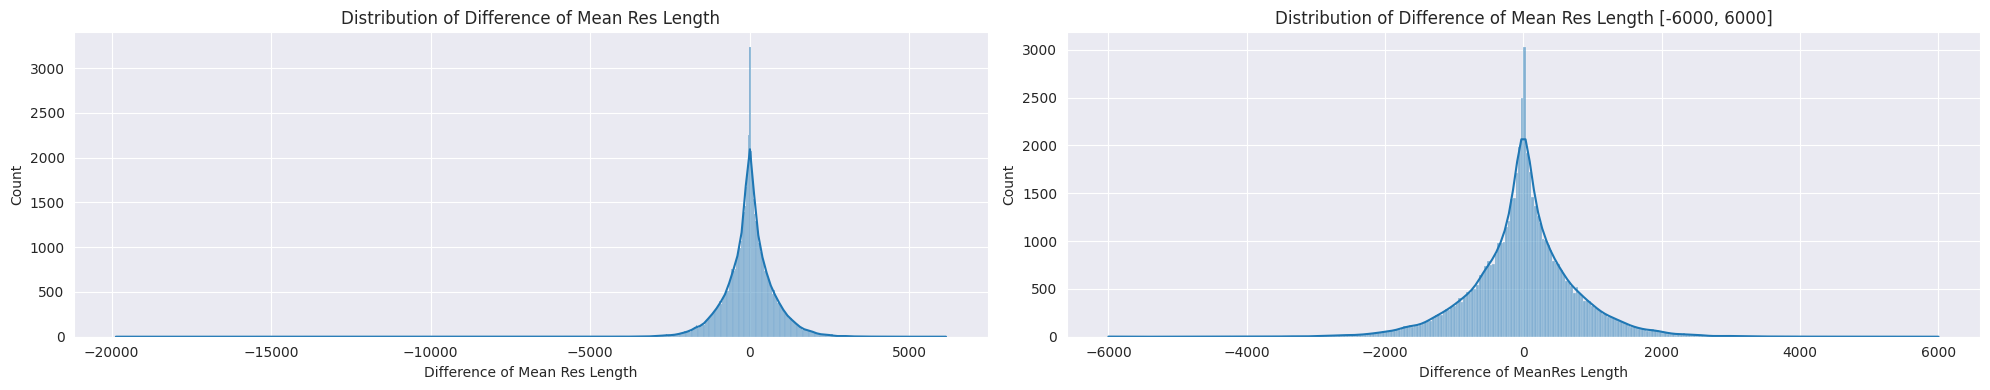

In [52]:
train["res_len_mean_diff"] = train["res_a_len_mean"] - train["res_b_len_mean"]
train["res_len_mean_diff_clip"] = train["res_len_mean_diff"].clip(-6000, 6000)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
sns.histplot(train, x="res_len_mean_diff", kde=True, ax=axes[0])
axes[0].set_title("Distribution of Difference of Mean Res Length")
axes[0].set_xlabel("Difference of Mean Res Length")
sns.histplot(train, x="res_len_mean_diff_clip", kde=True, ax=axes[1])
axes[1].set_title("Distribution of Difference of Mean Res Length [-6000, 6000]")
axes[1].set_xlabel("Difference of MeanRes Length")
plt.tight_layout()

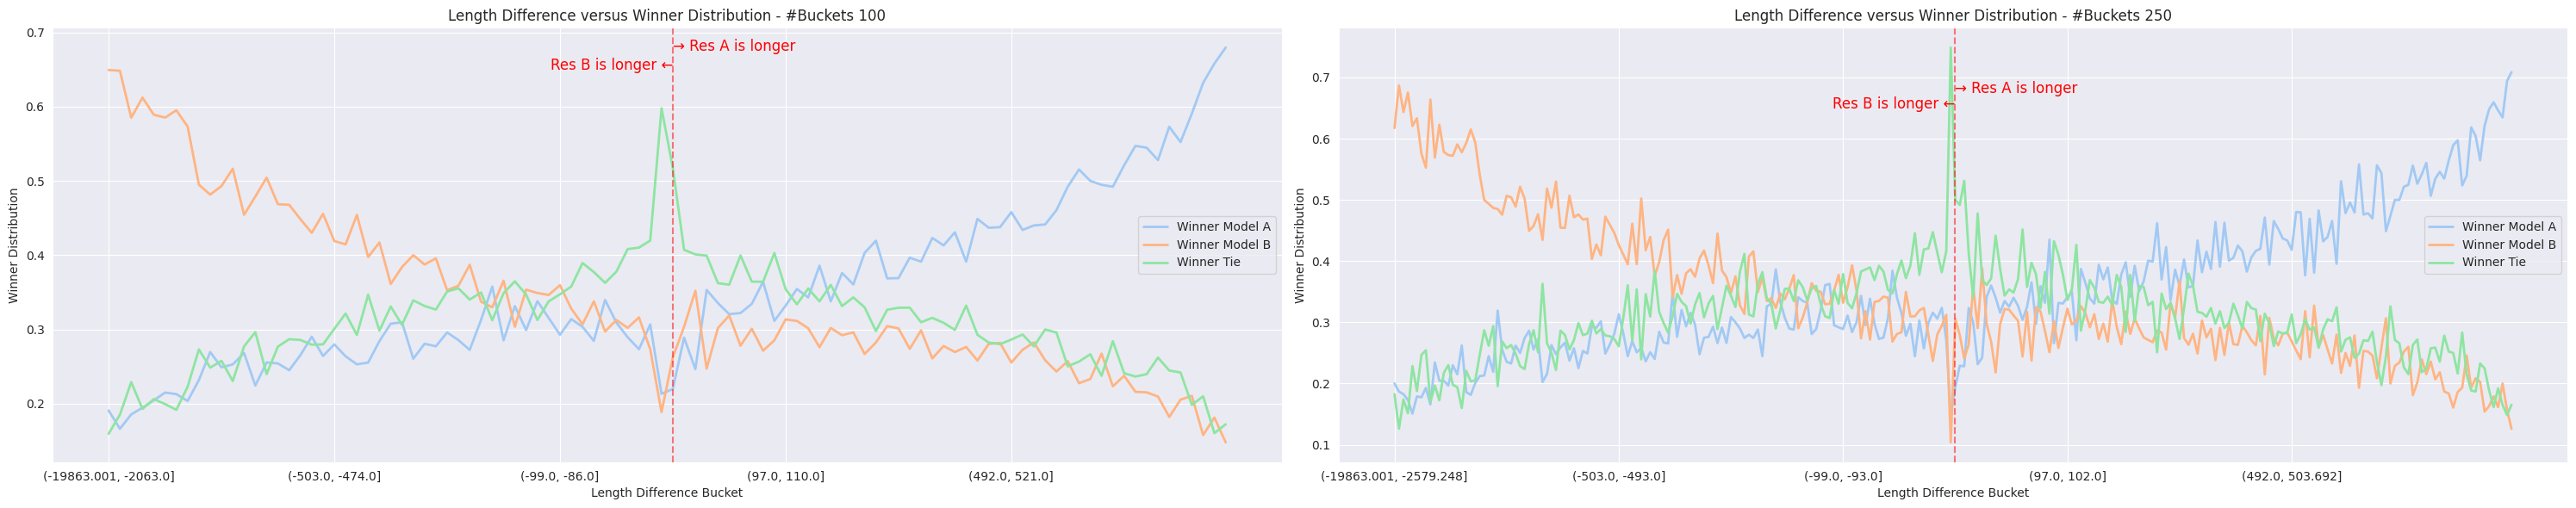

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 6))

for i, n_quantiles in enumerate([100, 250]):
    train[f"len_diff_bucket_{n_quantiles}"] = pd.qcut(train["res_len_mean_diff"], n_quantiles)
    bucket_win_rates = train.groupby(f"len_diff_bucket_{n_quantiles}")[TARGETS].mean()
    lbs = [str(s) for idx, s in enumerate(bucket_win_rates.index) if idx % int(n_quantiles / 5) == 0]

    ax = axes[i]
    for j, col in enumerate(TARGETS):
        ax.plot(
            bucket_win_rates[col].values,
            c=colors[j],
            label=col.replace("_", " ").title(),
            linewidth=2,
        )
    mid_pt = n_quantiles // 2
    ax.axvline(mid_pt, c="r", linestyle="--", alpha=0.5)
    ax.text(x=mid_pt, y=0.65, s="Res B is longer ←", c="r", ha="right", fontsize=12)
    ax.text(x=mid_pt, y=0.675, s="→ Res A is longer", c="r", ha="left", fontsize=12)
    ax.set_title(f"Length Difference versus Winner Distribution - #Buckets {n_quantiles}")
    ax.set_xlabel("Length Difference Bucket")
    ax.set_ylabel("Winner Distribution")
    ax.set_xticks(np.arange(0, len(bucket_win_rates), int(n_quantiles / len(lbs))), labels=lbs)
    ax.legend()
plt.tight_layout()

#### LLM-Specific Response Length
Though model identities won't be revealed in the test set, we're still interested in which models tend to output longer responses in general. Let's dive into this topic!<br>

Following illustrates the bar chart of LLM-specific mean response length. Also, the support (#appearances of each LLM) is marked with green triangle. Observations can be summarized as follows,
1. 4 models' responses are longer than 1500 on average.
2. `gpt-4-0125-preview` and `gpt-4-1106-preview` are models with the top-2 **longest** average response length.
3. `alpaca-13b` and `llama-13b` are models with the top-2 **shortest** average response length.

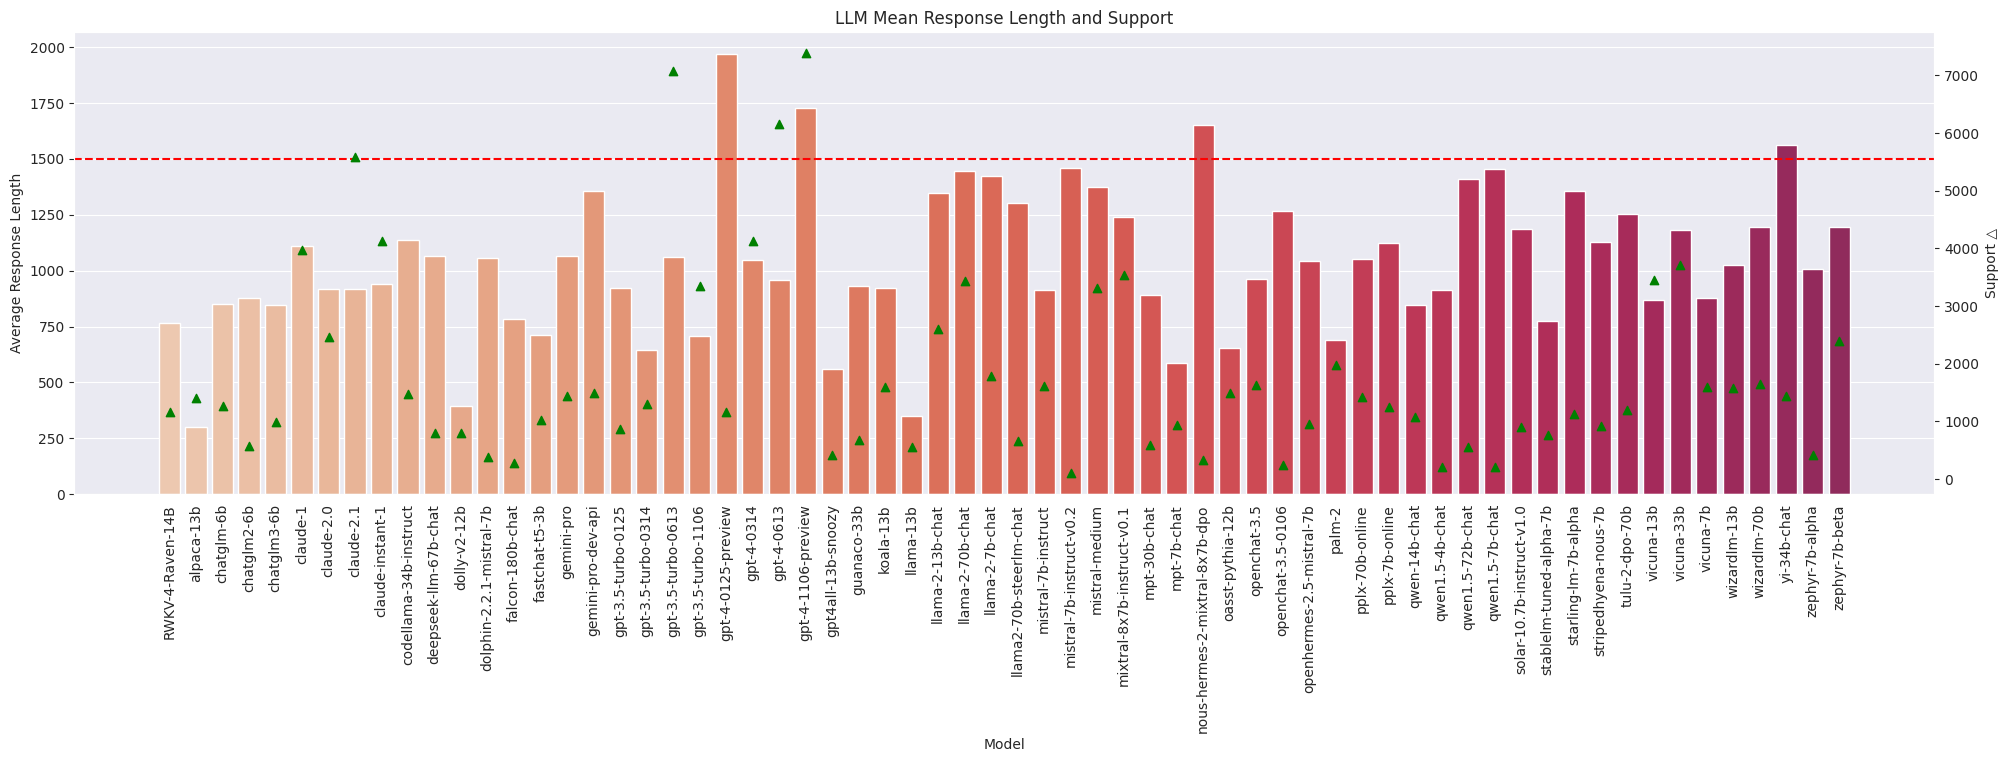

In [54]:
llm_res_len_a = (
    train[["model_a", "res_a_len_mean", "winner_model_a"]]
    .rename({
        "model_a": "model", 
        "res_a_len_mean": "res_len_mean",
        "winner_model_a": "win"
    }, axis=1)
)
llm_res_len_b = (
    train[["model_b", "res_b_len_mean", "winner_model_b"]]
    .rename({
        "model_b": "model", 
        "res_b_len_mean": "res_len_mean",
        "winner_model_b": "win"
    }, axis=1)
)
llm_res_len = pd.concat([llm_res_len_a, llm_res_len_b], ignore_index=True)
tmp = (
    llm_res_len
    .groupby("model")
    .agg({
        "res_len_mean": ["mean"],
        "model": ["count"],
        "win": ["mean"]
    })
    .droplevel(1, axis=1)
    .rename({"model": "support"}, axis=1)
)

fig, ax = plt.subplots(figsize=(24, 6))
sns.barplot(
    x=tmp.index, 
    y=tmp["res_len_mean"], 
    palette=[sns.color_palette("rocket_r", as_cmap=True)(v) for v in np.linspace(0.1, 0.6, 64)],
    ax=ax
)
ax.axhline(1500, c="r", linestyle="--", linewidth=1.5)
ax.set_title("LLM Mean Response Length and Support")
ax.set_xlabel("Model")
ax.set_ylabel("Average Response Length")
ax.tick_params(axis="x", rotation=90)

ax2 = ax.twinx()
ax2.scatter(np.arange(64), tmp["support"], c="g", marker="^")
ax2.set_ylabel("Support △")
ax2.grid(False)
fig.show()

Then, we explore the relationship between the response length and win rate on average. We can again find that they're positively correlated!

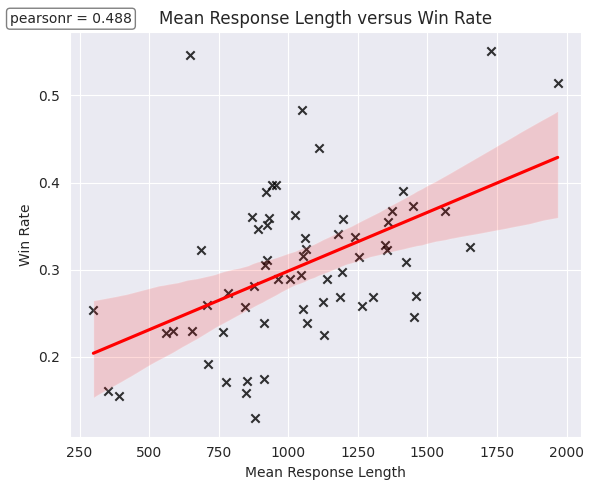

In [55]:
r, _ = scipy.stats.pearsonr(tmp["res_len_mean"], tmp["win"])

fig, ax = plt.subplots(figsize=(6, 5))
sns.regplot(
    data=tmp, x="res_len_mean", y="win",
    marker="x", color="black", line_kws=dict(color="r"), ax=ax
)
ax.text(x=0, y=0.58, s=f"pearsonr = {r:.3f}", **text_cfg)
ax.set_title("Mean Response Length versus Win Rate")
ax.set_xlabel("Mean Response Length")
ax.set_ylabel("Win Rate")
plt.tight_layout()

<a id="naive"></a>
## 3. Naive Baselines
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

In this section, we implement some naive baselines to get familiar with the evaluation metric and see how well baselines can perform.

|  Baseline   | CV  |  LB |
|  ----  | ----  | ----  |
| All 1/3  | 1.0986 | 1.098  |
| Mean Prediction  | 1.0972 | 1.098  |
| LLM-Specific Mean Prediction  | 1.1000 | X |
| Length Difference Bucket Mean Prediction  | 1.0511 | ? |

<a id="1_3"></a>
### *All 1/3*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Predict with `[winner_model_a, winner_model_b, winner_tie] = [1/3, 1/3, 1/3]`.

In [56]:
y_true = train[TARGETS]
y_pred = np.full(y_true.shape, fill_value=1/3)
print(f">>> All 1/3 <<<")
print(f"Prediction global mean | {np.mean(y_pred, axis=0)}")
print(f"Log loss | {log_loss(y_true, y_pred):.4f}")

>>> All 1/3 <<<
Prediction global mean | [0.33333333 0.33333333 0.33333333]
Log loss | 1.0986


<a id="mean"></a>
### *Mean Prediction*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Predict with the global mean.

In [57]:
y_pred = train[TARGETS].mean().values.reshape((1, -1))
y_pred = np.repeat(y_pred, len(y_true), axis=0)

print(f">>> Mean Prediction <<<")
print(f"Prediction global mean | {np.mean(y_pred, axis=0)}")
print(f"Log loss | {log_loss(y_true, y_pred):.4f}")

>>> Mean Prediction <<<
Prediction global mean | [0.34910388 0.34190012 0.308996  ]
Log loss | 1.0972


<a id="llm_mean"></a>
### *LLM-Specific Mean Prediction*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

In this baseline, we derive the group mean of each LLM as prediction. If the sum of probabilities of two models is greater than 1, we fill predictions with `1/3`.

In [58]:
y_pred = train[["model_a", "model_b"] + TARGETS]
winner_a_mean = train[["model_a", "winner_model_a"]].groupby("model_a").mean().squeeze()
winner_b_mean = train[["model_b", "winner_model_b"]].groupby("model_b").mean().squeeze()
y_pred["winner_model_a"] = y_pred["model_a"].map(winner_a_mean)
y_pred["winner_model_b"] = y_pred["model_b"].map(winner_b_mean)
y_pred["winner_tie"] = 1 - (y_pred["winner_model_a"] + y_pred["winner_model_b"])
tie_mask = y_pred["winner_tie"] < 0
y_pred.loc[tie_mask, TARGETS] = 1 / 3

print(f">>> Mean Prediction <<<")
print(f"Prediction global mean | {np.mean(y_pred[TARGETS].values, axis=0)}")
print(f"Log loss | {log_loss(y_true, y_pred[TARGETS]):.4f}")

>>> Mean Prediction <<<
Prediction global mean | [0.34688426 0.33990187 0.31321387]
Log loss | 1.1000


<a id="len_diff"></a>
### *Length Difference Bucket Mean Prediction*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Following the response length bucket analysis, we use the group mean of each length difference bucket as prediction. Also, we try different granularities to bin length difference values. We can see that performance slightly improves when the number of quantiles increases.

In [59]:
def _get_len_diff_bucket_pred(n_quantiles: int) -> pd.DataFrame:
    y_pred = train[["res_len_mean_diff"] + TARGETS]
    y_pred[f"len_diff_bucket_{n_quantiles}"] = pd.qcut(train["res_len_mean_diff"], n_quantiles)
    bucket_win_rates = y_pred.groupby(f"len_diff_bucket_{n_quantiles}")[TARGETS].mean()
    for col in TARGETS:
        y_pred[col] = y_pred[f"len_diff_bucket_{n_quantiles}"].map(bucket_win_rates[col])
        
    return y_pred

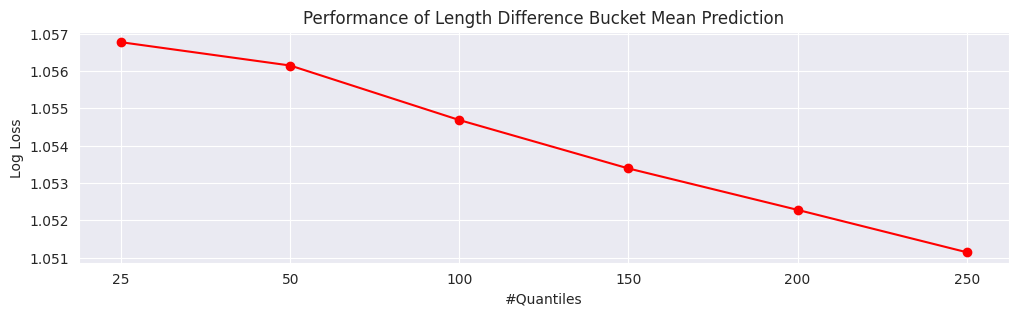

In [60]:
prfs = {}
for n_quantiles in [25, 50, 100, 150, 200, 250]:
    y_pred = _get_len_diff_bucket_pred(n_quantiles)
    prfs[n_quantiles] = log_loss(y_true, y_pred[TARGETS])

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(list(prfs.values()), "ro-")
ax.set_title("Performance of Length Difference Bucket Mean Prediction")
ax.set_xlabel("#Quantiles")
ax.set_ylabel("Log Loss")
ax.set_xticks(np.arange(6), labels=list(prfs.keys()))
plt.show()

<a id="ml"></a>
## 4. ML Baselines
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

After comparing naive baselines, let's see if traditional ML models with simple features can beat them in this section.

<a id="fe"></a>
### *Feature Engineering*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

First, we'll generate some more features mainly based on EDA observations.

In [61]:
def _len(string: str) -> int:
    """Return the length of the string."""
    if string is None:
        return 0
    return len(string)

In [62]:
# Missing prompt ratio
train["n_miss_prompts"] = train["n_na_prompts"] + train["n_empty_prompts"]
train["n_eff_prompts"] = train["n_prompts"] - train["n_miss_prompts"]

train["na_prompt_ratio"] = train["n_na_prompts"] / train["n_prompts"]
train["empty_prompt_ratio"] = train["n_empty_prompts"] / train["n_prompts"]
train["miss_prompt_ratio"] = train["n_miss_prompts"] / train["n_prompts"]

# Missing response ratio
train["na_res_a_ratio"] = train["n_na_res_a"] / train["n_res_a"]
train["empty_res_a_ratio"] = train["n_empty_res_a"] / train["n_res_a"]
train["miss_res_a_ratio"] = train["n_miss_res_a"] / train["n_res_a"]
train["na_res_b_ratio"] = train["n_na_res_b"] / train["n_res_b"]
train["empty_res_b_ratio"] = train["n_empty_res_b"] / train["n_res_b"]
train["miss_res_b_ratio"] = train["n_miss_res_b"] / train["n_res_b"]

# Length features
for col, col_prefix in zip(["prompt", "response_a", "response_b"], ["p_len", "res_a_len", "res_b_len"]):
    train[f"{col_prefix}_med"] = train[col].apply(lambda x: np.median(list(_len(s) for s in x)))
    train[f"{col_prefix}_std"] = train[col].apply(lambda x: np.std(list(_len(s) for s in x)))
train["p_len_eff_mean"] = train["p_len_sum"] / train["n_eff_prompts"]
train["res_a_len_eff_mean"] = train["res_a_len_sum"] / train["n_eff_res_a"]
train["res_b_len_eff_mean"] = train["res_b_len_sum"] / train["n_eff_res_b"]

for stats in ["sum", "mean", "max", "med", "eff_mean"]:
    train[f"p_a_{stats}_diff"] = train[f"p_len_{stats}"] - train[f"res_a_len_{stats}"]
    train[f"p_b_{stats}_diff"] = train[f"p_len_{stats}"] - train[f"res_b_len_{stats}"]
    train[f"a_b_{stats}_diff"] = train[f"res_a_len_{stats}"] - train[f"res_b_len_{stats}"]
    
train.head(2)

model_a     model_b  \
0  gpt-4-1106-preview  gpt-4-0613   
1           koala-13b  gpt-4-0613   

                                              prompt  \
0  [Is it morally right to try to have a certain ...   
1  [What is the difference between marriage licen...   

                                          response_a  \
0  [The question of whether it is morally right t...   
1  [A marriage license is a legal document that a...   

                                          response_b  winner_model_a  \
0  [As an AI, I don't have personal beliefs or op...               1   
1  [A marriage license and a marriage certificate...               0   

   winner_model_b  winner_tie  n_prompts  n_res_a  n_res_b  n_na_prompts  \
0               0           0          2        2        2             0   
1               1           0          3        3        3             0   

   n_empty_prompts  n_na_res_a  n_empty_res_a  n_na_res_b  n_empty_res_b  \
0                0           0              0           0              0   
1                0           0              0           0              0   

   n_miss_res_a  n_miss_res_b  n_eff_res_a  n_eff_res_b  p_len_sum  \
0             0             0            2            2        158   
1             0             0            3            3        190   

   p_len_mean  p_len_max  p_len_sum_log  p_len_mean_log  p_len_max_log  \
0   79.000000         91       5.068904        4.382027       4.521789   
1   63.333333         73       5.252273        4.164078       4.304065   

   res_a_len_sum  res_a_len_mean  res_a_len_max  res_a_len_sum_log  \
0           4460     2230.000000           2922           8.403128   
1           3094     1031.333333           1331           8.037543   

   res_a_len_mean_log  res_a_len_max_log  res_b_len_sum  res_b_len_mean  \
0            7.710205           7.980366           1199      599.500000   
1            6.939577           7.194437           3590     1196.666667   

   res_b_len_max  res_b_len_sum_log  res_b_len_mean_log  res_b_len_max_log  \
0            730           7.090077            6.397763           6.594413   
1           1508           8.186186            7.088130           7.319202   

   res_len_mean_diff  res_len_mean_diff_clip len_diff_bucket_100  \
0        1630.500000             1630.500000    (1487.0, 1697.0]   
1        -165.333333             -165.333333    (-170.0, -155.0]   

  len_diff_bucket_250  n_miss_prompts  n_eff_prompts  na_prompt_ratio  \
0  (1605.744, 1697.0]               0              2              0.0   
1    (-167.0, -161.0]               0              3              0.0   

   empty_prompt_ratio  miss_prompt_ratio  na_res_a_ratio  empty_res_a_ratio  \
0                 0.0                0.0             0.0                0.0   
1                 0.0                0.0             0.0                0.0   

   miss_res_a_ratio  na_res_b_ratio  empty_res_b_ratio  miss_res_b_ratio  \
0               0.0             0.0                0.0               0.0   
1               0.0             0.0                0.0               0.0   

   p_len_med  p_len_std  res_a_len_med  res_a_len_std  res_b_len_med  \
0       79.0  12.000000         2230.0     692.000000          599.5   
1       62.0   7.408704         1080.0     266.773729         1278.0   

   res_b_len_std  p_len_eff_mean  res_a_len_eff_mean  res_b_len_eff_mean  \
0     130.500000       79.000000         2230.000000          599.500000   
1     293.104456       63.333333         1031.333333         1196.666667   

   p_a_sum_diff  p_b_sum_diff  a_b_sum_diff  p_a_mean_diff  p_b_mean_diff  \
0         -4302         -1041          3261        -2151.0    -520.500000   
1         -2904         -3400          -496         -968.0   -1133.333333   

   a_b_mean_diff  p_a_max_diff  p_b_max_diff  a_b_max_diff  p_a_med_diff  \
0    1630.500000         -2831          -639          2192       -2151.0   
1    -165.333333         -1258         -1435          -177   

<a id="dt"></a>
### *One-Feature Decision Tree*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Our best naive baseline, length difference bucket mean prediction with 250 quantiles, can yield a log loss of 1.0511. We decide to start from a decision tree with only a single feature, `a_b_eff_mean_diff`, which is similar to the one used in the naive baseline.<br>

As can be seen, the performance is slightly worse but quite close to what we obtain in the last naive baseline!

In [63]:
def _run_cv(
    X: pd.DataFrame,
    y: pd.Series,
    cv: BaseCrossValidator,
    models: List[BaseEstimator],
) -> List[float]:
    """Run cross-validation.
    
    Args:
        X: The feature matrix.
        y: The ground truth.
        cv: The cross validator.
        models: The unfitted estimators.
    
    Returns:
        scores: OOF scores.
    """
    scores = []
    for fold, (tr_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"## Fold {fold} ##")
        
        # Split training and validation sets
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        models[fold].fit(X_tr, y_tr)

        y_tr_pred = models[fold].predict_proba(X_tr)
        y_val_pred = models[fold].predict_proba(X_val)
        tr_score, val_score = log_loss(y_tr, y_tr_pred), log_loss(y_val, y_val_pred)
        print(f"Log loss | Train {tr_score:.4f} | Val {val_score:.4f}")
        scores.append(val_score)

    return scores

In [64]:
# Prepare data
train["y"] = np.where(train[TARGETS])[1]
X, y = train[["a_b_eff_mean_diff"]].fillna(0), train["y"]

# Build cross validator
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Build models
model_cfg = {
    "criterion": "log_loss",
    "max_depth": 4,
    "min_samples_leaf": 1500,
    "random_state": 42,
}
models = [DecisionTreeClassifier(**model_cfg) for _  in range(4)]

# Run local cross validation
scores = _run_cv(X, y, skf, models)
print(f"\n>>> Performance Report <<<")
print(f"OOF log loss | {np.mean(scores):.4f} +- {np.std(scores):.4f}")

## Fold 0 ##
Log loss | Train 1.0569 | Val 1.0574
## Fold 1 ##
Log loss | Train 1.0567 | Val 1.0601
## Fold 2 ##
Log loss | Train 1.0557 | Val 1.0629
## Fold 3 ##
Log loss | Train 1.0583 | Val 1.0549

>>> Performance Report <<<
OOF log loss | 1.0588 +- 0.0030


To compare with the last naive baseline, we plot each decision tree to understand how samples are splitted automatically.<br>

Interesting! The decision tree itself learns the relationship between length differences and winners. It's obvious that winner model A is on the right side (*i.e.,* longer response A), tie in the middle, and B on the left side (*i.e.,* longer response B).

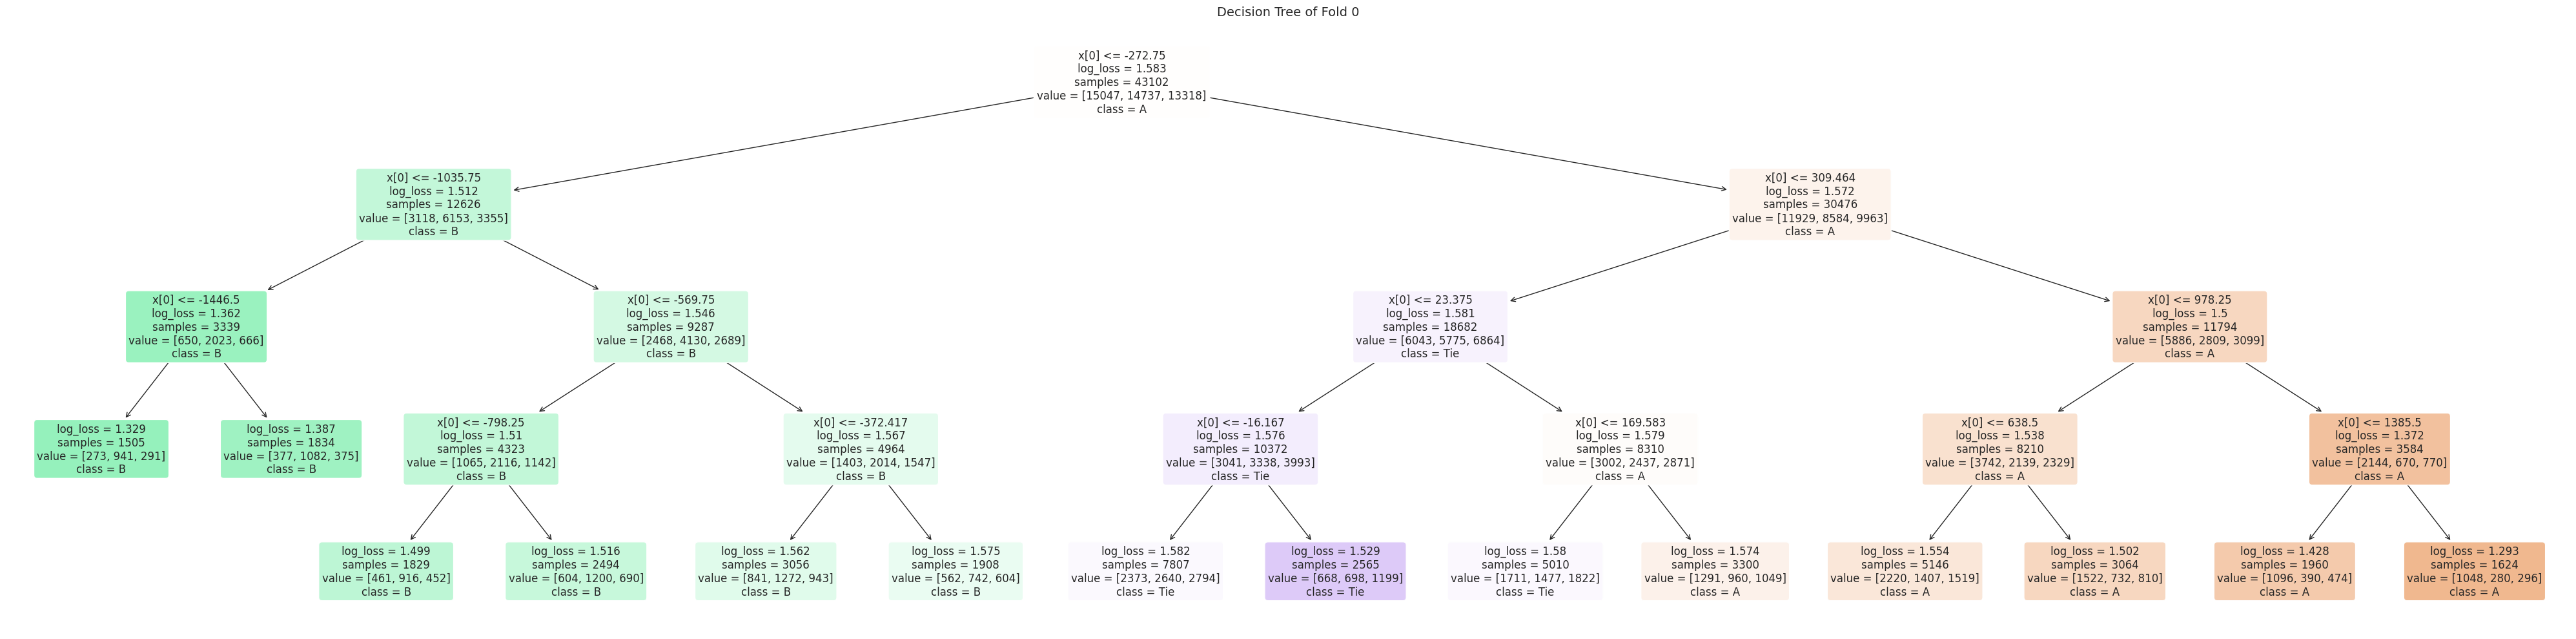

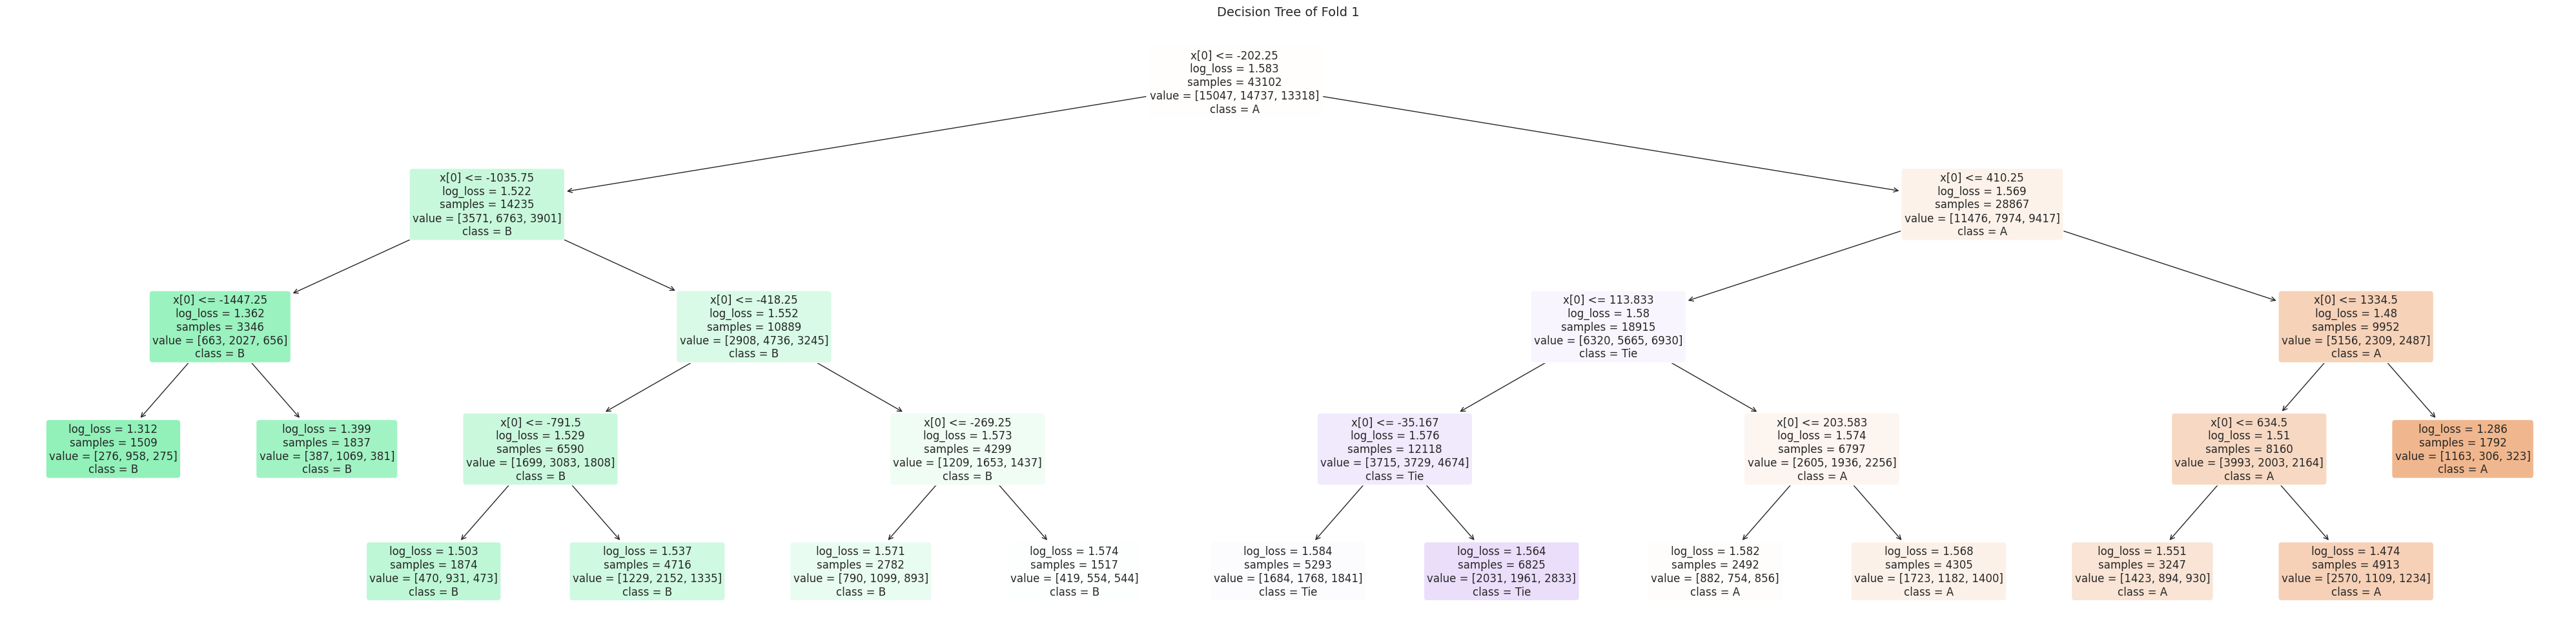

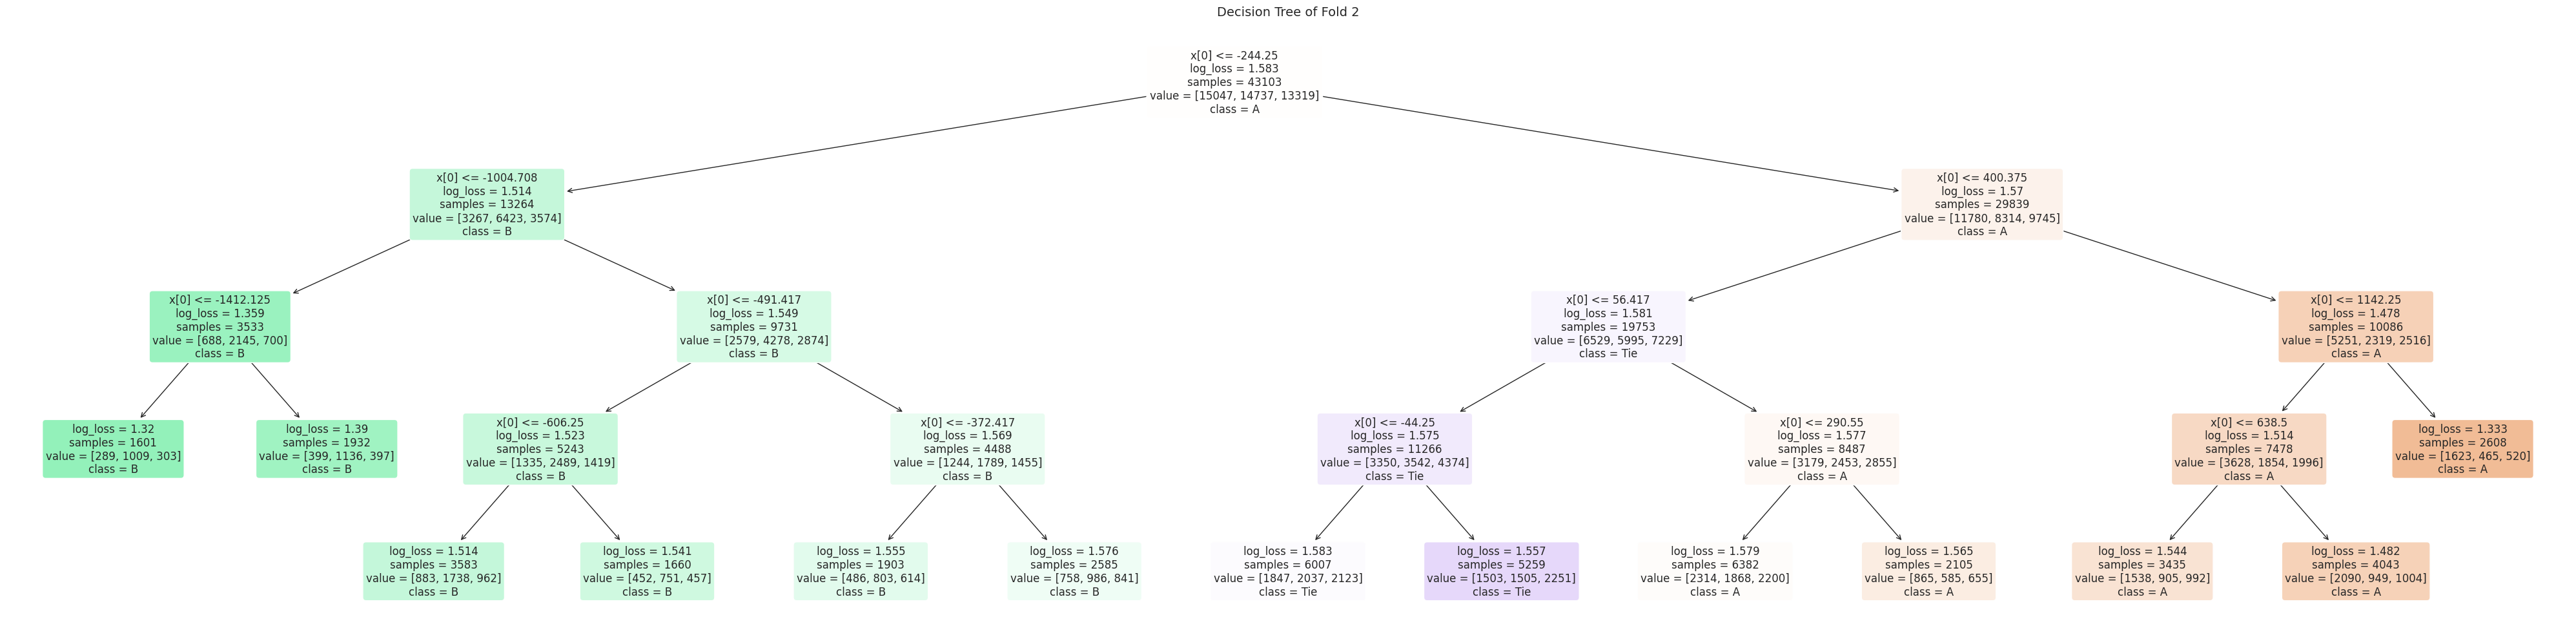

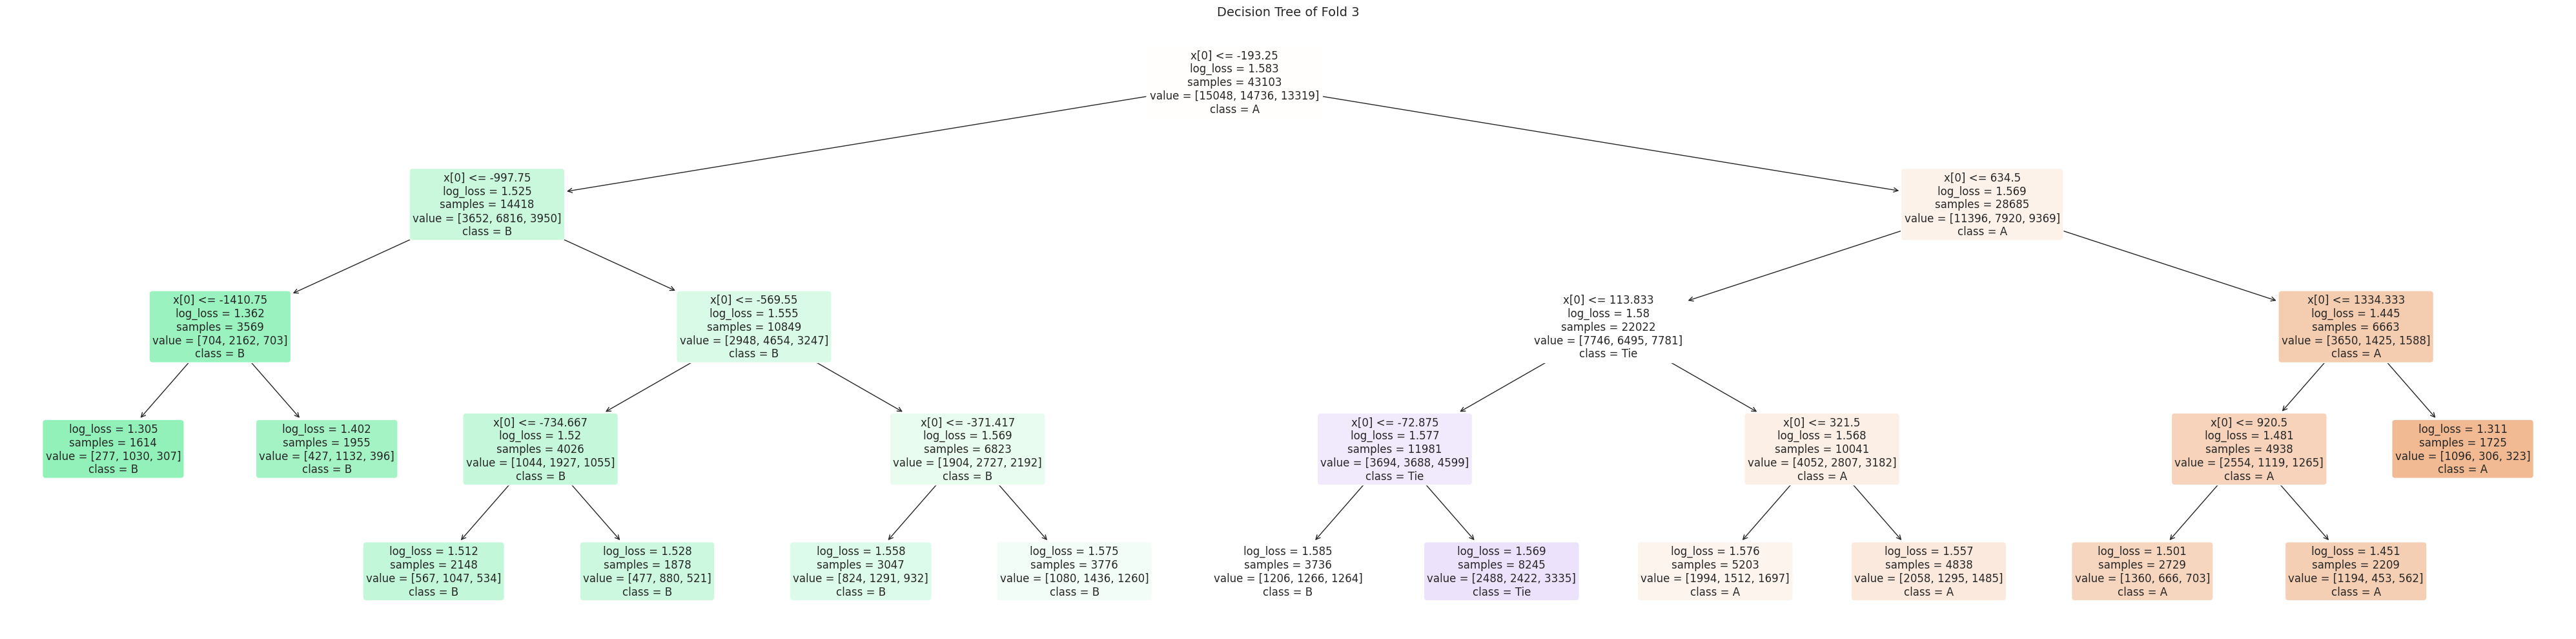

In [65]:
for fold, model in enumerate(models):
    fig, ax = plt.subplots(figsize=(40, 10))
    plot_tree(model, class_names=["A", "B", "Tie"], filled=True, rounded=True, fontsize=12, ax=ax)
    ax.set_title(f"Decision Tree of Fold {fold}", fontsize=14)
    plt.tight_layout()

<a id="more_feat"></a>
### *More Features*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Using only single feature might lead to underfitting, so we'll add some more features into our decision tree baseline.<br>

In [66]:
feats_to_skip = (
    ["model_a", "model_b", "prompt", "response_a", "response_b"]
    + ["n_res_a", "n_res_b"]
    + [c for c in train.columns if "log" in c]
    + ["res_len_mean_diff", "res_len_mean_diff_clip", "len_diff_bucket_100", "len_diff_bucket_250"]
    + TARGETS
    + ["y"]
)
feats = [col for col in train.columns if col not in feats_to_skip]
print(f"{len(feats)} features are selected!")

55 features are selected!


Though the performance improves a little bit, the decision tree can't beat our last naive baseline. Also, it's worth to note that features related to the response length difference are still important. 

In [67]:
X, y = train[feats].fillna(0), train["y"]
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
model_cfg = {
    "criterion": "log_loss",
    "max_depth": 6,
    "min_samples_leaf": 1500,
    "max_features": 0.7,
    "random_state": 42,
}
models = [DecisionTreeClassifier(**model_cfg) for _  in range(4)]

# Run local cross validation
scores = _run_cv(X, y, skf, models)
print(f"\n>>> Performance Report <<<")
print(f"OOF log loss | {np.mean(scores):.4f} +- {np.std(scores):.4f}")

## Fold 0 ##
Log loss | Train 1.0535 | Val 1.0547
## Fold 1 ##
Log loss | Train 1.0518 | Val 1.0581
## Fold 2 ##
Log loss | Train 1.0518 | Val 1.0599
## Fold 3 ##
Log loss | Train 1.0538 | Val 1.0520

>>> Performance Report <<<
OOF log loss | 1.0561 +- 0.0031


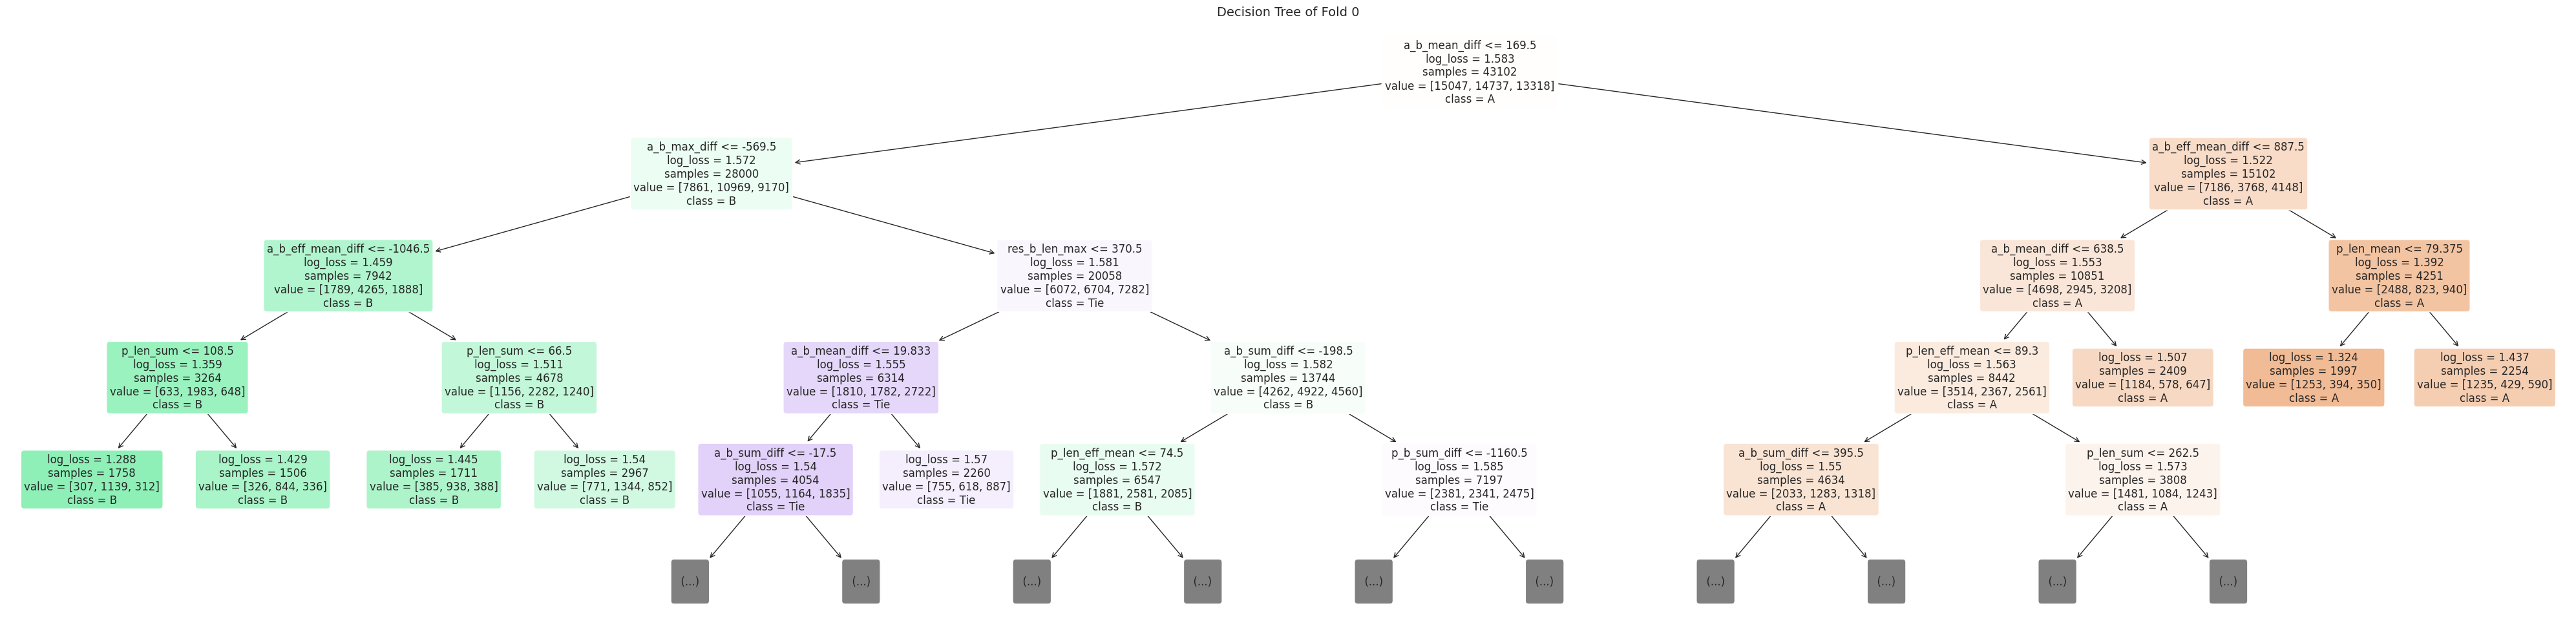

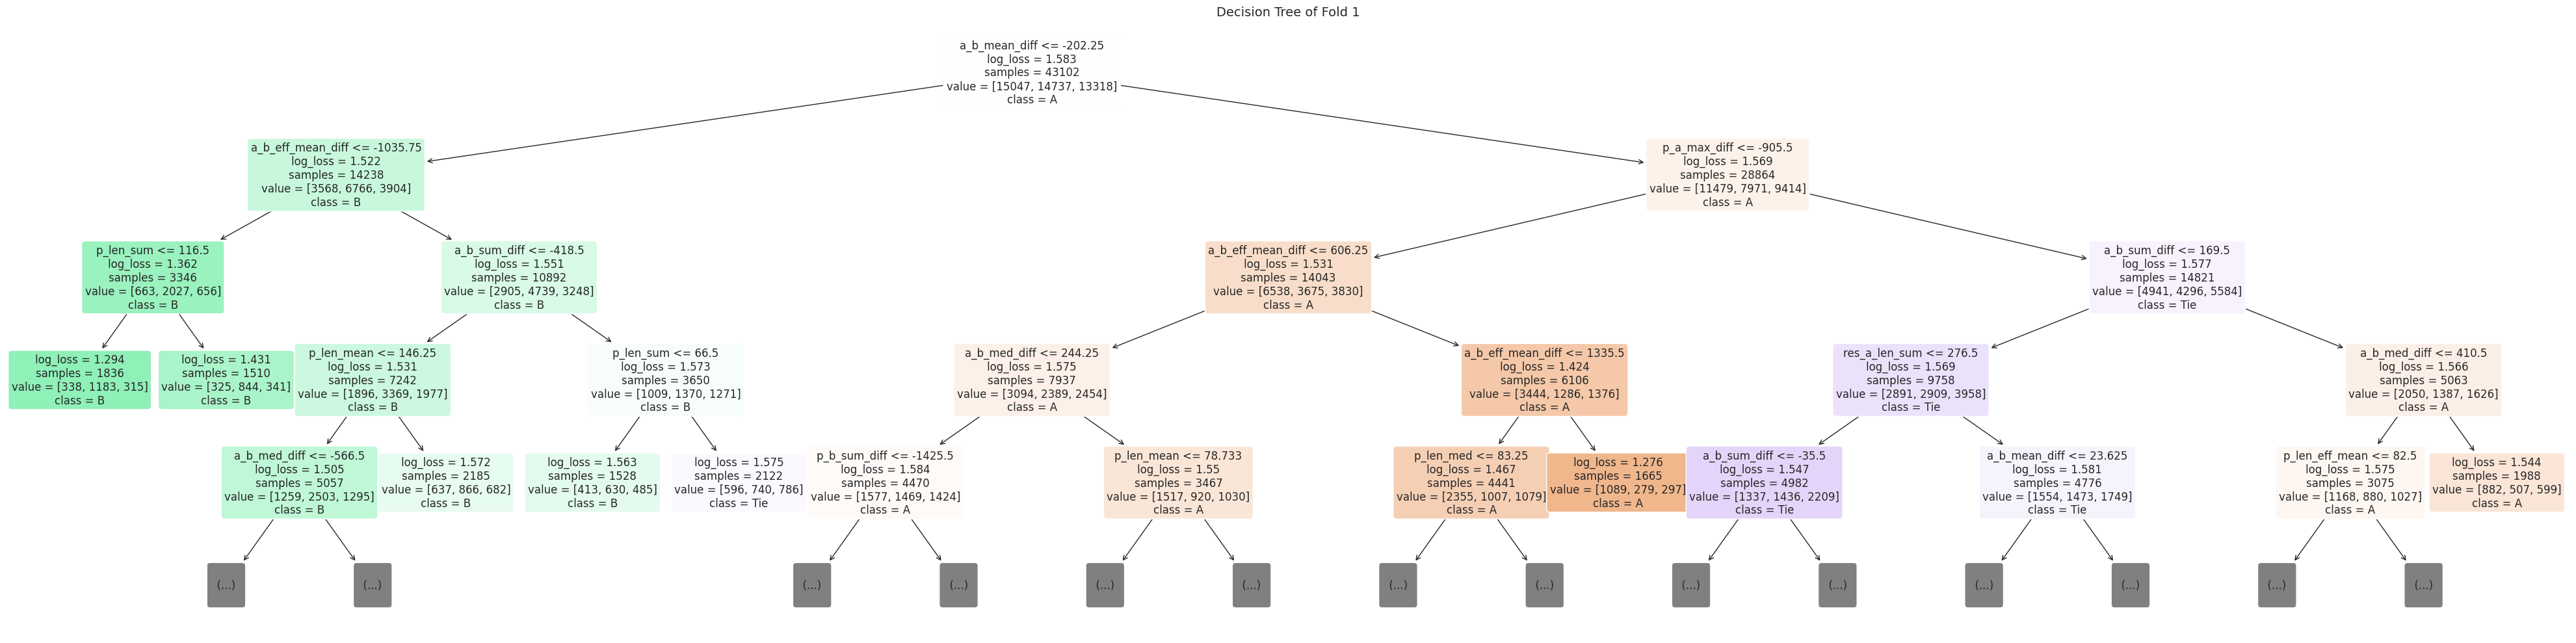

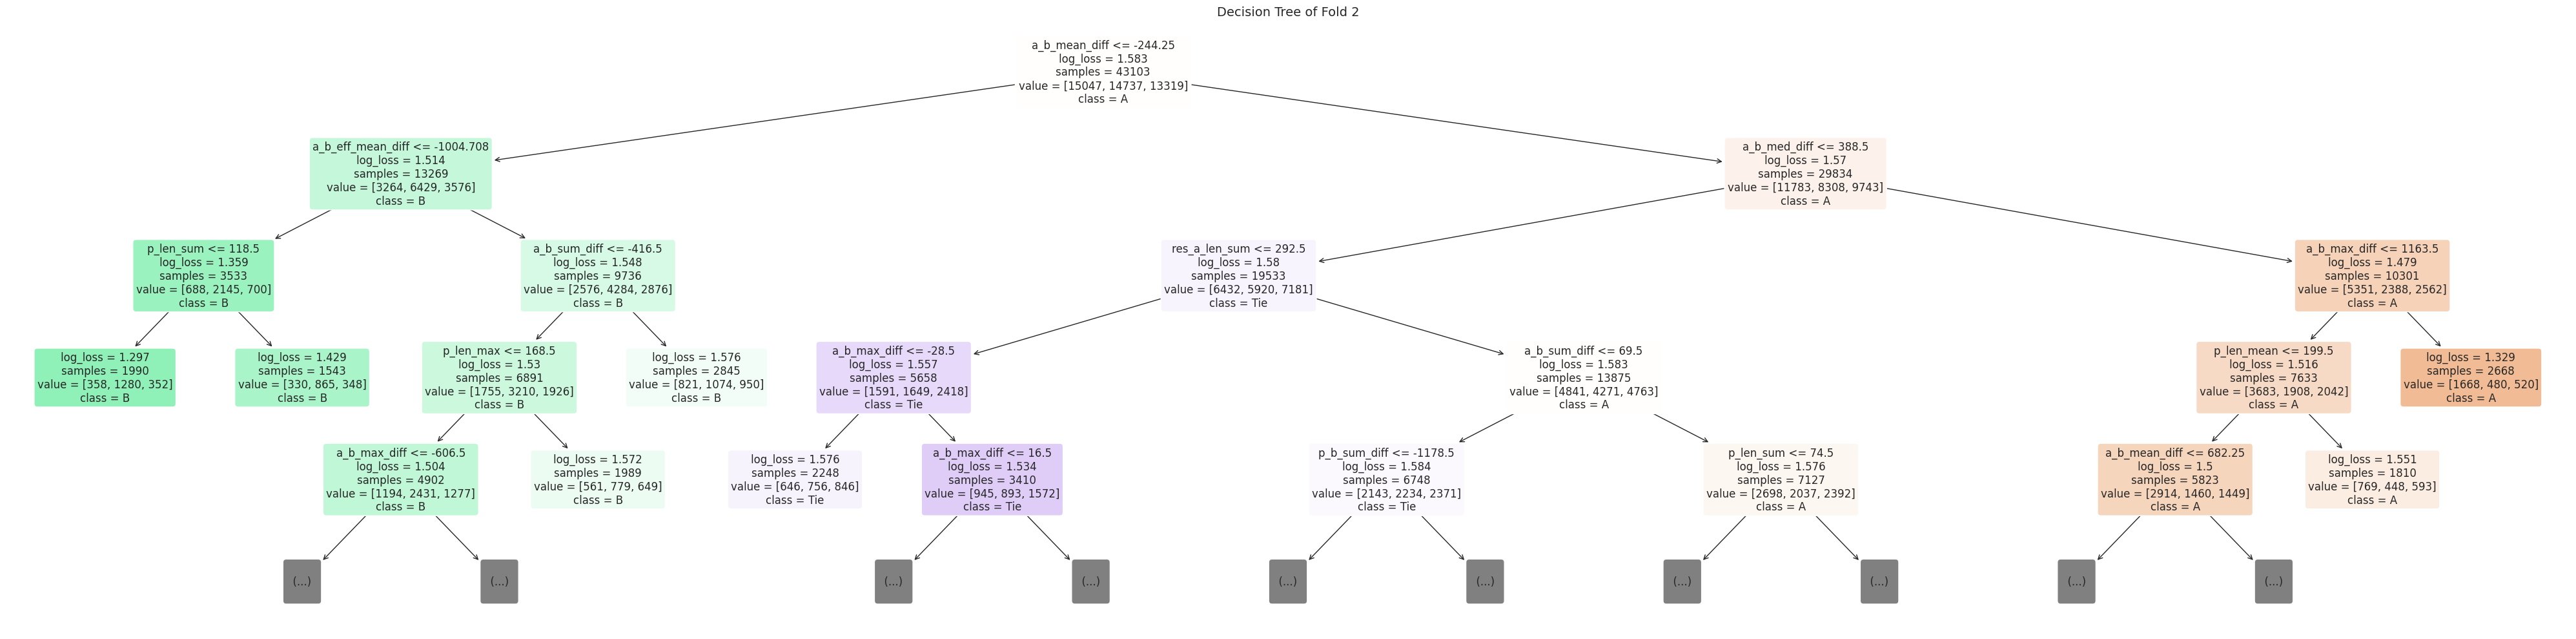

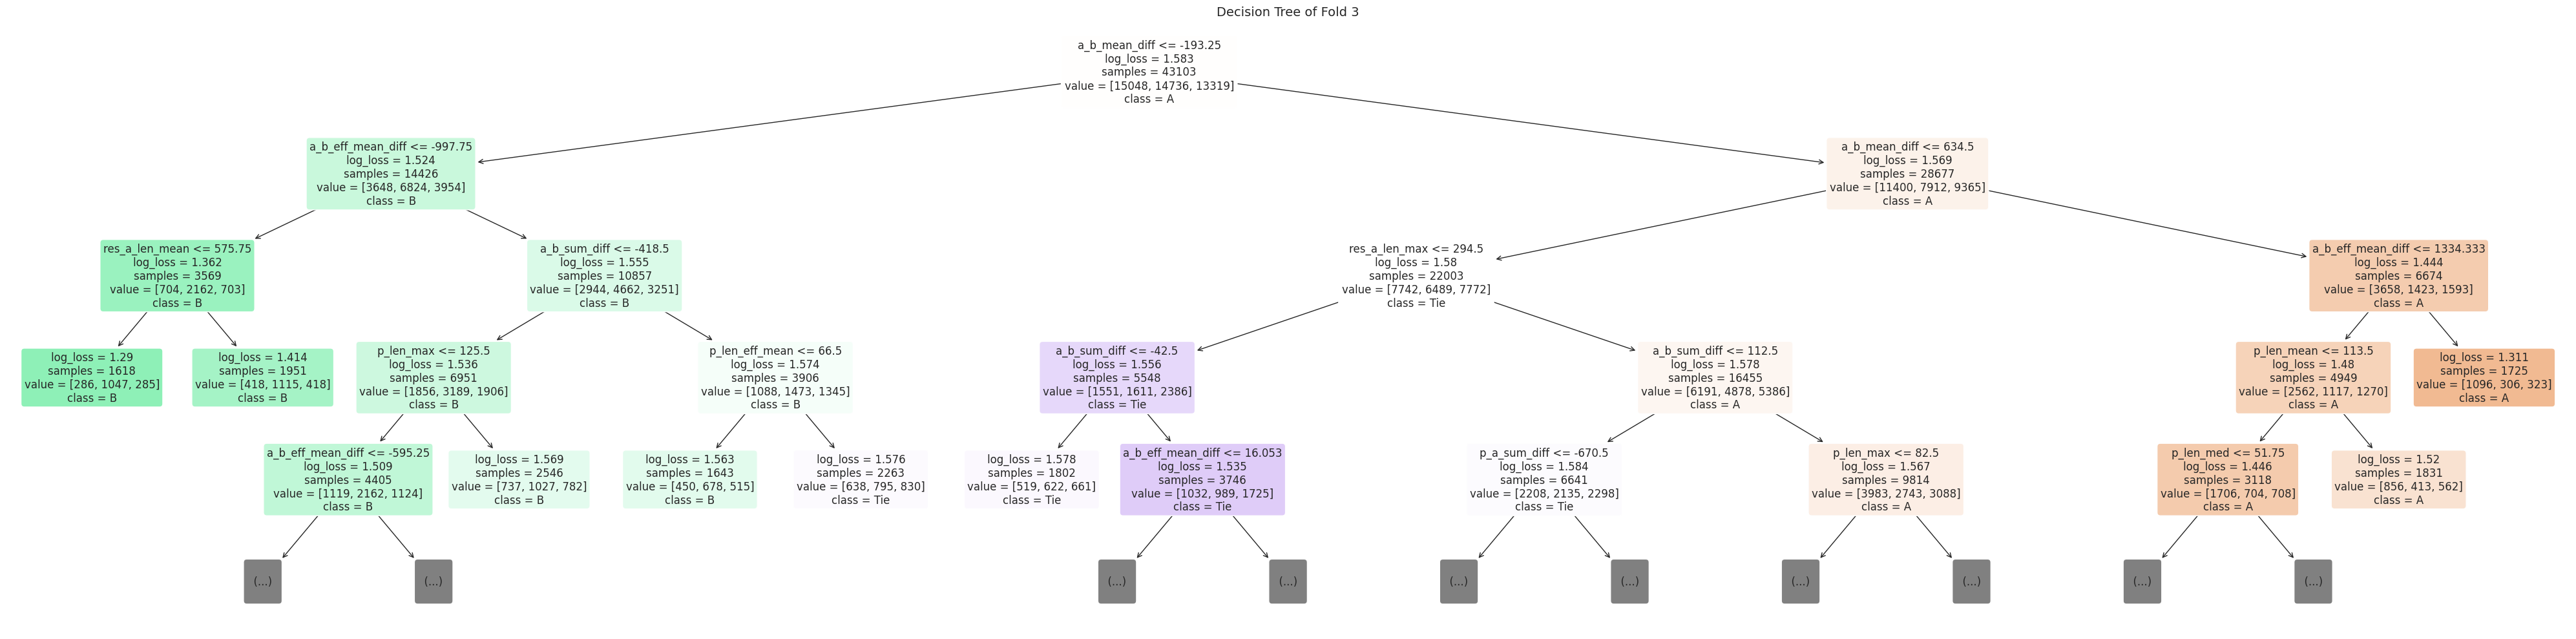

In [68]:
for fold, model in enumerate(models):
    fig, ax = plt.subplots(figsize=(40, 10))
    plot_tree(
        model, 
        feature_names=feats,
        class_names=["A", "B", "Tie"], 
        max_depth=4,
        filled=True, rounded=True, fontsize=12, ax=ax
    )
    ax.set_title(f"Decision Tree of Fold {fold}", fontsize=14)
    plt.tight_layout()

<a id="tfidf"></a>
### *TF-IDF*
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Term Frequency-Inverse Document Frequency (TF-IDF) is a commonly used technique to **vectorize** the text data. The core idea is to combine the strength of the association $tf(w, d)$ between a word $w$ and a document $d$ with the relevance $idf(w, c)$ of a word $w$ in a corpus $c$. To be concrete, $tf\text{-}idf$ can be defined as follows,
$$
    tf\text{-}idf(w, d, c) = tf(w, d) \times idf(w, c) = \frac{f_w}{\sum_{w' \in d} f_{w'}} \times log(\frac{1}{n_w\ /\ |c|})
$$
where $f_w$ is the number of occurrences of the word $w$ in the document $d$, $n_w$ is the number of documents containing the word $w$ at least once, and $|c|$ denotes the total number of documents in the corpus.<br>

An intuitive explanation is that the importance of a word $w$ is **proportional to its frequency in the document $d$**, but **inversely proportional to its occurrences in the entire corpus $c$**. Let's use some examples to consolidate the knowledge!

In [69]:
def _concat_turns(
    strs: List[Optional[str]],
    sep: str = " ",
) -> str:
    """Concat multiple turns of prompts/responses into a single string.
    
    Args:
        strs: A list of strings.
        sep: The separate character or word.
        
    Returns:
        The concatenated string.
    """
    strs = [s if s is not None else "None" for s in strs]  # Fix None strings
    cat_str = sep.join(strs)

    return cat_str


def _cal_tf(word: str, doc: str) -> float:
    """Calculate and return the term frequency."""
    tokens = doc.split()
    tc = sum(1 for token in tokens if token == word)  # Term count
    tf = tc / len(tokens)
    
    return tf


def _cal_idf(word: str, corpus: List[str]) -> float:
    """Calculate and return the inverse document frequency."""
    n_w = 0
    for doc in corpus:
        if word in doc.split():
            n_w += 1
            
    # Add 1 to avoid absent word (divided by zero)
    idf = np.log(len(corpus) / (n_w + 1))
    
    return idf

In [70]:
train["cat_prompt"] = train["prompt"].apply(lambda x: _concat_turns(x))
train["cat_res_a"] = train["response_a"].apply(lambda x: _concat_turns(x))
train["cat_res_b"] = train["response_b"].apply(lambda x: _concat_turns(x))
train.head(1)

model_a     model_b  \
0  gpt-4-1106-preview  gpt-4-0613   

                                              prompt  \
0  [Is it morally right to try to have a certain ...   

                                          response_a  \
0  [The question of whether it is morally right t...   

                                          response_b  winner_model_a  \
0  [As an AI, I don't have personal beliefs or op...               1   

   winner_model_b  winner_tie  n_prompts  n_res_a  n_res_b  n_na_prompts  \
0               0           0          2        2        2             0   

   n_empty_prompts  n_na_res_a  n_empty_res_a  n_na_res_b  n_empty_res_b  \
0                0           0              0           0              0   

   n_miss_res_a  n_miss_res_b  n_eff_res_a  n_eff_res_b  p_len_sum  \
0             0             0            2            2        158   

   p_len_mean  p_len_max  p_len_sum_log  p_len_mean_log  p_len_max_log  \
0        79.0         91       5.068904        4.382027       4.521789   

   res_a_len_sum  res_a_len_mean  res_a_len_max  res_a_len_sum_log  \
0           4460          2230.0           2922           8.403128   

   res_a_len_mean_log  res_a_len_max_log  res_b_len_sum  res_b_len_mean  \
0            7.710205           7.980366           1199           599.5   

   res_b_len_max  res_b_len_sum_log  res_b_len_mean_log  res_b_len_max_log  \
0            730           7.090077            6.397763           6.594413   

   res_len_mean_diff  res_len_mean_diff_clip len_diff_bucket_100  \
0             1630.5                  1630.5    (1487.0, 1697.0]   

  len_diff_bucket_250  n_miss_prompts  n_eff_prompts  na_prompt_ratio  \
0  (1605.744, 1697.0]               0              2              0.0   

   empty_prompt_ratio  miss_prompt_ratio  na_res_a_ratio  empty_res_a_ratio  \
0                 0.0                0.0             0.0                0.0   

   miss_res_a_ratio  na_res_b_ratio  empty_res_b_ratio  miss_res_b_ratio  \
0               0.0             0.0                0.0               0.0   

   p_len_med  p_len_std  res_a_len_med  res_a_len_std  res_b_len_med  \
0       79.0       12.0         2230.0          692.0          599.5   

   res_b_len_std  p_len_eff_mean  res_a_len_eff_mean  res_b_len_eff_mean  \
0          130.5            79.0              2230.0               599.5   

   p_a_sum_diff  p_b_sum_diff  a_b_sum_diff  p_a_mean_diff  p_b_mean_diff  \
0         -4302         -1041          3261        -2151.0         -520.5   

   a_b_mean_diff  p_a_max_diff  p_b_max_diff  a_b_max_diff  p_a_med_diff  \
0         1630.5         -2831          -639          2192       -2151.0   

   p_b_med_diff  a_b_med_diff  p_a_eff_mean_diff  p_b_eff_mean_diff  \
0        -520.5        1630.5            -2151.0             -520.5   

   a_b_eff_mean_diff  y                                         cat_prompt  \
0             1630.5  0  Is it morally right to try to have a certain p...   

                                           cat_res_a  \
0  The question of whether it is morally right to...   

                                           cat_res_b  
0  As an AI, I don't have personal beliefs or opi...

In [71]:
demo_corpus = train["cat_prompt"].iloc[:20].tolist()
for demo_word, doc_id in zip(["to", "I", "possibility"], [0, 3, 19]):
    print(f">>> Word \"{demo_word}\" <<<")
    print(f"## Doc {doc_id} ##")

    tf = _cal_tf(demo_word, demo_corpus[doc_id])
    idf = _cal_idf(demo_word, demo_corpus)
    tfidf = tf * idf

    print(f"TF {tf:.4f} | IDF {idf:.4f} | TF-IDF {tfidf:.4f}")
    print(f"-"*50)

>>> Word "to" <<<
## Doc 0 ##
TF 0.0690 | IDF 0.4308 | TF-IDF 0.0297
--------------------------------------------------
>>> Word "I" <<<
## Doc 3 ##
TF 0.1111 | IDF 1.6094 | TF-IDF 0.1788
--------------------------------------------------
>>> Word "possibility" <<<
## Doc 19 ##
TF 0.0175 | IDF 2.3026 | TF-IDF 0.0404
--------------------------------------------------


After understanding how TF-IDF works, we continue to improve our ML baselines with TF-IDF features. Here, we directly use `TfidfVectorizer` from `sklearn`.<br>

Some observations are summarized as follows,
1. Though we've specified `max_df` to ignore terms with high document frequencies, there still exist many **stopwords** providing limited information.
2. There exist **inflected** forms of the same word, which can be converted back to their root form by techniques like **stemming** and **lemmatization**.
3. When we view `prompt`, `response_a`, and `response_b` as different corpuses, we find out that `response_a` is more similar to `response_b` in terms of the inverse document frequency vector.

In [72]:
vectorizer_cfg = {
    "input": "content",
    "lowercase": True,
    "analyzer": "word",
    "ngram_range": (1, 3),
    "max_df": 0.95,
    "min_df": 10,
    "max_features": 300,
    "smooth_idf": True,
    "sublinear_tf": True,
}

In [73]:
cols = ["cat_prompt", "cat_res_a", "cat_res_b"]
vectorizers = {col: TfidfVectorizer(**vectorizer_cfg) for col in cols}

# Generate tf-idf features
X_tfidf = []
for col, vectorizer in vectorizers.items():
    x = vectorizer.fit_transform(train[col])
    X_tfidf.append(x.toarray())
X_tfidf = np.hstack(X_tfidf)

print(f"=== Inverse Documnet Frequency Vector ===")
for col, vec in vectorizers.items():
    print(f">>> {col} <<<")
    tmp = pd.DataFrame(vec.idf_, index=vec.get_feature_names_out()).sort_values(0, ascending=False)
    display(tmp.T)

=== Inverse Documnet Frequency Vector ===
>>> cat_prompt <<<


00   comment        id       int    enable     image      self  \
0  6.54739  6.285712  6.124225  6.124225  5.945321  5.673038  5.623982   

   the user    string  business      said      date      case    prompt  \
0  5.615155  5.468312  5.379785  5.371486  5.355092  5.336299  5.328352   

    company  description       key    action     table     state      room  \
0  5.312645     5.310051  5.294627  5.290808  5.278181  5.278181  5.268193   

     within      line     level      file     class     input      else  \
0  5.263237  5.263237  5.258305  5.254621  5.253397  5.250952  5.214977   

    process        11       100      task       him      15   current  \
0  5.200941  5.196306  5.189394  5.179114  5.143396  5.1423  5.097324   

       true    output        us   content    style      type    format  \
0  5.094188  5.088982  5.085872  5.085872  5.06741  5.066394  5.060321   

    context     point   in this     value    if the  questions        12  \
0  5.055288  5.048285  5.045298  5.044305  5.037378   5.034423  5.033441   

      order   because  you have    return      back       act  function  \
0  5.027564  5.025613  5.015913  5.014949  5.013022  5.007264  5.003443   

       20       set  character     below    as the      down    always  \
0  4.9949  4.985493   4.967859  4.966939  4.964186  4.962354  4.959613   

       made     last  would be     human       may       man        re  \
0  4.951435  4.94692  4.943323  4.942426  4.940634  4.935277  4.934387   

   sentence       our    you to   include    person       see  something  \
0  4.932609  4.931721  4.929948  4.929948  4.928178  4.911519   4.909781   

     is not     never      user   to make  the most     step      add  \
0  4.892569  4.884073  4.870627  4.863971  4.863143  4.85407  4.85243   

      start     life       let  response  the first     right     three  \
0  4.846708  4.84508  4.842642  4.833753   4.831342  4.822553  4.821757   

         go  based on     years    system   you can    by the    model  \
0  4.816999  4.815418  4.815418  4.815418  4.811476  4.808334  4.80442   

   generate       had  describe    every       end      much       did  \
0  4.798967  4.797414  4.794315  4.79277  4.789686  4.782781  4.773649   

       even       say      both   this is     short      high   through  \
0  4.772891  4.771379  4.771379  4.769868  4.762349  4.760852  4.760852   

    need to      next        ai  language      well       day    better  \
0  4.760105  4.758611  4.748956  4.748217  4.748217  4.741592  4.741592   

       find       old  that the   will be    before     given     game  \
0  4.728473  4.727025  4.720539  4.719821  4.718386  4.716238  4.70911   

   different  about the  should be      here      over    can be    who is  \
0     4.7084   4.705565   4.704858  4.704151  4.690813  4.684556  4.683171   

   information      such     been  the same      used      were   if you  \
0     4.683171  4.669425  4.66738  4.655193  4.640496  4.640496  4.63257   

       year   without  possible    do not   are the  the best     word  \
0  4.631912  4.629942  4.627321  4.625359  4.604673  4.593856  4.58378   

       same     words     while      long    number      very      must  \
0  4.576911  4.576289  4.575668  4.575668  4.563314  4.539655  4.534274   

      story   example       she  question    do you     based    people  \
0  4.533678  4.533082  4.520652  4.520652  4.518302  4.512451  4.507214   

       take     being     think       his      good      data   want to  \
0  4.506053  4.505474  4.504895  4.492236  4.488812  4.487673  4.483697   

     python      help    at the     world      work  how many  what are  \
0  4.480866  4.475229  4.467948  4.456849  4.454644  4.451346  4.441515   

    give me       her     it is       its   tell me        he     these  \
0  4.438259  4.435554  4.427483  4.399997  4.384991  4.363146  4.357134   

       just       now     after      know  from the    how to      text  \
0  4.353643  

>>> cat_res_a <<<


de    string   company     class    energy      file    method  \
0  5.321778  4.747479  4.548689  4.478607  4.401563  4.373247  4.350661   

    import     water     input      user      self    health      list  \
0  4.34423  4.320356  4.308391  4.277475  4.275632  4.253773  4.250176   

     game    light   content      body     state      step        am  \
0  4.2162  4.20284  4.192195  4.177063  4.172899  4.143425  4.129803   

   features       she  research     years      text    social   python  \
0  4.112446  4.105819  4.087343  4.085438  4.080123  4.063227  4.05507   

    systems  person    access      true        ll    return       end  \
0  4.054701  4.0375  4.037137  4.034963  4.014898  4.007124  4.005717   

    be used    values    level  performance      case       add     right  \
0  4.000459  3.994185  3.98244     3.976619  3.974232  3.966767  3.962719   

    current       her      lead  development  learning  can use  would be  \
0  3.962719  3.962382  3.952335     3.947018  3.939752  3.89976  3.897864   

      start   you are     power      open     small     means     human  \
0  3.890946  3.883453  3.880968  3.879418  3.875399  3.874165  3.872933   

        had    others      type    if the   factors       our  significant  \
0  3.853125  3.851316  3.850112  3.846808  3.846208  3.839042     3.830746   

   to create    better  the world      feel  the same  for example    may be  \
0   3.830746  3.825448   3.824861  3.823689  3.822225     3.821055  3.816391   

    use the       due  personal     value   want to     large       see  \
0  3.816391  3.813196  3.812906  3.812037  3.811458  3.810012  3.801665   

   experience      same  they are     range  it important to   because  \
0    3.800233  3.793388   3.78152  3.777036         3.774522  3.771736   

       day  help you    within  it important   to make  function  number of  \
0  3.77118  3.767019  3.762599      3.754637  3.754637  3.745925   3.745654   

       does  about the  understanding     down      made  following        ai  \
0  3.745112   3.742677       3.741058  3.73944  3.737557   3.724736  3.722086   

     during   always      long     still   several   to help      code  \
0  3.718123  3.71549  3.714439  3.713914  3.708677  3.708155  3.691844   

       name   support    you re       few      were  the most   context  \
0  3.690048  3.688767  3.684679  3.680861  3.679339  3.675036  3.673775   

        now        he     model   overall   that is      want   here is  \
0  3.668994  3.665236  3.664236  3.650344  3.650097  3.648867  3.630585   

   can help  understand    please  consider    ensure    at the  potential  \
0   3.62986    3.626246  3.625525  3.622645  3.622406  3.619535    3.61691   

        don  possible  which is  that can      good   in this       own  \
0  3.615958  3.606481  3.604832  3.601777  3.601307  3.592433  3.590111   

       his      even  here are some  language      life   complex   around  \
0  3.58502  3.583867       3.582945  3.569903  3.567859  3.567406  3.56243   

   note that  questions    before   process  used to     after    system  \
0   3.546759   3.545649  3.537473  3.530455   3.5298  3.529145  3.522619   

   are some       get      high    making     might   this is        re  \
0  3.495665  3.473953  3.464293  3.458785  3.453713  3.442043  3.437253   

        key      only      take       set    people   various   number  \
0  3.437253  3.436457  3.423217  3.423217  3.406089  3.394196  3.39153   

    need to      work    should   include   without      just      note  \
0  3.391149  3.388302  3.386976  3.382631  3.375493  3.374745  3.372503   

       best     known        my      know    by the       two     often  \
0  3.371384  3.358053  3.344534  3.329586  3.319094  3.310639  3.305216   

   there are      find     being      sure  important to      data   is not  \
0   3.303125  3.297223  3.284326  3.282449      3.281085  3.279554  3.27582   

       both        me     world      

>>> cat_res_b <<<


de    string   company     class      file    energy     water  \
0  5.330994  4.760852  4.523008  4.465162  4.385504  4.367174  4.341768   

     import     input      user      list    light   health      game  \
0  4.337841  4.336861  4.282099  4.233706  4.23106  4.22579  4.212735   

      self   content        am      step      body     state  features  \
0  4.18418  4.180824  4.148278  4.144636  4.142619  4.132593  4.100782   

        she  research    social      text   systems     years  control  \
0  4.100782  4.086962  4.083157  4.064718  4.062855  4.060625  4.05212   

     python    access      true    person  question    return  performance  \
0  4.047712  4.044783  4.034963  4.032794  4.021304  4.018096      4.01065   

         ll       end    values     level   current       add     right  \
0  4.008181  3.999061  3.977986  3.972191  3.969814  3.968798  3.966429   

    be used  development      lead  learning       her     start      open  \
0  3.959693     3.953669  3.947681  3.935811  3.923757  3.915372  3.911846   

    can use  would be     small   you are    if the   factors     means  \
0  3.899127  3.877561  3.873857  3.870167  3.869553  3.868633  3.866185   

      human  the world     power      had       our     value    others  \
0  3.857358   3.853125  3.846808  3.84531  3.843515  3.836665  3.836665   

    want to  for example     type    better   use the  significant  the same  \
0  3.831041     3.826329  3.82281  3.821932  3.813776     3.810879  3.807991   

     may be      feel  to create     large  experience  number of  personal  \
0  3.801092  3.800806   3.800233  3.798803    3.795095   3.790266  3.789416   

       see     range       due      same       day  it important to   to make  \
0  3.78885  3.786307  3.784051  3.780958  3.777875          3.77508  3.766189   

       made   because    within  it important  help you  they are  about the  \
0  3.761497  3.758198  3.756553      3.747824   3.74701    3.7443   3.738633   

   understanding      does  function      down     long     still   support  \
0       3.737288  3.730325  3.728991  3.728459  3.72633  3.720499  3.717069   

     during  following    always        ai       now      code      were  \
0  3.713651   3.709983  3.707894  3.706069  3.696219  3.696219  3.693128   

   several   overall     model      name      want   to help    you re  \
0  3.69056  3.685954  3.676553  3.672011  3.672011  3.669999  3.666237   

        few  the most        he  context  understand   that is    ensure  \
0  3.663737  3.648867  3.644204  3.64298    3.632761  3.627209  3.620013   

    here is  consider  can help  possible  potential  that can      even  \
0  3.619535  3.613105  3.612868  3.612156   3.609315  3.608606  3.601307   

     at the    please       don  around       own  here are some      good  \
0  3.600838  3.598262  3.594994  3.5922  3.590807       3.586175  3.585944   

   which is   complex       his   in this      life   used to    system  \
0  3.584098  3.582255  3.578121  3.566952  3.563784  3.555459  3.551211   

   language   process  questions     after  note that    before  are some  \
0  3.546759  3.544983   3.540559  3.533519    3.53133  3.511193  3.498201   

        get      high       key    making     might   this is      only  \
0  3.474779  3.456347  3.451489  3.443043  3.436258  3.434668  3.430112   

        set    people    number      take        re   various   need to  \
0  3.429321  3.423217  3.417735  3.417345  3.414617  3.414033  3.404161   

       just      work   without      best   include    should      note  \
0  3.383574  3.382065  3.377367  3.366735  3.365067  3.363401  3.357685   

     known       my    by the      know     often     being  there are  \
0  3.34726  3.34399  3.327978  3.325661  3.313098  3.302951   3.302602   

       find      two      both  important to      sure      data        me  \
0  3.297915  3.28655  3.281596      3.277515  3.276498  3.274973  3.257024   

     is not  

In [74]:
prompt_feats = vectorizers["cat_prompt"].get_feature_names_out()
res_a_feats = vectorizers["cat_res_a"].get_feature_names_out()
res_b_feats = vectorizers["cat_res_b"].get_feature_names_out()

print(f"=== Symmetric Difference of Top-300 Features ===")
print(f">>> Prompt v.s. Response A <<<")
print(set(prompt_feats).symmetric_difference(set(res_a_feats)))
print()
print(f">>> Prompt v.s. Response B <<<")
print(set(prompt_feats).symmetric_difference(res_b_feats))
print()
print(f">>> Response A v.s. Response B <<<")
print(set(res_a_feats).symmetric_difference(set(res_b_feats)))

=== Symmetric Difference of Top-300 Features ===
>>> Prompt v.s. Response A <<<
{'several', 'are the', 'social', 'us', 'that is', 'comment', 'body', 'still', 'write', 'light', 'describe', 'point', 'the following', 'note', '100', 'can you', 'give me', 'task', 'why', 'action', 'him', 'who is', 'own', 'every', 'output', 'performance', 'date', 'say', 'to create', 'table', 'must', 'go', 'others', 'may be', 'character', 'small', '00', 'used to', 'often', 'which is', 'making', 'do not', 'significant', 'understanding', 'year', 'energy', '12', 'never', 'use the', 'research', 'features', 'power', 'note that', 'development', 'known', 'experience', 'three', 'generate', 'the first', 'important', 'sentence', 'explain', 'help you', 'how many', 'last', 'including', 'next', 'much', 'open', 'enable', 'that can', 'id', 'question', 'story', 'image', 'to help', 'such as', 'various', 'overall', 'old', 'what is', 'man', 'can help', 'they are', 'you re', 'tell', 'range', 'here are some', 'few', 'here are', 'w

To see if adding $tf\text{-}idf$ feature vectors helps boost the ML model performance, we first re-run our one-feature baseline using lgbm.<br>

Again, we can't even beat the naive baseline method based on the response length difference bucket.

In [75]:
# Prepare data
X, y = train[["a_b_eff_mean_diff"]], train["y"]

# Build cross validator
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Build models
model_cfg = {
    "max_depth": 4,
    "n_estimators": 50,
    "random_state": 42,
    "n_jobs": -1,
    "verbose": -1,
}
models = [LGBMClassifier(**model_cfg) for _  in range(4)]

# Run local cross validation
scores = _run_cv(X, y, skf, models)
print(f"\n>>> Performance Report <<<")
print(f"OOF log loss | {np.mean(scores):.4f} +- {np.std(scores):.4f}")

## Fold 0 ##
Log loss | Train 1.0529 | Val 1.0560
## Fold 1 ##
Log loss | Train 1.0521 | Val 1.0579
## Fold 2 ##
Log loss | Train 1.0512 | Val 1.0612
## Fold 3 ##
Log loss | Train 1.0537 | Val 1.0536

>>> Performance Report <<<
OOF log loss | 1.0572 +- 0.0028


So, let's see what will happen after we feed $tf\text{-}idf$ features into the model.<br>

Hooray! We can see that our ML baseline has a performance boost from ~1.057 to ~1.037 (improve around 0.02).

In [76]:
# Prepare data
tfidf_feats = (
    [f"{feat}(prompt)" for feat in prompt_feats]
    + [f"{feat}(res_a)" for feat in res_a_feats]
    + [f"{feat}(res_b)" for feat in res_b_feats]
)
X = pd.DataFrame(X_tfidf, columns=tfidf_feats)
X["a_b_eff_mean_diff"] = train["a_b_eff_mean_diff"]
y = train["y"]

# Build cross validator
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Build models
model_cfg = {
    "max_depth": 5,
    "n_estimators": 200,
    "colsample_bytree": 0.2,
    "random_state": 42,
    "n_jobs": -1,
    "verbose": -1,
}
models = [LGBMClassifier(**model_cfg) for _  in range(4)]

# Run local cross validation
scores = _run_cv(X, y, skf, models)
print(f"\n>>> Performance Report <<<")
print(f"OOF log loss | {np.mean(scores):.4f} +- {np.std(scores):.4f}")

## Fold 0 ##
Log loss | Train 0.9062 | Val 1.0351
## Fold 1 ##
Log loss | Train 0.9046 | Val 1.0387
## Fold 2 ##
Log loss | Train 0.9042 | Val 1.0393
## Fold 3 ##
Log loss | Train 0.9046 | Val 1.0328

>>> Performance Report <<<
OOF log loss | 1.0365 +- 0.0027


<a id="topic"></a>
## 5. Topic Modeling
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

Following [this paper](https://arxiv.org/pdf/2403.04132), we're now going to implement section 6.1, **Topic Modeling on User Prompts**, to further explore prompts in the training set.

<a id="bert"></a>
### [`BERTopic`](https://github.com/MaartenGr/BERTopic)
[**<span style="color:#FEF1FE; background-color:#535d70;border-radius: 5px; padding: 2px">Go to Table of Content</span>**](#toc)

> BERTopic is a **topic modeling** technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. \- [BERTopic](https://github.com/MaartenGr/BERTopic)

With `BERTopic`, we can handily build a topic modeling pipeline, which generates dense topic clusterings. Briefly speaking, the topic modeling task is modularized as a six-step process,
1. Convert documents to numerical representations (*i.e.,* dense embeddings).
2. Reduce the dimensionality to mitigate the curse of dimensionality.
3. Cluster documents into dense clusters.
4. Generate the vectorized topic representations on the cluster level.
    * Concatenate all documents in one topic into a single string (*e.g.,* cluster-level document) first.
    * Apply [BoW](https://en.wikipedia.org/wiki/Bag-of-words_model) to vectorize these documents.
5. Measure the importance of words on the cluster level.
    * Apply [Class-based TF-IDF](https://github.com/MaartenGr/cTFIDF), which can be viewed as a modified version of the classical TF-IDF.
6. Further fine-tune the topic representations.

In [77]:
def _seed_everything(seed: int) -> None:
    """Seed the current experiment.

    Note that it can't always guarantee reproducibility.

    Args:
        seed: The automatically generated or manually specified seed.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # When running with cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

seed = 16888
_seed_everything(seed)

In [78]:
# Setup modules
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(
    n_neighbors=20, 
    n_components=5,
    min_dist=0.0, 
    metric="cosine",
    random_state=seed,
)
hdbscan_model = HDBSCAN(
    min_cluster_size=32, 
    min_samples=1,
    metric="euclidean", 
    cluster_selection_method="eom",
    prediction_data=True
)
vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer()
representation_model = MaximalMarginalRelevance(diversity=0.3)

# Build topic modeling pipeline
topic_model = BERTopic(
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  ctfidf_model=ctfidf_model,
  representation_model=representation_model,
)

# Run topic modeling
docs = train["cat_prompt"].tolist()
topics, _ = topic_model.fit_transform(docs)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

After topic modeling is done, let's first take a look at the top frequent topics!

Note that `-1` represents the outliers, which we can just ignore temporarily. Taking a quick glance, we can find some interesting topics. For examples, the topic `0` seems related to traveling, cities, and capitals. Also, the topic `4` can be associated with pets.

In [79]:
topic_info = topic_model.get_topic_info()
topic_info.head(10)

Topic  Count                                   Name  \
0     -1  21409               -1_write_data_text_class   
1      0   1192      0_visit_japan_itinerary_mountains   
2      1    767            1_rhoades_lana_krauss_nicky   
3      2    668         2_letters_words_gguf_crossword   
4      3    616            3_recipe_cookies_cook_bread   
5      4    508           4_cricket_league_won_players   
6      5    505  5_ai_laborers_artificial_intelligence   
7      6    443             6_poem_rhyme_sonnet_rhymes   
8      7    406        7_games_mario_videogames_mickey   
9      8    397                8_345_calculate_24_step   

                                      Representation  \
0  [write, data, text, class, code, information, ...   
1  [visit, japan, itinerary, mountains, taiwan, c...   
2  [rhoades, lana, krauss, nicky, filling, ricky,...   
3  [letters, words, gguf, crossword, semantic, an...   
4  [recipe, cookies, cook, bread, recipes, foods,...   
5  [cricket, league, won, players, batting, nba, ...   
6  [ai, laborers, artificial, intelligence, agent...   
7  [poem, rhyme, sonnet, rhymes, verse, poetry, s...   
8  [games, mario, videogames, mickey, videogame, ...   
9  [345, calculate, 24, step, numbers, 666, integ...   

                                 Representative_Docs  
0  [Here are two excerpts from two different auth...  
1  [Hi, please list the states of Germany with th...  
2  [History of the company NK Arsenal.\nIt was fo...  
3  [Tell me a sentence but every word in the sent...  
4  [I'm a picky eater in Japan. I eat processed c...  
5  [Look at the following table:\n\n| Rank | 1 | ...  
6         [What is AI?, What is an AI ?, what is AI]  
7  [Write poem, write a poem with a a b c b c, wr...  
8  [We have two different things: the game Long D...  
9  [What is 345*679?, •\tTo solve math problems, ...

We now know that each topic can be represented by a set of **keywords**. But, we may want to understand how many keywords are needed to describe a topic. The following c-TF-IDF chart helps us  get the idea about how the term measures decline when keywords are added into each topic one by one.<br>

Here, we observe that topic `161` has the much greater term score at the first point with the keyword `"dot"`, but the scores diminish immediately. Let's see what's going on.

In [80]:
topic_model.visualize_term_rank()

As can be seen, the topic 161 captures all conversations that contain only prompts instructing the chatbot to write a single dot!<br>

Hence, term scores serve as a good measure for us to determine how representative the topic keywords are.

In [81]:
doc_info = topic_model.get_document_info(docs=docs)
print(f">>> Unique Prompts in Topic 161 <<<")
print(doc_info.query("Topic == 161")["Document"].unique())

>>> Unique Prompts in Topic 161 <<<
["There is now widespread mass transmission of COVID-19 globally and significant resistance to evidence-based public health advice and interventions. What's strategies can now be used to regain local elimination of the disease in populations where there was previously good control of the disease?"
 'Explain the COVID-19 pandemic, in emojis only.'
 'major studies on recommended interval between mrna covid vaccines'
 'Do COVID  vaccine have severe side effect?'
 "There are documents with patient information about Covid-19. Describe 5 burroughs that had Covid-19 in the city of New York. Include doctor's names for patients that got a positive diagnosis and treatment."
 'Why did Borros Johnson delay lockdown during the early days of Covid 19 and was it the right strategy '
 'What is your opinion on Afghanistan 2021? (100 word)'
 'Tell me 5 facts about COVID-19 Number of total people died with Covid tell me 5 things about the shape of square'
 "A few years

After single topic analysis, we might want to know about how topics are interrelated to one another. Here, we plot the top 100 frequent topics in a 2D plane. Then, we can start exploring topic relationships. Some observations are summarized as follows,
1. Topic 0 and 82 at the first quadrant are related to traveling and attractions.
2. Topic 26, 53, and 68 at the third quadrant talk about politics and wars.
3. Topic 9 and 40 at the fourth quadrant are about music.

, etc.

In [82]:
topic_model.visualize_topics(top_n_topics=100)

Finally, we can visualize the similarity matrix just as the official paper. And, we can find out that a small portion of topics are strongly correlated with others. But, they're somewhat diversed generally.

In [83]:
topic_model.visualize_heatmap(top_n_topics=20)